In [1]:
# the building we want to run
building_id = 2
# Price of the panel
price = 106
# this will create a folder which will save the files
iteration = 30
# optimization method
# Currently implemented are: rbf-net, rbf-cost, ga-50, ga-20
opt_method = "rbf-cost"
# Number of evaluations:
number_of_opt_evaluations = 100
# number of run
run_i=2
# Some cluster solution
base_path=""

In [2]:
# Parameters
opt_method = "ga-20"
number_of_opt_evaluations = 200
run_i = 4


In [3]:
# Important file names 
# This is where the optimal solution or final population of solutions is provided
ga_file = "panel_{}_{}_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)
# here we store every run that optmizer runs
ga_proc = "panel_{}_{}_archive_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)
# Here we combine the optimal solution with the addition information that we are interested in.
ga_fina = "panel_{}_{}_processed_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)

In [4]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = base_path+'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = base_path+'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)
ga_file=ga_output_dir+ga_file
ga_proc=ga_output_dir+ga_proc
ga_fina=ga_output_dir+ga_fina



# Weather file
epw_file   = base_path+'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = base_path+'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [5]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
error_dir  = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
ensure_dir(output_dir)

# EHUB
ehub_dir   = base_path+'ehub/output_ehub_excel/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = base_path+"rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
ep_path="/home/theochri/projects/def-revins/theochri/EnergyPlus/"

# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [8]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir,
                                   epw_file=epw_file, err_dir=error_dir,ep_path=ep_path)

/home/theochri/projects/def-revins/theochri/EnergyPlus/


## the North Axis
The north axis gets grabbed automatically from the idf.

In [9]:
pvbuilding.North_Axis

0.0

In [10]:
pvbuilding.Building_Information


Building,
    Ref Bldg Small Office New2004_v1.3_5.0,    !- Name
    0.0,                      !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [11]:
# Determine the hourly electricity use
pvbuilding.run_ep(ep_path=ep_path)

EnergyPlus is found in the path: /home/theochri/projects/def-revins/theochri/EnergyPlus/


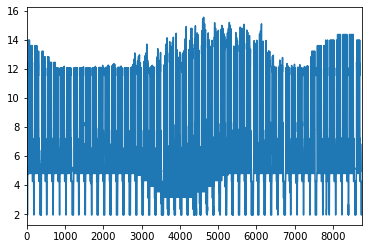

In [12]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [13]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 2,059.63
14.35220436334519


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [14]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 599 m2
Roof area is up 29 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [15]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.2701334953308105 sec


ERROR:root:Finished Generation of Irradiance


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 1.9874887466430664 sec


ERROR:root:Finished Generation of Irradiance


0.0


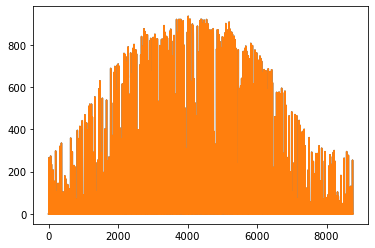

In [16]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)
Loading the model
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.977515697479248 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9360697269439697 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9067232608795166 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [307.537, 0.0, 0.0]


ERROR:ga_logger:Cost: 3187.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,188 per year


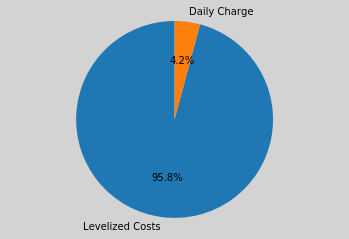

Total roof area of the  building: 599 m2
Total roof area used 473 m2
Percentage: 79.0%


In [17]:
from pv_model import pvModel
# this was the optimal solution
pan_vals = (155,175,260,26,36,36,0.65,0.7,0.9)
gcr=(0.65,0.7,0.9)
print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.

default_settings = {
                    'name': 'glpk-cluster',
                    'solver_path': '/home/theochri/ENV/bin/glpsol',
                    'options': {
                                'mipgap': 0.05,
                               },
                    }
# preload the excel
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels,
                           factor_multiplier=3,
                           solver_settings=default_settings)
my_model.eval_model(pan_vals,106,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [18]:
my_model.energyIm

61845.7

In [19]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    0.0
dtype: float64

In [20]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr         4805.72
Aug         5680.08
Dec         5274.31
Feb         4713.95
Jan         5340.70
Jul         5200.48
Jun         5124.65
Mar         5319.26
May         5015.79
Nov         5153.19
Oct         5154.70
Sep         5062.88
monthly_import    61845.71
dtype: float64
61845.7
     monthly_export
Apr         6899.34
Aug         8061.75
Dec         1351.01
Feb         2744.22
Jan         1541.01
Jul         9311.54
Jun         7990.47
Mar         4415.47
May         8175.98
Nov         1793.90
Oct         3229.92
Sep         6330.97
monthly_export    61845.58
dtype: float64
61845.6
133.042


In [21]:
my_model.solveResults['solution']['daily_charge_c']

133.042

In [22]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng             0
Grid                 1
Invertor             1
PV0                  1
PV1                  0
PV2                  0

In [23]:
my_model.solveResults['solution']['any_above_35']

0

In [24]:
my_model.solveResults['solution']['a150_or_a550']

0

# (D) GA - Optimize the model

In [25]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

In [26]:
# preload the excel
from pyehub.excel_to_request_format import convert

request_format = convert(excel_file=ehub_file)

In [27]:
import logging
lrun       = logging.getLogger('Runs_logger')
hdlrun       = logging.FileHandler('runs_logger.txt')
formatterrun  = logging.Formatter('%(asctime)s %(message)s')
hdlrun.setFormatter(formatterrun)
lrun.addHandler(hdlrun) 
lrun.setLevel(logging.ERROR)

In [28]:
import time
t1=time.time()

pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                         range_tilt=range_tilt,
                         range_gcr=range_gcr,
                         pvpanel=pvpanel,
                         price=price,
                         store_file=ga_file,
                         ehub_request=request_format,
                         res_file=res_file,
                         pvbuilding=pvbuilding,
                         roof_area_per_unit_capacity=roof_area_per_unit_capacity,
                         ga_proc=ga_proc,
                         solver_settings=default_settings)



ERROR:optimizer_logger:Found the solver set


/home/theochri/paper_pusher/lib/python3.6/site-packages/besos/evaluator.py:395: FutureWarning: EvaluatorSR has been renamed as EvaluatorGeneric with same functionaility. EvaluatorSR will be removed in a future release.
  warn(msg, FutureWarning)
ERROR:optimizer_logger:Started {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:0


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (243.01600824758265, 169.03326744670755, 170.05238499381747, 42.70670526359168, 24.99856491821896, 2.1596009437994583, 0.602022118419958, 0.8605081411894471, 0.5456784721876966)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 243
                                           a tilt of 42.7
                                           and a gcr of 0.602


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9739508628845215 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 169
                                           a tilt of 25.0
                                           and a gcr of 0.861


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7727553844451904 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 2.2
                                           and a gcr of 0.546


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6948695182800293 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 318.003, 0.0]


ERROR:ga_logger:Cost: 3291.53


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,292 per year


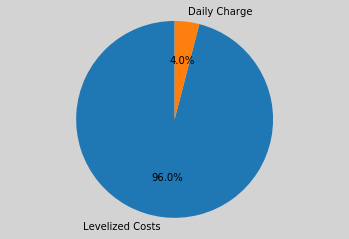

Total roof area of the  building: 599 m2
Total roof area used 370 m2
Percentage: 61.7%
succes
[[243.01600824758265, 169.03326744670755, 170.05238499381747, 42.70670526359168, 24.99856491821896, 2.1596009437994583, 0.602022118419958, 0.8605081411894471, 0.5456784721876966, 3291.53, 318.003, 0.0, 318.003, 0.0, {'Levelized Costs': 3158.472, 'Energy Charge': 0.016000000000190084, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.5996353153, 61845.7, 369.552]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (177.22798490953235, 147.50431933142505, 226.1811293031191, 24.258144754482007, 38.51681514825345, 16.605962928126313, 0.40838649558895757, 0.21893706893020864, 0.7954591870148748)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 177
                                           a tilt of 24.3
                                           and a gcr of 0.408


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9108710289001465 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 148
                                           a tilt of 38.5
                                           and a gcr of 0.219


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8526017665863037 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 226
                                           a tilt of 16.6
                                           and a gcr of 0.795


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8285250663757324 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [177.645, 0.0, 130.272]


ERROR:ga_logger:Cost: 3191.35


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,191 per year


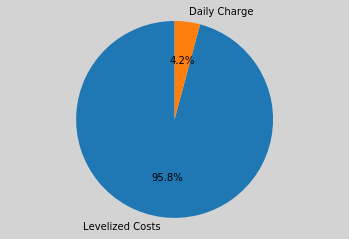

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[177.22798490953235, 147.50431933142505, 226.1811293031191, 24.258144754482007, 38.51681514825345, 16.605962928126313, 0.40838649558895757, 0.21893706893020864, 0.7954591870148748, 3191.35, 307.91700000000003, 177.645, 0.0, 130.272, {'Levelized Costs': 3058.301, 'Energy Charge': 0.007000000000118689, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60022242838, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (126.55977578065495, 218.49539091045753, 191.44875888202364, 29.84588055177778, 7.956071752597102, 22.28836208693566, 0.2652452191639549, 0.5724858106232313, 0.6952929626512536)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 127
                                           a tilt of 29.8
                                           and a gcr of 0.265


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.924373149871826 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 218
                                           a tilt of 8.0
                                           and a gcr of 0.572


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.978996753692627 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 191
                                           a tilt of 22.3
                                           and a gcr of 0.695


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9177942276000977 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 304.98]


ERROR:ga_logger:Cost: 3162.18


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,162 per year


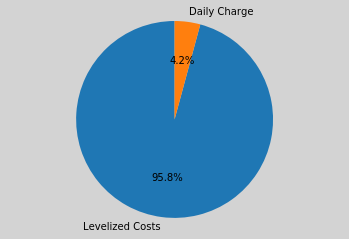

Total roof area of the  building: 599 m2
Total roof area used 439 m2
Percentage: 73.3%
succes
[[126.55977578065495, 218.49539091045753, 191.44875888202364, 29.84588055177778, 7.956071752597102, 22.28836208693566, 0.2652452191639549, 0.5724858106232313, 0.6952929626512536, 3162.18, 304.98, 0.0, 0.0, 304.98, {'Levelized Costs': 3029.1299999999997, 'Energy Charge': 0.008000000000265572, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60089696834, 61845.7, 438.636]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (208.3424341557199, 93.72097037630573, 111.87549789301782, 30.236215531893983, 38.872093635501614, 45.84086264057969, 0.3919795000822258, 0.4854490748423917, 0.845106425851508)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 208
                                           a tilt of 30.2
                                           and a gcr of 0.392


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.05080509185791 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 94
                                           a tilt of 38.9
                                           and a gcr of 0.485


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8034169673919678 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 112
                                           a tilt of 45.8
                                           and a gcr of 0.845


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1896400451660156 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [115.64, 0.0, 256.698]


ERROR:ga_logger:Cost: 3831.19


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,831 per year


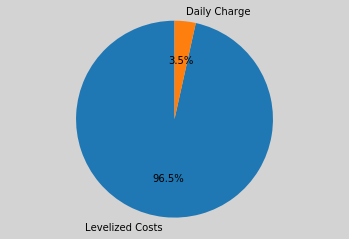

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[208.3424341557199, 93.72097037630573, 111.87549789301782, 30.236215531893983, 38.872093635501614, 45.84086264057969, 0.3919795000822258, 0.4854490748423917, 0.845106425851508, 3831.19, 372.33799999999997, 115.64, 0.0, 256.698, {'Levelized Costs': 3698.139, 'Energy Charge': 0.009000000000014552, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60232040005, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (169.9387232650136, 113.60354803239355, 256.325543084807, 6.929781068030037, 34.04221479345412, 23.693297279241293, 0.8200360286083037, 0.33709080186148366, 0.4545830753273707)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 6.9
                                           and a gcr of 0.820


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8948960304260254 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 114
                                           a tilt of 34.0
                                           and a gcr of 0.337


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7839276790618896 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 256
                                           a tilt of 23.7
                                           and a gcr of 0.455


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8248651027679443 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [321.102, 0.0, 0.0]


ERROR:ga_logger:Cost: 3322.3


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,322 per year


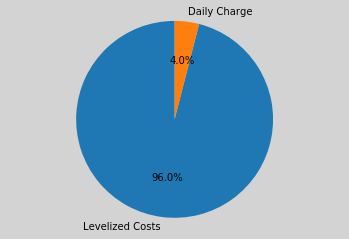

Total roof area of the  building: 599 m2
Total roof area used 392 m2
Percentage: 65.4%
succes
[[169.9387232650136, 113.60354803239355, 256.325543084807, 6.929781068030037, 34.04221479345412, 23.693297279241293, 0.8200360286083037, 0.33709080186148366, 0.4545830753273707, 3322.3, 321.102, 321.102, 0.0, 0.0, {'Levelized Costs': 3189.246, 'Energy Charge': 0.012000000000284672, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60183315925, 61845.7, 391.57]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (136.69670570821216, 188.94367129482177, 171.91976719966982, 33.814990068854, 26.80675754178056, 35.29575958836327, 0.2079131295948468, 0.46318747827145224, 0.624720301861766)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 137
                                           a tilt of 33.8
                                           and a gcr of 0.208


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2974376678466797 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 189
                                           a tilt of 26.8
                                           and a gcr of 0.463


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8360955715179443 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 172
                                           a tilt of 35.3
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.827307939529419 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 219.701, 77.7392]


ERROR:ga_logger:Cost: 3087.29


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,087 per year


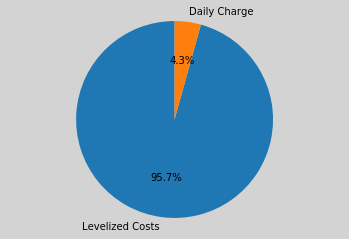

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[136.69670570821216, 188.94367129482177, 171.91976719966982, 33.814990068854, 26.80675754178056, 35.29575958836327, 0.2079131295948468, 0.46318747827145224, 0.624720301861766, 3087.29, 297.4402, 0.0, 219.701, 77.7392, {'Levelized Costs': 2954.233, 'Energy Charge': 0.014999999999986358, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600051014364, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (242.35082116328155, 129.0286335942946, 261.06270881905743, 13.850261732501266, 35.68540642344508, 53.03523461121321, 0.796198472172911, 0.8535410662040543, 0.2214618020462821)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 242
                                           a tilt of 13.9
                                           and a gcr of 0.796


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6886043548583984 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 129
                                           a tilt of 35.7
                                           and a gcr of 0.854


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8617873191833496 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 261
                                           a tilt of 53.0
                                           and a gcr of 0.221


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9097626209259033 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [335.645, 0.0, 0.0]


ERROR:ga_logger:Cost: 3466.75


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,467 per year


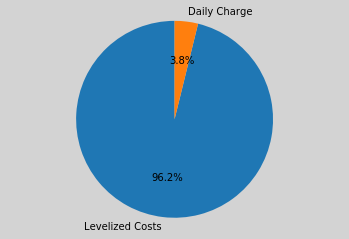

Total roof area of the  building: 599 m2
Total roof area used 422 m2
Percentage: 70.4%
succes
[[242.35082116328155, 129.0286335942946, 261.06270881905743, 13.850261732501266, 35.68540642344508, 53.03523461121321, 0.796198472172911, 0.8535410662040543, 0.2214618020462821, 3466.75, 335.645, 335.645, 0.0, 0.0, {'Levelized Costs': 3333.7000000000003, 'Energy Charge': 0.008000000000038199, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60032139846, 61845.7, 421.56]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (98.30413734068203, 115.26448358499101, 206.89297927256547, 9.60973498522618, 41.76667145722556, 38.97904803197546, 0.6849949289472499, 0.23680431917695563, 0.843014890673836)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 98
                                           a tilt of 9.6
                                           and a gcr of 0.685


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.421959638595581 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 41.8
                                           and a gcr of 0.237


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1278977394104004 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 207
                                           a tilt of 39.0
                                           and a gcr of 0.843


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.014784336090088 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [294.889, 39.8455, 0.0]


ERROR:ga_logger:Cost: 3457.71


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,458 per year


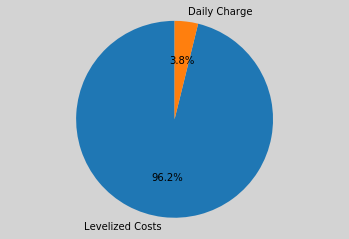

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[98.30413734068203, 115.26448358499101, 206.89297927256547, 9.60973498522618, 41.76667145722556, 38.97904803197546, 0.6849949289472499, 0.23680431917695563, 0.843014890673836, 3457.71, 334.7345, 294.889, 39.8455, 0.0, {'Levelized Costs': 3324.665, 'Energy Charge': 0.003000000000156433, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60223286033, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (170.67108865882528, 244.35380264588625, 180.90587033561877, 2.900752762696747, 1.5405711168283704, 49.71173654516693, 0.7344496488327112, 0.25396750200351886, 0.5228138498490918)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 171
                                           a tilt of 2.9
                                           and a gcr of 0.734


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8463709354400635 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 244
                                           a tilt of 1.5
                                           and a gcr of 0.254


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6767585277557373 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 49.7
                                           and a gcr of 0.523


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8815386295318604 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 307.593]


ERROR:ga_logger:Cost: 3188.13


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,188 per year


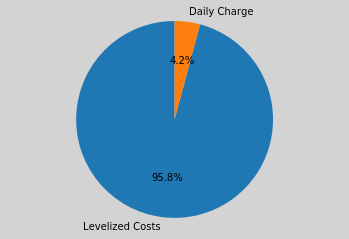

Total roof area of the  building: 599 m2
Total roof area used 588 m2
Percentage: 98.3%
succes
[[170.67108865882528, 244.35380264588625, 180.90587033561877, 2.900752762696747, 1.5405711168283704, 49.71173654516693, 0.7344496488327112, 0.25396750200351886, 0.5228138498490918, 3188.13, 307.593, 0.0, 0.0, 307.593, {'Levelized Costs': 3055.07, 'Energy Charge': 0.018000000000199634, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60039288228, 61845.7, 588.341]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (252.1576162843511, 194.6012976587244, 253.74729925786772, 34.04957593570622, 44.359153234856734, 37.307119756492035, 0.7337312138057246, 0.6773281368103762, 0.764615252372002)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 252
                                           a tilt of 34.0
                                           and a gcr of 0.734


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9694318771362305 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 44.4
                                           and a gcr of 0.677


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8675177097320557 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 254
                                           a tilt of 37.3
                                           and a gcr of 0.765


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.907041072845459 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 130 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 316.698, 0.0]


ERROR:ga_logger:Cost: 3278.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,279 per year


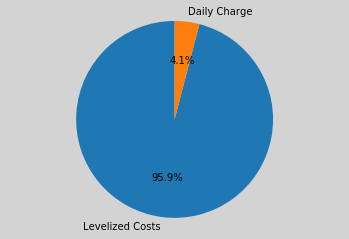

Total roof area of the  building: 599 m2
Total roof area used 468 m2
Percentage: 78.1%
succes
[[252.1576162843511, 194.6012976587244, 253.74729925786772, 34.04957593570622, 44.359153234856734, 37.307119756492035, 0.7337312138057246, 0.6773281368103762, 0.764615252372002, 3278.57, 316.698, 0.0, 316.698, 0.0, {'Levelized Costs': 3145.5170000000003, 'Energy Charge': 0.011000000000024102, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60119066673, 61845.7, 467.57]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (197.45858541095706, 128.64070656301735, 118.92406589400073, 45.25956285092342, 24.50646338239106, 11.259343032121405, 0.2550355027280537, 0.4359383109486217, 0.2935307385774415)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 197
                                           a tilt of 45.3
                                           and a gcr of 0.255


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0405466556549072 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 129
                                           a tilt of 24.5
                                           and a gcr of 0.436


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8398630619049072 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 119
                                           a tilt of 11.3
                                           and a gcr of 0.294


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.837651252746582 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 261.023, 0.0]


ERROR:ga_logger:Cost: 4017.83


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0209 /kWh
Total Cost of the system: $ 4,018 per year


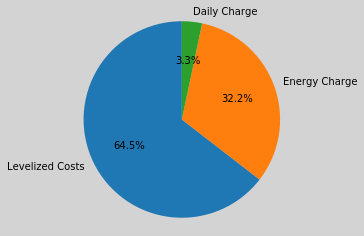

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[197.45858541095706, 128.64070656301735, 118.92406589400073, 45.25956285092342, 24.50646338239106, 11.259343032121405, 0.2550355027280537, 0.4359383109486217, 0.2935307385774415, 4017.83, 261.023, 0.0, 261.023, 0.0, {'Levelized Costs': 2592.5399999999995, 'Energy Charge': 1292.2480000000005, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 51532.47361467991, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (205.12089930367227, 256.467512837292, 244.6855326302921, 30.212832355892864, 34.63493165331536, 11.035395233929695, 0.8429983830786036, 0.6457216333744635, 0.6913736880516745)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 30.2
                                           and a gcr of 0.843


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9795610904693604 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 256
                                           a tilt of 34.6
                                           and a gcr of 0.646


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8391263484954834 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 11.0
                                           and a gcr of 0.691


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1637115478515625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [325.99, 0.0, 0.0]


ERROR:ga_logger:Cost: 3370.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,371 per year


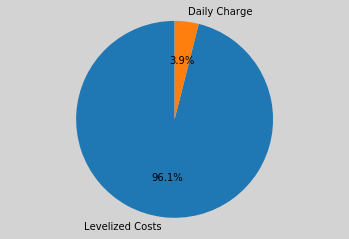

Total roof area of the  building: 599 m2
Total roof area used 387 m2
Percentage: 64.6%
succes
[[205.12089930367227, 256.467512837292, 244.6855326302921, 30.212832355892864, 34.63493165331536, 11.035395233929695, 0.8429983830786036, 0.6457216333744635, 0.6913736880516745, 3370.85, 325.99, 325.99, 0.0, 0.0, {'Levelized Costs': 3237.795, 'Energy Charge': 0.013000000000033651, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600205882234, 61845.7, 386.703]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (166.48215186633564, 230.16320678340534, 122.97452903289336, 4.8553830864843395, 14.8123730387133, 52.56692802052465, 0.3726857452888102, 0.785910070864408, 0.23426809136183505)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 166
                                           a tilt of 4.9
                                           and a gcr of 0.373


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.004765510559082 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 14.8
                                           and a gcr of 0.786


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1974573135375977 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 123
                                           a tilt of 52.6
                                           and a gcr of 0.234


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9722719192504883 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [130.364, 195.664, 0.0]


ERROR:ga_logger:Cost: 3371.23


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,371 per year


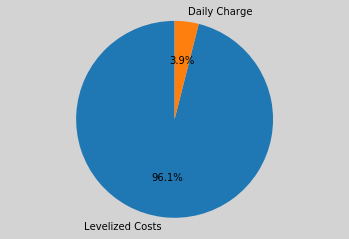

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[166.48215186633564, 230.16320678340534, 122.97452903289336, 4.8553830864843395, 14.8123730387133, 52.56692802052465, 0.3726857452888102, 0.785910070864408, 0.23426809136183505, 3371.23, 326.028, 130.364, 195.664, 0.0, {'Levelized Costs': 3238.1820000000002, 'Energy Charge': 0.0060000000000854925, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603166736124, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (208.5523952040159, 143.18310182649287, 139.94401929628737, 12.27125080207389, 28.565666859158203, 38.448836726555676, 0.5516408894789657, 0.7382296800996617, 0.6125505333770724)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 209
                                           a tilt of 12.3
                                           and a gcr of 0.552


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0587029457092285 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 143
                                           a tilt of 28.6
                                           and a gcr of 0.738


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8916659355163574 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 38.4
                                           and a gcr of 0.613


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.881413459777832 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [313.16, 0.0, 0.0]


ERROR:ga_logger:Cost: 3243.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,243 per year


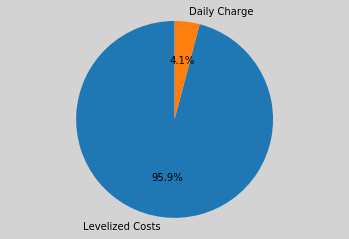

Total roof area of the  building: 599 m2
Total roof area used 568 m2
Percentage: 94.8%
succes
[[208.5523952040159, 143.18310182649287, 139.94401929628737, 12.27125080207389, 28.565666859158203, 38.448836726555676, 0.5516408894789657, 0.7382296800996617, 0.6125505333770724, 3243.42, 313.16, 313.16, 0.0, 0.0, {'Levelized Costs': 3110.361, 'Energy Charge': 0.017000000000280124, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59903923887, 61845.7, 567.688]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (205.78612359104483, 247.50786828538713, 150.02970668753753, 14.94997039453928, 8.9393033239292, 1.74425075301856, 0.2073135065675209, 0.3000041451889714, 0.48374350088633356)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 206
                                           a tilt of 14.9
                                           and a gcr of 0.207


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.441717147827148 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 248
                                           a tilt of 8.9
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.940378427505493 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 1.7
                                           and a gcr of 0.484


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7387020587921143 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 179.631, 0.0]


ERROR:ga_logger:Cost: 5448.04


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0571 /kWh
Total Cost of the system: $ 5,448 per year


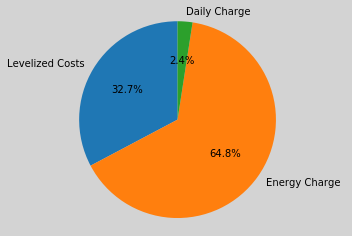

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[205.78612359104483, 247.50786828538713, 150.02970668753753, 14.94997039453928, 8.9393033239292, 1.74425075301856, 0.2073135065675209, 0.3000041451889714, 0.48374350088633356, 5448.04, 179.631, 0.0, 179.631, 0.0, {'Levelized Costs': 1784.1295999999998, 'Energy Charge': 3530.8684000000003, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 33666.394475643036, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (126.2017130761911, 149.67399871018725, 211.19332305415713, 43.34447439884377, 29.14593201828405, 10.961610810183162, 0.579080683184094, 0.7295962477561473, 0.6477814450886821)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 126
                                           a tilt of 43.3
                                           and a gcr of 0.579


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9691061973571777 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 29.1
                                           and a gcr of 0.730


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8870279788970947 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 211
                                           a tilt of 11.0
                                           and a gcr of 0.648


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.224724054336548 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 316.448]


ERROR:ga_logger:Cost: 3276.08


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,276 per year


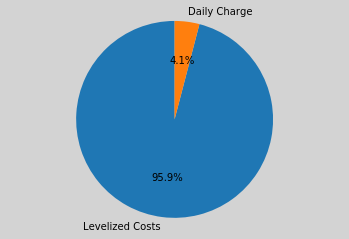

Total roof area of the  building: 599 m2
Total roof area used 489 m2
Percentage: 81.6%
succes
[[126.2017130761911, 149.67399871018725, 211.19332305415713, 43.34447439884377, 29.14593201828405, 10.961610810183162, 0.579080683184094, 0.7295962477561473, 0.6477814450886821, 3276.08, 316.448, 0.0, 0.0, 316.448, {'Levelized Costs': 3143.031, 'Energy Charge': 0.007000000000061846, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60218641851, 61845.7, 488.511]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (192.80683104066821, 231.0056103744832, 195.35078555218757, 53.34752573275263, 15.669296064112855, 3.8124075225216014, 0.35838117281344795, 0.4440973805237185, 0.44959801705321784)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 193
                                           a tilt of 53.3
                                           and a gcr of 0.358


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.99604868888855 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 231
                                           a tilt of 15.7
                                           and a gcr of 0.444


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.153395175933838 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 3.8
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.844127655029297 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 265.908, 0.0]


ERROR:ga_logger:Cost: 4058.72


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0208 /kWh
Total Cost of the system: $ 4,059 per year


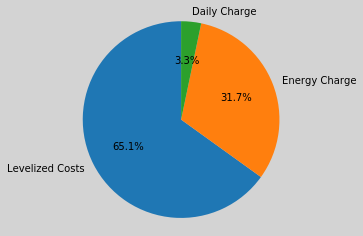

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[192.80683104066821, 231.0056103744832, 195.35078555218757, 53.34752573275263, 15.669296064112855, 3.8124075225216014, 0.35838117281344795, 0.4440973805237185, 0.44959801705321784, 4058.72, 265.908, 0.0, 265.908, 0.0, {'Levelized Costs': 2641.0599999999995, 'Energy Charge': 1284.6180000000004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 51593.36936247484, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (128.0424974721645, 176.14996567518176, 240.59464636339828, 55.49853958368621, 38.1954420285385, 52.40846901261534, 0.6013810474599973, 0.31757651480541776, 0.5932050820652014)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 128
                                           a tilt of 55.5
                                           and a gcr of 0.601


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0868263244628906 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 176
                                           a tilt of 38.2
                                           and a gcr of 0.318


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8708462715148926 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 241
                                           a tilt of 52.4
                                           and a gcr of 0.593


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.859081506729126 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [360.084, 0.0, 0.0]


ERROR:ga_logger:Cost: 3942.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0038 /kWh
Total Cost of the system: $ 3,943 per year


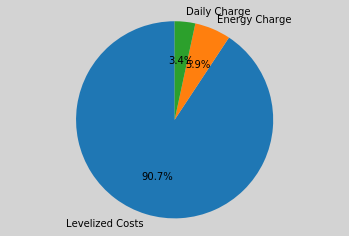

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[128.0424974721645, 176.14996567518176, 240.59464636339828, 55.49853958368621, 38.1954420285385, 52.40846901261534, 0.6013810474599973, 0.31757651480541776, 0.5932050820652014, 3942.85, 360.084, 360.084, 0.0, 0.0, {'Levelized Costs': 3576.4249999999997, 'Energy Charge': 233.3830000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 59983.092203809894, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (203.0718679929086, 236.5477105455598, 198.08569713161876, 7.455889346482793, 8.854039667087878, 15.510522181847714, 0.3320317433667399, 0.773293834288963, 0.2723599462667661)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 203
                                           a tilt of 7.5
                                           and a gcr of 0.332


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2582571506500244 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 237
                                           a tilt of 8.9
                                           and a gcr of 0.773


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.846588134765625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 198
                                           a tilt of 15.5
                                           and a gcr of 0.272


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9365038871765137 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 246.81, 76.1503]


ERROR:ga_logger:Cost: 3340.76


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,341 per year


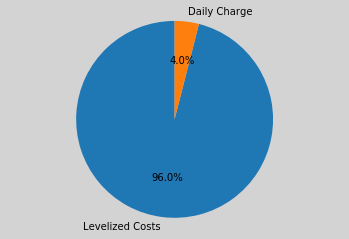

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[203.0718679929086, 236.5477105455598, 198.08569713161876, 7.455889346482793, 8.854039667087878, 15.510522181847714, 0.3320317433667399, 0.773293834288963, 0.2723599462667661, 3340.76, 322.9603, 0.0, 246.81, 76.1503, {'Levelized Costs': 3207.703, 'Energy Charge': 0.015000000000213731, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60303062492, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (184.86884378075996, 170.0751952917382, 149.5855220506274, 45.29513217718532, 55.51869306841401, 45.62585473136951, 0.5353704075322954, 0.7742003450543429, 0.7303543289697261)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 45.3
                                           and a gcr of 0.535


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4137299060821533 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 55.5
                                           and a gcr of 0.774


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2740142345428467 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 45.6
                                           and a gcr of 0.730


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.072626829147339 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [303.87, 0.0, 0.0]


ERROR:ga_logger:Cost: 3151.15


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,151 per year


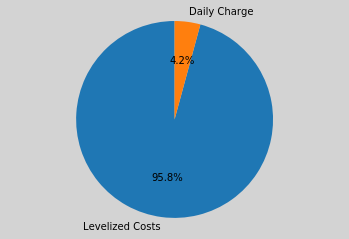

Total roof area of the  building: 599 m2
Total roof area used 568 m2
Percentage: 94.8%
succes
[[184.86884378075996, 170.0751952917382, 149.5855220506274, 45.29513217718532, 55.51869306841401, 45.62585473136951, 0.5353704075322954, 0.7742003450543429, 0.7303543289697261, 3151.15, 303.87, 303.87, 0.0, 0.0, {'Levelized Costs': 3018.0950000000003, 'Energy Charge': 0.013000000000090495, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600533308236, 61845.7, 567.588]]


ERROR:optimizer_logger:20


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (203.81784660895298, 244.35380264588625, 192.67332460269523, 32.12833658659867, 50.82166069663419, 52.04493490625003, 0.7344291831414165, 0.6109863621579341, 0.8529913256875027)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 204
                                           a tilt of 32.1
                                           and a gcr of 0.734


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.193734884262085 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 244
                                           a tilt of 50.8
                                           and a gcr of 0.611


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.619757652282715 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 193
                                           a tilt of 52.0
                                           and a gcr of 0.853


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.169024705886841 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [316.042, 0.0, 0.0]


ERROR:ga_logger:Cost: 3272.05


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,272 per year


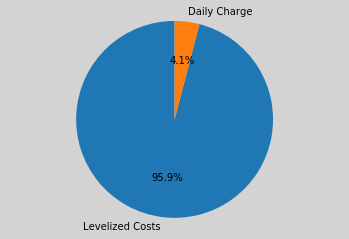

Total roof area of the  building: 599 m2
Total roof area used 430 m2
Percentage: 71.9%
succes
[[203.81784660895298, 244.35380264588625, 192.67332460269523, 32.12833658659867, 50.82166069663419, 52.04493490625003, 0.7344291831414165, 0.6109863621579341, 0.8529913256875027, 3272.05, 316.042, 316.042, 0.0, 0.0, {'Levelized Costs': 3138.9970000000003, 'Energy Charge': 0.011000000000024102, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599350381905, 61845.7, 430.323]]


The maximum power used is 16 kW


The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (188.5954194388025, 96.35578249748554, 126.01126212931882, 2.358255078629842, 1.04690812971383, 46.09859911806747, 0.38652872474528216, 0.33567725013320215, 0.5141303655045114)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 189
                                           a tilt of 2.4
                                           and a gcr of 0.387


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6702051162719727 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 96
                                           a tilt of 1.0
                                           and a gcr of 0.336


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4544639587402344 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 126
                                           a tilt of 46.1
                                           and a gcr of 0.514


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2042465209960938 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 307.842]


ERROR:ga_logger:Cost: 3987.56


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0129 /kWh
Total Cost of the system: $ 3,988 per year


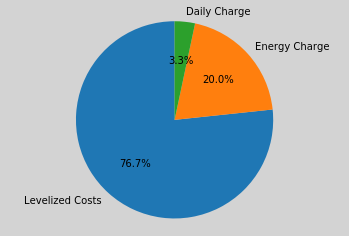

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[188.5954194388025, 96.35578249748554, 126.01126212931882, 2.358255078629842, 1.04690812971383, 46.09859911806747, 0.38652872474528216, 0.33567725013320215, 0.5141303655045114, 3987.56, 307.842, 0.0, 0.0, 307.842, {'Levelized Costs': 3057.543, 'Energy Charge': 796.9750000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 55485.19565195013, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (192.61801499312506, 197.1242094169142, 180.46431728947118, 45.96089852491365, 53.85348353886847, 43.053885431090514, 0.5353704075322954, 0.8002902665930957, 0.7441204040971237)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 193
                                           a tilt of 46.0
                                           and a gcr of 0.535


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.672555685043335 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 197
                                           a tilt of 53.9
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7851123809814453 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 43.1
                                           and a gcr of 0.744


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1734750270843506 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [307.856, 0.0, 0.0]


ERROR:ga_logger:Cost: 3190.74


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,191 per year


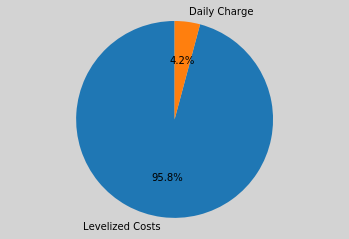

Total roof area of the  building: 599 m2
Total roof area used 575 m2
Percentage: 96.0%
succes
[[192.61801499312506, 197.1242094169142, 180.46431728947118, 45.96089852491365, 53.85348353886847, 43.053885431090514, 0.5353704075322954, 0.8002902665930957, 0.7441204040971237, 3190.74, 307.856, 307.856, 0.0, 0.0, {'Levelized Costs': 3057.68, 'Energy Charge': 0.018000000000029104, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60291633786, 61845.7, 575.033]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (144.79359469493423, 166.61762473824757, 148.2550073730544, 34.27967901282156, 25.410660182799234, 35.29575958836327, 0.22289678730591572, 0.46318747827145224, 0.6622475501749762)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 34.3
                                           and a gcr of 0.223


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.343890428543091 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 167
                                           a tilt of 25.4
                                           and a gcr of 0.463


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2045185565948486 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 148
                                           a tilt of 35.3
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.234456777572632 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 219.96, 82.0386]


ERROR:ga_logger:Cost: 3132.56


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,133 per year


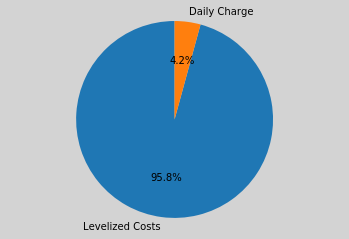

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[144.79359469493423, 166.61762473824757, 148.2550073730544, 34.27967901282156, 25.410660182799234, 35.29575958836327, 0.22289678730591572, 0.46318747827145224, 0.6622475501749762, 3132.56, 301.9986, 0.0, 219.96, 82.0386, {'Levelized Costs': 2999.5119999999993, 'Energy Charge': 0.00600000000054024, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60159872483, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (145.64461348599136, 233.17196721058266, 243.85569623122058, 49.71082608565484, 39.28894361424435, 52.96856808950808, 0.5847050126878741, 0.5669330920310325, 0.6546468121246668)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 146
                                           a tilt of 49.7
                                           and a gcr of 0.585


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.365126132965088 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 233
                                           a tilt of 39.3
                                           and a gcr of 0.567


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.214177370071411 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 244
                                           a tilt of 53.0
                                           and a gcr of 0.655


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.168102264404297 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [332.598, 0.0, 0.0]


ERROR:ga_logger:Cost: 3436.49


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,436 per year


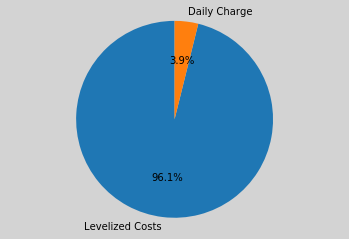

Total roof area of the  building: 599 m2
Total roof area used 569 m2
Percentage: 95.0%
succes
[[145.64461348599136, 233.17196721058266, 243.85569623122058, 49.71082608565484, 39.28894361424435, 52.96856808950808, 0.5847050126878741, 0.5669330920310325, 0.6546468121246668, 3436.49, 332.598, 332.598, 0.0, 0.0, {'Levelized Costs': 3303.4359999999997, 'Energy Charge': 0.012000000000170985, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59994601009, 61845.7, 568.831]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (128.01654151112646, 166.16155336617126, 191.44875888202364, 29.84588055177778, 7.956071752597102, 22.146532765689848, 0.24123908351978746, 0.3231293427911055, 0.7230288279391607)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 128
                                           a tilt of 29.8
                                           and a gcr of 0.241


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.339892864227295 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 166
                                           a tilt of 8.0
                                           and a gcr of 0.323


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.189479112625122 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 191
                                           a tilt of 22.1
                                           and a gcr of 0.723


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.183938503265381 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 306.462]


ERROR:ga_logger:Cost: 3176.9


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,177 per year


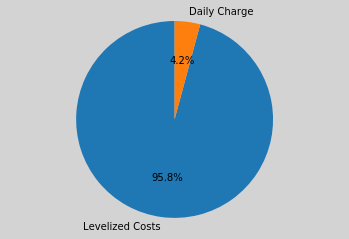

Total roof area of the  building: 599 m2
Total roof area used 424 m2
Percentage: 70.8%
succes
[[128.01654151112646, 166.16155336617126, 191.44875888202364, 29.84588055177778, 7.956071752597102, 22.146532765689848, 0.24123908351978746, 0.3231293427911055, 0.7230288279391607, 3176.9, 306.462, 0.0, 0.0, 306.462, {'Levelized Costs': 3043.852, 'Energy Charge': 0.006000000000142336, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6004530593, 61845.7, 423.859]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (243.01600824758265, 169.03326744670755, 213.80536568132166, 42.70670526359168, 40.1840864061255, 19.383490217657194, 0.6748466652401336, 0.8995806188565085, 0.7692052945724202)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 243
                                           a tilt of 42.7
                                           and a gcr of 0.675


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.38482928276062 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 169
                                           a tilt of 40.2
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1983225345611572 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 214
                                           a tilt of 19.4
                                           and a gcr of 0.769


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2593908309936523 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 319.238]


ERROR:ga_logger:Cost: 3303.79


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,304 per year


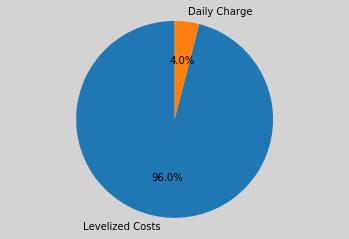

Total roof area of the  building: 599 m2
Total roof area used 415 m2
Percentage: 69.3%
succes
[[243.01600824758265, 169.03326744670755, 213.80536568132166, 42.70670526359168, 40.1840864061255, 19.383490217657194, 0.6748466652401336, 0.8995806188565085, 0.7692052945724202, 3303.79, 319.238, 0.0, 0.0, 319.238, {'Levelized Costs': 3170.732, 'Energy Charge': 0.016000000000019554, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60008417634, 61845.7, 415.023]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (189.0713265679068, 150.40391728534797, 172.28715541598197, 24.258144754482007, 23.874894565727814, 1.4901060789827798, 0.3359842032239946, 0.26190027135825483, 0.6027334733095778)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 189
                                           a tilt of 24.3
                                           and a gcr of 0.336


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6862826347351074 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 23.9
                                           and a gcr of 0.262


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.200291395187378 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 172
                                           a tilt of 1.5
                                           and a gcr of 0.603


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.157200574874878 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [43.4961, 0.0, 282.865]


ERROR:ga_logger:Cost: 3374.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,375 per year


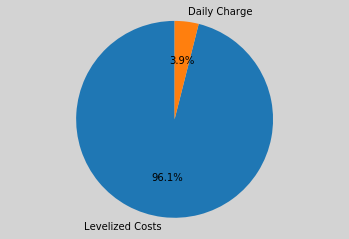

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[189.0713265679068, 150.40391728534797, 172.28715541598197, 24.258144754482007, 23.874894565727814, 1.4901060789827798, 0.3359842032239946, 0.26190027135825483, 0.6027334733095778, 3374.54, 326.3611, 43.4961, 0.0, 282.865, {'Levelized Costs': 3241.484, 'Energy Charge': 0.014000000000351065, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60481333715, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (127.2844369102293, 210.52410755300627, 213.407910357447, 35.21374210438165, 25.879009072304278, 22.28836208693566, 0.6659952500266902, 0.805419706755302, 0.6952929626512536)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 127
                                           a tilt of 35.2
                                           and a gcr of 0.666


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.461132287979126 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 211
                                           a tilt of 25.9
                                           and a gcr of 0.805


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.243528366088867 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 213
                                           a tilt of 22.3
                                           and a gcr of 0.695


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3439600467681885 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 314.676]


ERROR:ga_logger:Cost: 3258.48


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,258 per year


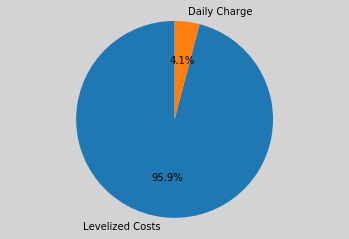

Total roof area of the  building: 599 m2
Total roof area used 453 m2
Percentage: 75.6%
succes
[[127.2844369102293, 210.52410755300627, 213.407910357447, 35.21374210438165, 25.879009072304278, 22.28836208693566, 0.6659952500266902, 0.805419706755302, 0.6952929626512536, 3258.48, 314.676, 0.0, 0.0, 314.676, {'Levelized Costs': 3125.4219999999996, 'Energy Charge': 0.016000000000360615, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60155924829, 61845.7, 452.58]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (126.2017130761911, 149.67399871018725, 190.5955538945455, 40.83120194070723, 5.755857173202088, 12.129516202177111, 0.25529223066553175, 0.5494230098972699, 0.6251653468108329)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 126
                                           a tilt of 40.8
                                           and a gcr of 0.255


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4095051288604736 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 5.8
                                           and a gcr of 0.549


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1731858253479004 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 191
                                           a tilt of 12.1
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8241355419158936 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 310.186]


ERROR:ga_logger:Cost: 3213.89


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,214 per year


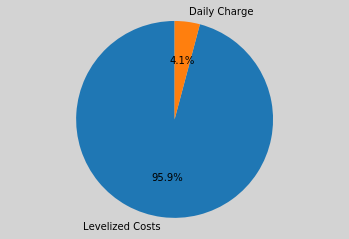

Total roof area of the  building: 599 m2
Total roof area used 496 m2
Percentage: 82.9%
succes
[[126.2017130761911, 149.67399871018725, 190.5955538945455, 40.83120194070723, 5.755857173202088, 12.129516202177111, 0.25529223066553175, 0.5494230098972699, 0.6251653468108329, 3213.89, 310.186, 0.0, 0.0, 310.186, {'Levelized Costs': 3080.846, 'Energy Charge': 0.001999999999895863, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60024473979, 61845.7, 496.167]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (243.01600824758265, 227.4890724230715, 211.50351951433043, 43.91132678229961, 41.44866300257319, 2.2132836941982807, 0.5795111877281802, 0.8919849556223165, 0.6423589542262288)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 243
                                           a tilt of 43.9
                                           and a gcr of 0.580


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.058996915817261 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 227
                                           a tilt of 41.4
                                           and a gcr of 0.892


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5151941776275635 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 212
                                           a tilt of 2.2
                                           and a gcr of 0.642


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.059981346130371 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 331.064]


ERROR:ga_logger:Cost: 3421.25


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,421 per year


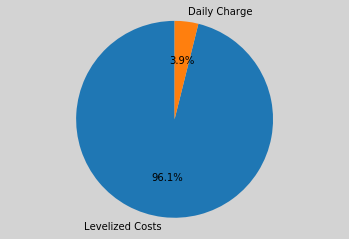

Total roof area of the  building: 599 m2
Total roof area used 515 m2
Percentage: 86.1%
succes
[[243.01600824758265, 227.4890724230715, 211.50351951433043, 43.91132678229961, 41.44866300257319, 2.2132836941982807, 0.5795111877281802, 0.8919849556223165, 0.6423589542262288, 3421.25, 331.064, 0.0, 0.0, 331.064, {'Levelized Costs': 3288.1910000000003, 'Energy Charge': 0.01699999999971169, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602720625895, 61845.7, 515.388]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (106.22263095379832, 149.67399871018725, 173.16083501885424, 42.744291709714666, 28.03968947633112, 11.993495439381235, 0.579080683184094, 0.7380719551264393, 0.5511009630501493)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 106
                                           a tilt of 42.7
                                           and a gcr of 0.579


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6611082553863525 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 28.0
                                           and a gcr of 0.738


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.227069139480591 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 173
                                           a tilt of 12.0
                                           and a gcr of 0.551


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2542366981506348 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 309.233]


ERROR:ga_logger:Cost: 3204.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,204 per year


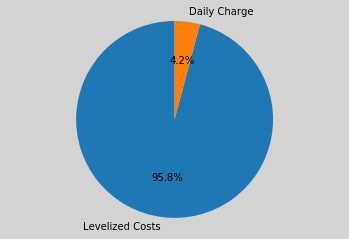

Total roof area of the  building: 599 m2
Total roof area used 561 m2
Percentage: 93.7%
succes
[[106.22263095379832, 149.67399871018725, 173.16083501885424, 42.744291709714666, 28.03968947633112, 11.993495439381235, 0.579080683184094, 0.7380719551264393, 0.5511009630501493, 3204.42, 309.233, 0.0, 0.0, 309.233, {'Levelized Costs': 3071.371, 'Energy Charge': 0.006999999999948159, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6032658332, 61845.7, 561.119]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (213.3870228135429, 238.85885170472983, 197.66325847735303, 34.33797073989319, 26.80675754178056, 43.26533058747028, 0.3335273494823012, 0.7994897379533356, 0.624720301861766)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 213
                                           a tilt of 34.3
                                           and a gcr of 0.334


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5501136779785156 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 239
                                           a tilt of 26.8
                                           and a gcr of 0.799


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1634318828582764 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 198
                                           a tilt of 43.3
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2803964614868164 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [72.2554, 0.0, 238.719]


ERROR:ga_logger:Cost: 3221.72


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,222 per year


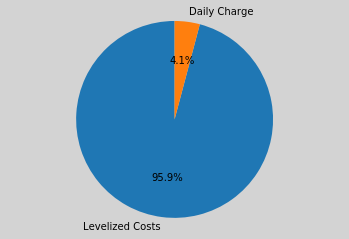

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[213.3870228135429, 238.85885170472983, 197.66325847735303, 34.33797073989319, 26.80675754178056, 43.26533058747028, 0.3335273494823012, 0.7994897379533356, 0.624720301861766, 3221.72, 310.9744, 72.2554, 0.0, 238.719, {'Levelized Costs': 3088.668, 'Energy Charge': 0.009999999999820375, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6004080559, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (132.03299393249978, 191.6144034500298, 172.34220585393535, 7.455889346482793, 7.136994519308244, 14.785535170400143, 0.20694025949130923, 0.36965806232106374, 0.29664513203654425)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 132
                                           a tilt of 7.5
                                           and a gcr of 0.207


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4409267902374268 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 7.1
                                           and a gcr of 0.370


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.666815996170044 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 172
                                           a tilt of 14.8
                                           and a gcr of 0.297


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2490148544311523 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 131 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 221.337, 0.0]


ERROR:ga_logger:Cost: 4690.8


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0381 /kWh
Total Cost of the system: $ 4,691 per year


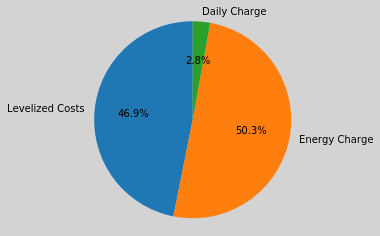

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[132.03299393249978, 191.6144034500298, 172.34220585393535, 7.455889346482793, 7.136994519308244, 14.785535170400143, 0.20694025949130923, 0.36965806232106374, 0.29664513203654425, 4690.8, 221.337, 0.0, 221.337, 0.0, {'Levelized Costs': 2198.3629, 'Energy Charge': 2359.3951, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 43015.74427888792, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (167.4236787773369, 244.35380264588625, 176.7662686714141, 41.83511198227674, 49.60156718642798, 51.0508682714633, 0.7849241155640787, 0.7735699600591436, 0.731657048786384)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 41.8
                                           and a gcr of 0.785


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5715439319610596 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 244
                                           a tilt of 49.6
                                           and a gcr of 0.774


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.252229928970337 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 177
                                           a tilt of 51.1
                                           and a gcr of 0.732


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2502152919769287 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [322.986, 0.0, 0.0]


ERROR:ga_logger:Cost: 3341.01


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,341 per year


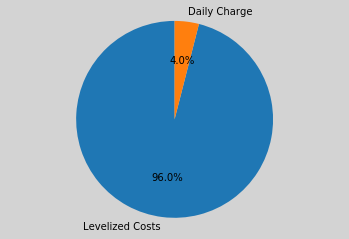

Total roof area of the  building: 599 m2
Total roof area used 411 m2
Percentage: 68.7%
succes
[[167.4236787773369, 244.35380264588625, 176.7662686714141, 41.83511198227674, 49.60156718642798, 51.0508682714633, 0.7849241155640787, 0.7735699600591436, 0.731657048786384, 3341.01, 322.986, 322.986, 0.0, 0.0, {'Levelized Costs': 3207.952, 'Energy Charge': 0.01599999999996271, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60081359996, 61845.7, 411.486]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (182.63934297205057, 170.0751952917382, 172.69587221841974, 8.077423640074853, 1.1783524729023256, 54.51516547927907, 0.5353704075322954, 0.23682086848310688, 0.5552645723653999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 183
                                           a tilt of 8.1
                                           and a gcr of 0.535


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6043994426727295 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 1.2
                                           and a gcr of 0.237


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6039175987243652 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 173
                                           a tilt of 54.5
                                           and a gcr of 0.555


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.166807174682617 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [315.841, 0.0, 0.0]


ERROR:ga_logger:Cost: 3270.05


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,270 per year


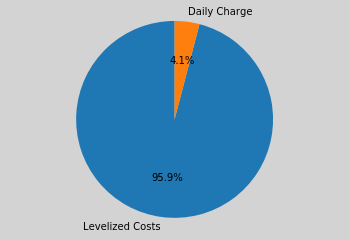

Total roof area of the  building: 599 m2
Total roof area used 590 m2
Percentage: 98.5%
succes
[[182.63934297205057, 170.0751952917382, 172.69587221841974, 8.077423640074853, 1.1783524729023256, 54.51516547927907, 0.5353704075322954, 0.23682086848310688, 0.5552645723653999, 3270.05, 315.841, 315.841, 0.0, 0.0, {'Levelized Costs': 3136.989, 'Energy Charge': 0.019000000000460204, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600795007274, 61845.7, 589.948]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (211.675340762459, 244.3564652085179, 213.77814965306837, 7.383099952213518, 14.8123730387133, 52.56692802052465, 0.5212352879499309, 0.8703374361089613, 0.2730983660140981)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 212
                                           a tilt of 7.4
                                           and a gcr of 0.521


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.242477178573608 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 244
                                           a tilt of 14.8
                                           and a gcr of 0.870


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5155746936798096 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 214
                                           a tilt of 52.6
                                           and a gcr of 0.273


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2453904151916504 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [296.134, 26.6519, 0.0]


ERROR:ga_logger:Cost: 3339.03


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,339 per year


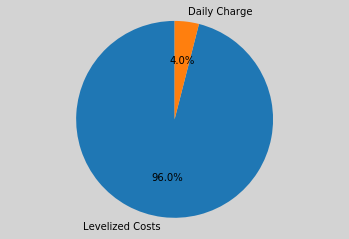

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[211.675340762459, 244.3564652085179, 213.77814965306837, 7.383099952213518, 14.8123730387133, 52.56692802052465, 0.5212352879499309, 0.8703374361089613, 0.2730983660140981, 3339.03, 322.7859, 296.134, 26.6519, 0.0, {'Levelized Costs': 3205.978, 'Energy Charge': 0.010000000000104592, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60156688233, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (163.75005916555486, 228.78773263783907, 138.6692257439983, 2.224194287127065, 8.854039667087878, 15.657828626846172, 0.3201740257815781, 0.8147457663882451, 0.2335296717309117)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 164
                                           a tilt of 2.2
                                           and a gcr of 0.320


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3525900840759277 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 229
                                           a tilt of 8.9
                                           and a gcr of 0.815


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3443000316619873 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 139
                                           a tilt of 15.7
                                           and a gcr of 0.234


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.131978988647461 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 257.533, 66.0122]


ERROR:ga_logger:Cost: 3346.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,347 per year


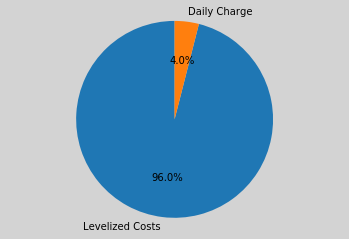

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[163.75005916555486, 228.78773263783907, 138.6692257439983, 2.224194287127065, 8.854039667087878, 15.657828626846172, 0.3201740257815781, 0.8147457663882451, 0.2335296717309117, 3346.57, 323.5452, 0.0, 257.533, 66.0122, {'Levelized Costs': 3213.5040000000004, 'Energy Charge': 0.024000000000114596, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60183872728, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (196.76094705200705, 264.42030312296794, 248.21441019091225, 30.236215531893983, 38.872093635501614, 45.84086264057969, 0.8879148587475472, 0.6449559256456203, 0.845106425851508)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 197
                                           a tilt of 30.2
                                           and a gcr of 0.888


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.395910263061523 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 38.9
                                           and a gcr of 0.645


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.381977081298828 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 248
                                           a tilt of 45.8
                                           and a gcr of 0.845


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.175062417984009 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [324.89, 0.0, 0.0]


ERROR:ga_logger:Cost: 3359.93


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,360 per year


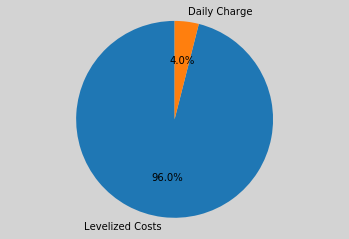

Total roof area of the  building: 599 m2
Total roof area used 366 m2
Percentage: 61.1%
succes
[[196.76094705200705, 264.42030312296794, 248.21441019091225, 30.236215531893983, 38.872093635501614, 45.84086264057969, 0.8879148587475472, 0.6449559256456203, 0.845106425851508, 3359.93, 324.89, 324.89, 0.0, 0.0, {'Levelized Costs': 3226.8729999999996, 'Energy Charge': 0.015000000000213731, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60047315739, 61845.7, 365.902]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (192.48108618189124, 90.10120295614539, 115.43673876246592, 30.212832355892864, 34.63493165331536, 9.506078489976428, 0.4020071787210836, 0.48097510686664846, 0.689173060394511)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 192
                                           a tilt of 30.2
                                           and a gcr of 0.402


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5835537910461426 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 34.6
                                           and a gcr of 0.481


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2064621448516846 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 9.5
                                           and a gcr of 0.689


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.15177321434021 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [141.282, 0.0, 170.447]


ERROR:ga_logger:Cost: 3229.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,229 per year


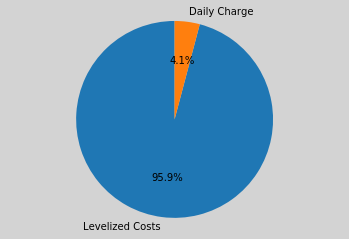

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[192.48108618189124, 90.10120295614539, 115.43673876246592, 30.212832355892864, 34.63493165331536, 9.506078489976428, 0.4020071787210836, 0.48097510686664846, 0.689173060394511, 3229.21, 311.72900000000004, 141.282, 0.0, 170.447, {'Levelized Costs': 3096.157, 'Energy Charge': 0.011000000000137788, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60240132519, 61845.7, 598.762]]


ERROR:optimizer_logger:40


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (144.4043028054962, 166.17146952553722, 204.8287873218161, 37.288146741301205, 26.78191019823004, 34.56317968917783, 0.2469740311733722, 0.5416997242558613, 0.837266188347519)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 144
                                           a tilt of 37.3
                                           and a gcr of 0.247


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.63527250289917 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 166
                                           a tilt of 26.8
                                           and a gcr of 0.542


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.159437894821167 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 34.6
                                           and a gcr of 0.837


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1747546195983887 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 298.657, 0.0]


ERROR:ga_logger:Cost: 3099.38


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,099 per year


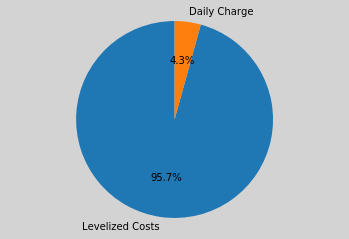

Total roof area of the  building: 599 m2
Total roof area used 551 m2
Percentage: 92.1%
succes
[[144.4043028054962, 166.17146952553722, 204.8287873218161, 37.288146741301205, 26.78191019823004, 34.56317968917783, 0.2469740311733722, 0.5416997242558613, 0.837266188347519, 3099.38, 298.657, 0.0, 298.657, 0.0, {'Levelized Costs': 2966.321, 'Energy Charge': 0.017000000000166438, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60267889983, 61845.7, 551.333]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (128.01654151112646, 163.13225306797935, 131.8842221705941, 29.84588055177778, 13.929395912898862, 18.894871584755155, 0.2410179811076942, 0.26998588922182243, 0.7230288279391607)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 128
                                           a tilt of 29.8
                                           and a gcr of 0.241


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6800451278686523 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 163
                                           a tilt of 13.9
                                           and a gcr of 0.270


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.286536693572998 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 132
                                           a tilt of 18.9
                                           and a gcr of 0.723


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3366596698760986 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 67.8853, 251.123]


ERROR:ga_logger:Cost: 3301.51


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,302 per year


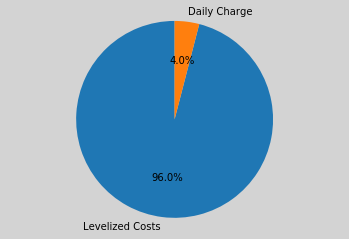

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[128.01654151112646, 163.13225306797935, 131.8842221705941, 29.84588055177778, 13.929395912898862, 18.894871584755155, 0.2410179811076942, 0.26998588922182243, 0.7230288279391607, 3301.51, 319.00829999999996, 0.0, 67.8853, 251.123, {'Levelized Costs': 3168.45, 'Energy Charge': 0.01800000000031332, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60057528405, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (212.12337186442912, 226.98086447245365, 233.5555545901792, 35.191910464601015, 39.65104710270544, 42.2779094160477, 0.4409933180434676, 0.8585696231705741, 0.8026024267896057)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 212
                                           a tilt of 35.2
                                           and a gcr of 0.441


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5283148288726807 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 227
                                           a tilt of 39.7
                                           and a gcr of 0.859


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1928043365478516 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 234
                                           a tilt of 42.3
                                           and a gcr of 0.803


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3878960609436035 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [197.778, 129.025, 0.0]


ERROR:ga_logger:Cost: 3378.93


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,379 per year


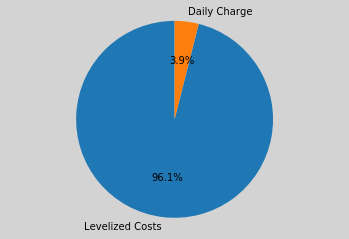

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[212.12337186442912, 226.98086447245365, 233.5555545901792, 35.191910464601015, 39.65104710270544, 42.2779094160477, 0.4409933180434676, 0.8585696231705741, 0.8026024267896057, 3378.93, 326.803, 197.778, 129.025, 0.0, {'Levelized Costs': 3245.872, 'Energy Charge': 0.016000000000076398, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60292617536, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (186.50753072171034, 160.30767497809953, 226.24646495334932, 27.716835172469075, 22.44623928070562, 16.28344314534774, 0.3335273494823012, 0.2071795374709983, 0.5591367924162205)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 187
                                           a tilt of 27.7
                                           and a gcr of 0.334


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5272676944732666 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 22.4
                                           and a gcr of 0.207


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2665388584136963 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 226
                                           a tilt of 16.3
                                           and a gcr of 0.559


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2523553371429443 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [29.4502, 0.0, 285.418]


ERROR:ga_logger:Cost: 3260.39


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,260 per year


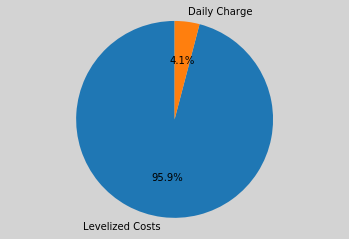

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[186.50753072171034, 160.30767497809953, 226.24646495334932, 27.716835172469075, 22.44623928070562, 16.28344314534774, 0.3335273494823012, 0.2071795374709983, 0.5591367924162205, 3260.39, 314.8682, 29.4502, 0.0, 285.418, {'Levelized Costs': 3127.345, 'Energy Charge': 0.00300000000027012, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59989793502, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (147.02746272027366, 184.17996567297706, 157.28082863451675, 33.96676844293922, 30.86484055296659, 35.32228471423498, 0.20959304317098992, 0.46318747827145224, 0.6961066251958289)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 147
                                           a tilt of 34.0
                                           and a gcr of 0.210


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.554049253463745 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 184
                                           a tilt of 30.9
                                           and a gcr of 0.463


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1525232791900635 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 157
                                           a tilt of 35.3
                                           and a gcr of 0.696


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.140425682067871 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 236.58, 61.2545]


ERROR:ga_logger:Cost: 3091.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,091 per year


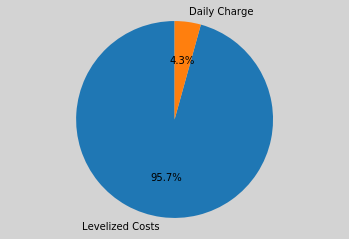

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[147.02746272027366, 184.17996567297706, 157.28082863451675, 33.96676844293922, 30.86484055296659, 35.32228471423498, 0.20959304317098992, 0.46318747827145224, 0.6961066251958289, 3091.21, 297.8345, 0.0, 236.58, 61.2545, {'Levelized Costs': 2958.1519999999996, 'Energy Charge': 0.0160000000004743, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59845229616, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (137.16983091302038, 156.13470465788964, 144.81378593792238, 33.808014964319646, 25.410660182799234, 32.643616808763454, 0.2431817176067227, 0.46318747827145224, 0.6248396033288047)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 137
                                           a tilt of 33.8
                                           and a gcr of 0.243


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8036324977874756 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 156
                                           a tilt of 25.4
                                           and a gcr of 0.463


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5626463890075684 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 32.6
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4936161041259766 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 199.308, 105.263]


ERROR:ga_logger:Cost: 3158.12


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,158 per year


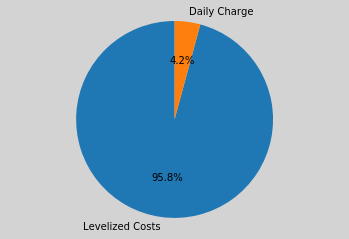

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[137.16983091302038, 156.13470465788964, 144.81378593792238, 33.808014964319646, 25.410660182799234, 32.643616808763454, 0.2431817176067227, 0.46318747827145224, 0.6248396033288047, 3158.12, 304.571, 0.0, 199.308, 105.263, {'Levelized Costs': 3025.063, 'Energy Charge': 0.015000000000043201, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601466409935, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (189.42786726039847, 190.57447390387387, 226.1811293031191, 21.43041275275062, 39.65338706747522, 32.891706389707814, 0.38882453310918663, 0.41326131427352664, 0.7954591870148748)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 189
                                           a tilt of 21.4
                                           and a gcr of 0.389


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6359035968780518 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 191
                                           a tilt of 39.7
                                           and a gcr of 0.413


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1780669689178467 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 226
                                           a tilt of 32.9
                                           and a gcr of 0.795


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2385058403015137 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 173.332, 142.654]


ERROR:ga_logger:Cost: 3271.5


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,272 per year


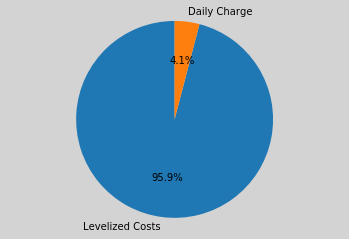

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[189.42786726039847, 190.57447390387387, 226.1811293031191, 21.43041275275062, 39.65338706747522, 32.891706389707814, 0.38882453310918663, 0.41326131427352664, 0.7954591870148748, 3271.5, 315.986, 0.0, 173.332, 142.654, {'Levelized Costs': 3138.451, 'Energy Charge': 0.007000000000061846, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60177240875, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (139.92009649279817, 137.4040940823977, 171.91976719966982, 34.096220542141694, 26.80675754178056, 15.307665418607694, 0.2079131295948468, 0.2293755348759477, 0.6270904035342687)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 34.1
                                           and a gcr of 0.208


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5523946285247803 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 137
                                           a tilt of 26.8
                                           and a gcr of 0.229


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3770837783813477 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 172
                                           a tilt of 15.3
                                           and a gcr of 0.627


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.111631393432617 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [34.6285, 0.0, 271.034]


ERROR:ga_logger:Cost: 3168.96


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,169 per year


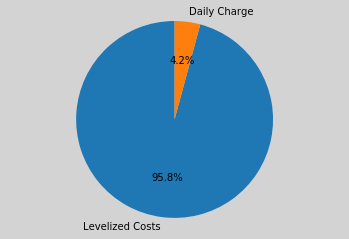

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[139.92009649279817, 137.4040940823977, 171.91976719966982, 34.096220542141694, 26.80675754178056, 15.307665418607694, 0.2079131295948468, 0.2293755348759477, 0.6270904035342687, 3168.96, 305.6625, 34.6285, 0.0, 271.034, {'Levelized Costs': 3035.894, 'Energy Charge': 0.024000000000455657, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60270198489, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (136.76777770504702, 180.44112249424967, 175.7500357616827, 45.00595680705575, 26.80675754178056, 30.41477158668345, 0.3108952893238453, 0.5330897914642528, 0.6251552344297876)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 137
                                           a tilt of 45.0
                                           and a gcr of 0.311


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.732069969177246 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 26.8
                                           and a gcr of 0.533


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.26921010017395 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 176
                                           a tilt of 30.4
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2549047470092773 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 295.54, 0.0]


ERROR:ga_logger:Cost: 3068.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,068 per year


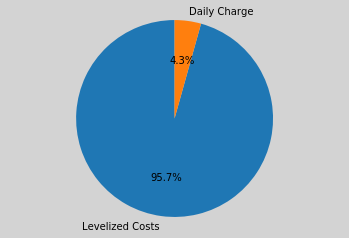

Total roof area of the  building: 599 m2
Total roof area used 554 m2
Percentage: 92.6%
succes
[[136.76777770504702, 180.44112249424967, 175.7500357616827, 45.00595680705575, 26.80675754178056, 30.41477158668345, 0.3108952893238453, 0.5330897914642528, 0.6251552344297876, 3068.42, 295.54, 0.0, 295.54, 0.0, {'Levelized Costs': 2935.369, 'Energy Charge': 0.009000000000128239, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60127451265, 61845.7, 554.391]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (126.2017130761911, 149.67399871018725, 166.64172078627843, 26.872588544444813, 4.86884324241596, 13.181041034546844, 0.2548056558075704, 0.5003342672391256, 0.6233765295187174)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 126
                                           a tilt of 26.9
                                           and a gcr of 0.255


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5003726482391357 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 4.9
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.11173152923584 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 167
                                           a tilt of 13.2
                                           and a gcr of 0.623


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.105618476867676 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 309.067]


ERROR:ga_logger:Cost: 3202.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,203 per year


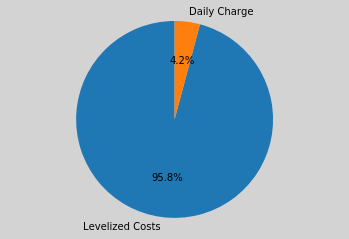

Total roof area of the  building: 599 m2
Total roof area used 496 m2
Percentage: 82.8%
succes
[[126.2017130761911, 149.67399871018725, 166.64172078627843, 26.872588544444813, 4.86884324241596, 13.181041034546844, 0.2548056558075704, 0.5003342672391256, 0.6233765295187174, 3202.77, 309.067, 0.0, 0.0, 309.067, {'Levelized Costs': 3069.715, 'Energy Charge': 0.013000000000090495, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60105517051, 61845.7, 495.795]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (144.21803196113248, 209.56013666029386, 177.79544044113314, 37.93913576509673, 30.010749032963577, 36.88242934072628, 0.2079131295948468, 0.46318747827145224, 0.6283723712413587)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 144
                                           a tilt of 37.9
                                           and a gcr of 0.208


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5181660652160645 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 30.0
                                           and a gcr of 0.463


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1305205821990967 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 36.9
                                           and a gcr of 0.628


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.21990704536438 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [36.363, 0.0, 266.346]


ERROR:ga_logger:Cost: 3139.62


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,140 per year


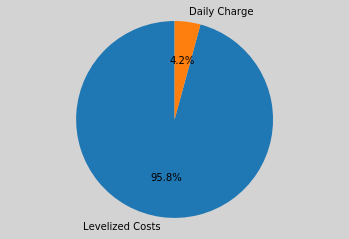

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[144.21803196113248, 209.56013666029386, 177.79544044113314, 37.93913576509673, 30.010749032963577, 36.88242934072628, 0.2079131295948468, 0.46318747827145224, 0.6283723712413587, 3139.62, 302.709, 36.363, 0.0, 266.346, {'Levelized Costs': 3006.5589999999997, 'Energy Charge': 0.01900000000023283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59921964291, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (131.57912360720502, 188.94367129482177, 166.21680619657366, 34.277151427257024, 26.386235664368556, 35.29575958836327, 0.2011866139107112, 0.46318747827145224, 0.624720301861766)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 132
                                           a tilt of 34.3
                                           and a gcr of 0.201


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.530205011367798 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 189
                                           a tilt of 26.4
                                           and a gcr of 0.463


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.191101551055908 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 166
                                           a tilt of 35.3
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1996774673461914 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 217.88, 80.1952]


ERROR:ga_logger:Cost: 3093.6


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,094 per year


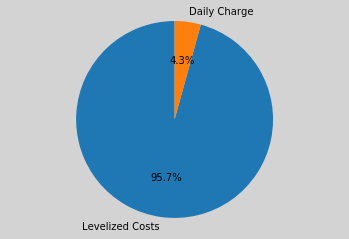

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[131.57912360720502, 188.94367129482177, 166.21680619657366, 34.277151427257024, 26.386235664368556, 35.29575958836327, 0.2011866139107112, 0.46318747827145224, 0.624720301861766, 3093.6, 298.0752, 0.0, 217.88, 80.1952, {'Levelized Costs': 2960.538, 'Energy Charge': 0.020000000000209184, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60008660602, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (213.96765373532665, 224.3498558993425, 197.8073494536299, 40.514032448819954, 32.382782161453854, 43.38906866378905, 0.31609424858026614, 0.7994897379533356, 0.624720301861766)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 214
                                           a tilt of 40.5
                                           and a gcr of 0.316


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.681657552719116 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 224
                                           a tilt of 32.4
                                           and a gcr of 0.799


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.30539870262146 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 198
                                           a tilt of 43.4
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.318690538406372 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [63.4569, 0.0, 248.644]


ERROR:ga_logger:Cost: 3232.91


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,233 per year


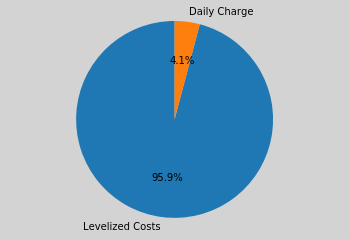

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[213.96765373532665, 224.3498558993425, 197.8073494536299, 40.514032448819954, 32.382782161453854, 43.38906866378905, 0.31609424858026614, 0.7994897379533356, 0.624720301861766, 3232.91, 312.1009, 63.4569, 0.0, 248.644, {'Levelized Costs': 3099.852, 'Energy Charge': 0.01599999999996271, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60405666093, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (208.5523952040159, 150.01309502692487, 139.94401929628737, 12.27125080207389, 26.753081261307496, 40.26525402215077, 0.5088394287408782, 0.7382296800996617, 0.5859292730930568)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 209
                                           a tilt of 12.3
                                           and a gcr of 0.509


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.865363836288452 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 26.8
                                           and a gcr of 0.738


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.298647403717041 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 40.3
                                           and a gcr of 0.586


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.529386043548584 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [285.807, 27.3723, 0.0]


ERROR:ga_logger:Cost: 3243.61


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,244 per year


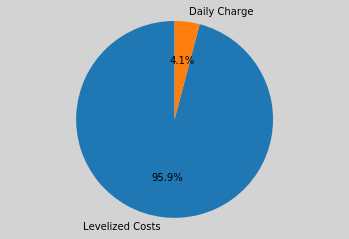

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[208.5523952040159, 150.01309502692487, 139.94401929628737, 12.27125080207389, 26.753081261307496, 40.26525402215077, 0.5088394287408782, 0.7382296800996617, 0.5859292730930568, 3243.61, 313.1793, 285.807, 27.3723, 0.0, {'Levelized Costs': 3110.5540000000005, 'Energy Charge': 0.013999999999896318, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60319462786, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (213.3870228135429, 228.07834032010922, 188.86482950536362, 34.33797073989319, 25.538234829104656, 54.19893100486983, 0.5281559141586587, 0.7994897379533356, 0.624720301861766)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 213
                                           a tilt of 34.3
                                           and a gcr of 0.528


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.63193941116333 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 228
                                           a tilt of 25.5
                                           and a gcr of 0.799


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4867894649505615 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 189
                                           a tilt of 54.2
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2231085300445557 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [310.171, 0.0, 0.0]


ERROR:ga_logger:Cost: 3213.74


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,214 per year


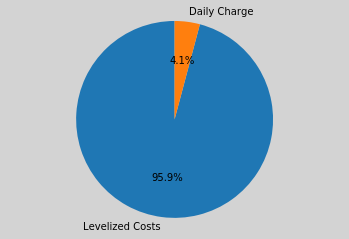

Total roof area of the  building: 599 m2
Total roof area used 587 m2
Percentage: 98.1%
succes
[[213.3870228135429, 228.07834032010922, 188.86482950536362, 34.33797073989319, 25.538234829104656, 54.19893100486983, 0.5281559141586587, 0.7994897379533356, 0.624720301861766, 3213.74, 310.171, 310.171, 0.0, 0.0, {'Levelized Costs': 3080.691, 'Energy Charge': 0.007000000000118689, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60042507279, 61845.7, 587.272]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (182.63934297205057, 170.0751952917382, 172.69587221841974, 8.077423640074853, 1.1783524729023256, 37.91650052670242, 0.3407419360904951, 0.24859009710600338, 0.5552645723653999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 183
                                           a tilt of 8.1
                                           and a gcr of 0.341


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.690959930419922 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 1.2
                                           and a gcr of 0.249


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.632725238800049 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 173
                                           a tilt of 37.9
                                           and a gcr of 0.555


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1852691173553467 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 300.84]


ERROR:ga_logger:Cost: 3121.06


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,121 per year


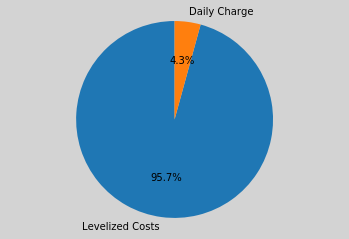

Total roof area of the  building: 599 m2
Total roof area used 542 m2
Percentage: 90.5%
succes
[[182.63934297205057, 170.0751952917382, 172.69587221841974, 8.077423640074853, 1.1783524729023256, 37.91650052670242, 0.3407419360904951, 0.24859009710600338, 0.5552645723653999, 3121.06, 300.84, 0.0, 0.0, 300.84, {'Levelized Costs': 2987.999, 'Energy Charge': 0.01900000000023283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60092181994, 61845.7, 541.796]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (214.11750748853768, 254.18608676565933, 197.04852630929702, 34.92471789382166, 22.39278763057161, 53.33188718510645, 0.708749736985596, 0.7982586595630656, 0.673975447867078)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 214
                                           a tilt of 34.9
                                           and a gcr of 0.709


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8432679176330566 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 254
                                           a tilt of 22.4
                                           and a gcr of 0.798


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2669997215270996 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 197
                                           a tilt of 53.3
                                           and a gcr of 0.674


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.18298077583313 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [324.512, 0.0, 0.0]


ERROR:ga_logger:Cost: 3356.17


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,356 per year


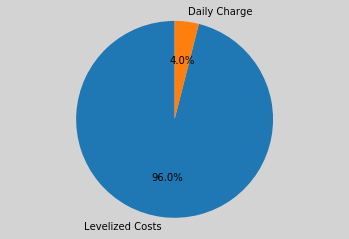

Total roof area of the  building: 599 m2
Total roof area used 458 m2
Percentage: 76.5%
succes
[[214.11750748853768, 254.18608676565933, 197.04852630929702, 34.92471789382166, 22.39278763057161, 53.33188718510645, 0.708749736985596, 0.7982586595630656, 0.673975447867078, 3356.17, 324.512, 324.512, 0.0, 0.0, {'Levelized Costs': 3223.121, 'Energy Charge': 0.0070000000001755325, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60182712791, 61845.7, 457.865]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (169.9406039789963, 238.85885170472983, 182.84075894504696, 2.506169626066466, 1.0547870606427163, 50.32767133218276, 0.29747774322054205, 0.2556210487461307, 0.527078310286481)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 2.5
                                           and a gcr of 0.297


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.531554698944092 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 239
                                           a tilt of 1.1
                                           and a gcr of 0.256


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.251516342163086 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 183
                                           a tilt of 50.3
                                           and a gcr of 0.527


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1629185676574707 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 309.109]


ERROR:ga_logger:Cost: 3203.18


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,203 per year


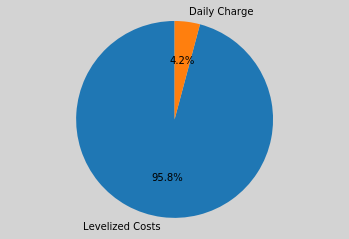

Total roof area of the  building: 599 m2
Total roof area used 586 m2
Percentage: 97.9%
succes
[[169.9406039789963, 238.85885170472983, 182.84075894504696, 2.506169626066466, 1.0547870606427163, 50.32767133218276, 0.29747774322054205, 0.2556210487461307, 0.527078310286481, 3203.18, 309.109, 0.0, 0.0, 309.109, {'Levelized Costs': 3070.127, 'Energy Charge': 0.010999999999967258, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601468571906, 61845.7, 586.457]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (120.45433852248136, 151.26033014466404, 204.01767113295918, 39.65610283547284, 29.317664688763127, 11.993495439381235, 0.6312452741236106, 0.7248181771565787, 0.65468527043641)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 39.7
                                           and a gcr of 0.631


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.717607021331787 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 151
                                           a tilt of 29.3
                                           and a gcr of 0.725


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.247771978378296 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 204
                                           a tilt of 12.0
                                           and a gcr of 0.655


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2938129901885986 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 313.463]


ERROR:ga_logger:Cost: 3246.43


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,246 per year


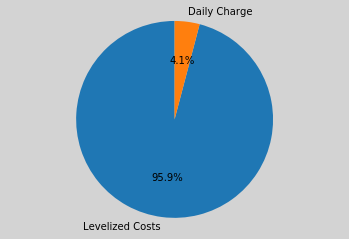

Total roof area of the  building: 599 m2
Total roof area used 479 m2
Percentage: 80.0%
succes
[[120.45433852248136, 151.26033014466404, 204.01767113295918, 39.65610283547284, 29.317664688763127, 11.993495439381235, 0.6312452741236106, 0.7248181771565787, 0.65468527043641, 3246.43, 313.463, 0.0, 0.0, 313.463, {'Levelized Costs': 3113.3669999999997, 'Energy Charge': 0.021000000000185537, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600140631665, 61845.7, 478.799]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (92.17225529011914, 149.65341850690632, 180.8140681426324, 42.76125206629421, 29.154621952299767, 10.961610810183162, 0.5728667027965579, 0.6720602682885448, 0.5923964403310591)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 42.8
                                           and a gcr of 0.573


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6906850337982178 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 29.2
                                           and a gcr of 0.672


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.171290636062622 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 11.0
                                           and a gcr of 0.592


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9970762729644775 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 310.723]


ERROR:ga_logger:Cost: 3219.22


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,219 per year


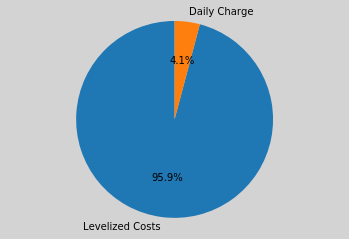

Total roof area of the  building: 599 m2
Total roof area used 525 m2
Percentage: 87.6%
succes
[[92.17225529011914, 149.65341850690632, 180.8140681426324, 42.76125206629421, 29.154621952299767, 10.961610810183162, 0.5728667027965579, 0.6720602682885448, 0.5923964403310591, 3219.22, 310.723, 0.0, 0.0, 310.723, {'Levelized Costs': 3086.167, 'Energy Charge': 0.011000000000194632, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601619211986, 61845.7, 524.518]]


ERROR:optimizer_logger:60


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (184.86884378075996, 170.0751952917382, 166.10311258218587, 45.29513217718532, 55.51869306841401, 45.62585473136951, 0.528043893674851, 0.7695952621065882, 0.7303543289697261)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 45.3
                                           and a gcr of 0.528


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7630045413970947 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 55.5
                                           and a gcr of 0.770


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.228588104248047 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 166
                                           a tilt of 45.6
                                           and a gcr of 0.730


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.195251941680908 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [303.493, 0.0, 0.0]


ERROR:ga_logger:Cost: 3147.41


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,147 per year


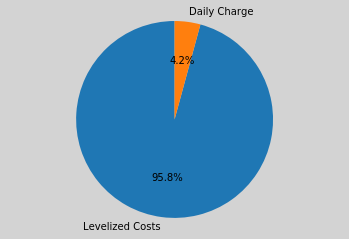

Total roof area of the  building: 599 m2
Total roof area used 575 m2
Percentage: 96.0%
succes
[[184.86884378075996, 170.0751952917382, 166.10311258218587, 45.29513217718532, 55.51869306841401, 45.62585473136951, 0.528043893674851, 0.7695952621065882, 0.7303543289697261, 3147.41, 303.493, 303.493, 0.0, 0.0, {'Levelized Costs': 3014.352, 'Energy Charge': 0.016000000000019554, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599316259075, 61845.7, 574.75]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (182.63934297205057, 166.81991503668968, 149.1230972723694, 6.502401432579816, 2.710803877030291, 37.91650052670242, 0.3407419360904951, 0.24859009710600338, 0.6228595528049404)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 183
                                           a tilt of 6.5
                                           and a gcr of 0.341


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.366024971008301 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 167
                                           a tilt of 2.7
                                           and a gcr of 0.249


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0461137294769287 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 149
                                           a tilt of 37.9
                                           and a gcr of 0.623


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1512246131896973 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 316.558]


ERROR:ga_logger:Cost: 3277.18


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,277 per year


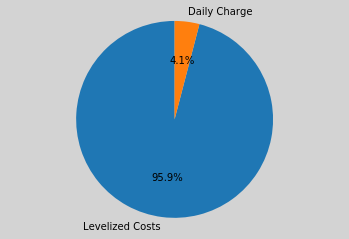

Total roof area of the  building: 599 m2
Total roof area used 508 m2
Percentage: 84.9%
succes
[[182.63934297205057, 166.81991503668968, 149.1230972723694, 6.502401432579816, 2.710803877030291, 37.91650052670242, 0.3407419360904951, 0.24859009710600338, 0.6228595528049404, 3277.18, 316.558, 0.0, 0.0, 316.558, {'Levelized Costs': 3144.122, 'Energy Charge': 0.01599999999996271, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600913499904, 61845.7, 508.234]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (136.642875005909, 188.94367129482177, 171.91976719966982, 44.21135705036649, 26.80675754178056, 41.450047014944666, 0.2224285948262213, 0.363592949793903, 0.6338931512420234)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 137
                                           a tilt of 44.2
                                           and a gcr of 0.222


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.738137722015381 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 189
                                           a tilt of 26.8
                                           and a gcr of 0.364


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2673120498657227 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 172
                                           a tilt of 41.5
                                           and a gcr of 0.634


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2489120960235596 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 102.313, 201.177]


ERROR:ga_logger:Cost: 3147.38


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,147 per year


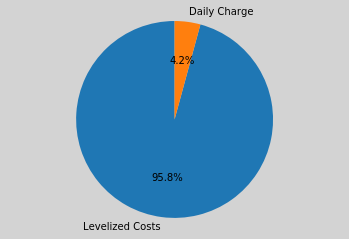

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[136.642875005909, 188.94367129482177, 171.91976719966982, 44.21135705036649, 26.80675754178056, 41.450047014944666, 0.2224285948262213, 0.363592949793903, 0.6338931512420234, 3147.38, 303.49, 0.0, 102.313, 201.177, {'Levelized Costs': 3014.32, 'Energy Charge': 0.018000000000256478, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60227823985, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (134.99130867472678, 188.18608202312342, 171.91976719966982, 33.814990068854, 25.312717280108878, 33.93983586422115, 0.2079131295948468, 0.4597081077036867, 0.6178344586355783)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 33.8
                                           and a gcr of 0.208


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7809531688690186 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 188
                                           a tilt of 25.3
                                           and a gcr of 0.460


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.240034818649292 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 172
                                           a tilt of 33.9
                                           and a gcr of 0.618


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.143448829650879 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 210.322, 87.2683]


ERROR:ga_logger:Cost: 3088.79


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,089 per year


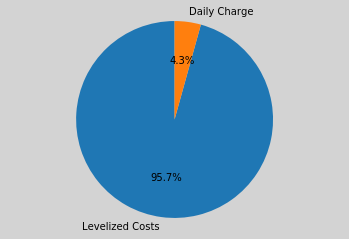

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[134.99130867472678, 188.18608202312342, 171.91976719966982, 33.814990068854, 25.312717280108878, 33.93983586422115, 0.2079131295948468, 0.4597081077036867, 0.6178344586355783, 3088.79, 297.5903, 0.0, 210.322, 87.2683, {'Levelized Costs': 2955.732, 'Energy Charge': 0.01600000000013324, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60114227747, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (167.80377429580892, 242.1862758419656, 174.16593012513744, 34.277151427257024, 28.471984560862484, 54.18326086536618, 0.7261300747422104, 0.517981783653364, 0.5613266916637959)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 168
                                           a tilt of 34.3
                                           and a gcr of 0.726


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6709914207458496 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 242
                                           a tilt of 28.5
                                           and a gcr of 0.518


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.47163987159729 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 174
                                           a tilt of 54.2
                                           and a gcr of 0.561


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1744940280914307 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [310.911, 0.0, 0.0]


ERROR:ga_logger:Cost: 3221.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,221 per year


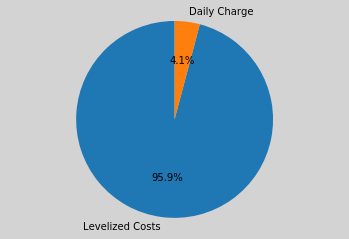

Total roof area of the  building: 599 m2
Total roof area used 428 m2
Percentage: 71.5%
succes
[[167.80377429580892, 242.1862758419656, 174.16593012513744, 34.277151427257024, 28.471984560862484, 54.18326086536618, 0.7261300747422104, 0.517981783653364, 0.5613266916637959, 3221.09, 310.911, 310.911, 0.0, 0.0, {'Levelized Costs': 3088.032, 'Energy Charge': 0.01599999999996271, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60074519999, 61845.7, 428.175]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (129.99970236185553, 173.31876590836026, 166.7078917159733, 2.900752762696747, 1.1061574939056928, 35.71140518174039, 0.2327675648139625, 0.32535909415449943, 0.5454589366633111)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 2.9
                                           and a gcr of 0.233


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7056241035461426 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 173
                                           a tilt of 1.1
                                           and a gcr of 0.325


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.2795352935791016 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 167
                                           a tilt of 35.7
                                           and a gcr of 0.545


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.19240403175354 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 300.671]


ERROR:ga_logger:Cost: 3119.39


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,119 per year


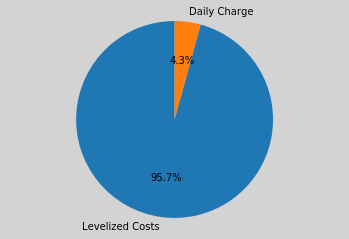

Total roof area of the  building: 599 m2
Total roof area used 551 m2
Percentage: 92.1%
succes
[[129.99970236185553, 173.31876590836026, 166.7078917159733, 2.900752762696747, 1.1061574939056928, 35.71140518174039, 0.2327675648139625, 0.32535909415449943, 0.5454589366633111, 3119.39, 300.671, 0.0, 0.0, 300.671, {'Levelized Costs': 2986.337, 'Energy Charge': 0.010999999999910415, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60087679999, 61845.7, 551.227]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (184.86884378075996, 168.69364324158232, 182.93352784924974, 42.83763784731927, 55.51869306841401, 44.98005640770459, 0.5353704075322954, 0.7742003450543429, 0.7489369244676337)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 42.8
                                           and a gcr of 0.535


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7963242530822754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 169
                                           a tilt of 55.5
                                           and a gcr of 0.774


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1835272312164307 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 183
                                           a tilt of 45.0
                                           and a gcr of 0.749


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2750885486602783 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [301.485, 0.0, 0.0]


ERROR:ga_logger:Cost: 3127.47


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,127 per year


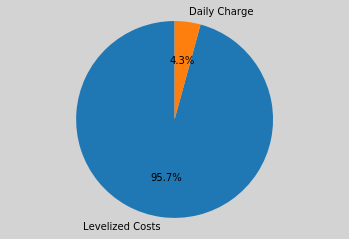

Total roof area of the  building: 599 m2
Total roof area used 563 m2
Percentage: 94.0%
succes
[[184.86884378075996, 168.69364324158232, 182.93352784924974, 42.83763784731927, 55.51869306841401, 44.98005640770459, 0.5353704075322954, 0.7742003450543429, 0.7489369244676337, 3127.47, 301.485, 301.485, 0.0, 0.0, {'Levelized Costs': 2994.4139999999993, 'Energy Charge': 0.014000000000351065, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60088685964, 61845.7, 563.134]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (129.6300517105972, 166.16155336617126, 148.40958194376475, 25.847757425773665, 12.915363519918834, 23.71281589298825, 0.24464145730221531, 0.42990302738684716, 0.7303917953780438)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 25.8
                                           and a gcr of 0.245


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7896487712860107 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 166
                                           a tilt of 12.9
                                           and a gcr of 0.430


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1752686500549316 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 148
                                           a tilt of 23.7
                                           and a gcr of 0.730


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1576247215270996 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 181.201, 129.476]


ERROR:ga_logger:Cost: 3218.76


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,219 per year


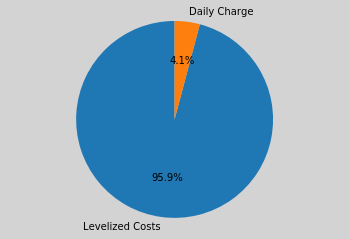

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[129.6300517105972, 166.16155336617126, 148.40958194376475, 25.847757425773665, 12.915363519918834, 23.71281589298825, 0.24464145730221531, 0.42990302738684716, 0.7303917953780438, 3218.76, 310.677, 0.0, 181.201, 129.476, {'Levelized Costs': 3085.704, 'Energy Charge': 0.014000000000351065, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60042252075, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (184.78490073871015, 218.24508026599594, 198.7237646407822, 29.84588055177778, 7.956071752597102, 38.26777415281028, 0.33782889764186935, 0.6238914406412814, 0.6778918736974168)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 29.8
                                           and a gcr of 0.338


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.819863796234131 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 218
                                           a tilt of 8.0
                                           and a gcr of 0.624


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.348407745361328 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 199
                                           a tilt of 38.3
                                           and a gcr of 0.678


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2059202194213867 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [99.5181, 0.0, 206.201]


ERROR:ga_logger:Cost: 3169.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,170 per year


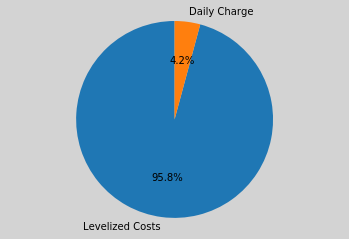

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[184.78490073871015, 218.24508026599594, 198.7237646407822, 29.84588055177778, 7.956071752597102, 38.26777415281028, 0.33782889764186935, 0.6238914406412814, 0.6778918736974168, 3169.52, 305.7191, 99.5181, 0.0, 206.201, {'Levelized Costs': 3036.462, 'Energy Charge': 0.01600000000030377, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601002294825, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (124.8212621118914, 170.0751952917382, 172.69587221841974, 10.460426352509497, 2.825731475775296, 20.74327947550115, 0.2548408026209046, 0.401232200881906, 0.5552645723653999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 10.5
                                           and a gcr of 0.255


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.823640823364258 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 2.8
                                           and a gcr of 0.401


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.090590476989746 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 173
                                           a tilt of 20.7
                                           and a gcr of 0.555


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.174827814102173 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 300.23]


ERROR:ga_logger:Cost: 3115.0


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,115 per year


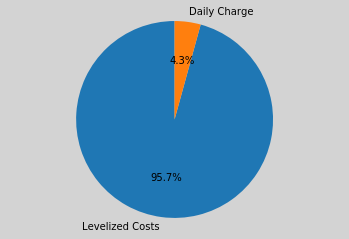

Total roof area of the  building: 599 m2
Total roof area used 541 m2
Percentage: 90.3%
succes
[[124.8212621118914, 170.0751952917382, 172.69587221841974, 10.460426352509497, 2.825731475775296, 20.74327947550115, 0.2548408026209046, 0.401232200881906, 0.5552645723653999, 3115.0, 300.23, 0.0, 0.0, 300.23, {'Levelized Costs': 2981.94, 'Energy Charge': 0.018000000000029104, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601186759865, 61845.7, 540.697]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (126.33357373926779, 157.04043646495592, 128.32847983309955, 31.348033013207004, 27.71926435129174, 32.797313441680515, 0.3447642471812618, 0.5003342672391256, 0.6453061868846162)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 126
                                           a tilt of 31.3
                                           and a gcr of 0.345


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7940876483917236 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 157
                                           a tilt of 27.7
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.167619228363037 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 128
                                           a tilt of 32.8
                                           and a gcr of 0.645


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.502547025680542 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 297.88, 2.1933]


ERROR:ga_logger:Cost: 3113.45


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,113 per year


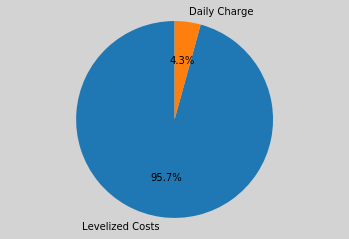

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[126.33357373926779, 157.04043646495592, 128.32847983309955, 31.348033013207004, 27.71926435129174, 32.797313441680515, 0.3447642471812618, 0.5003342672391256, 0.6453061868846162, 3113.45, 300.0733, 0.0, 297.88, 2.1933, {'Levelized Costs': 2980.392, 'Energy Charge': 0.01600000000013324, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60398815647, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (117.84997103300907, 152.82169681773937, 141.98689243519848, 24.562318416385004, 1.0545899167117674, 17.41058917717007, 0.21795947772021565, 0.3747304550333024, 0.6234218523152398)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 118
                                           a tilt of 24.6
                                           and a gcr of 0.218


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.873171329498291 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 153
                                           a tilt of 1.1
                                           and a gcr of 0.375


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.283888101577759 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 142
                                           a tilt of 17.4
                                           and a gcr of 0.623


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.238276958465576 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 312.342]


ERROR:ga_logger:Cost: 3235.3


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,235 per year


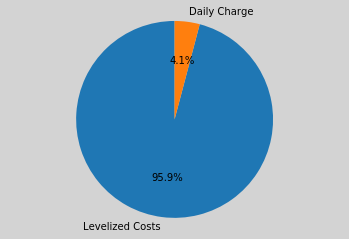

Total roof area of the  building: 599 m2
Total roof area used 501 m2
Percentage: 83.7%
succes
[[117.84997103300907, 152.82169681773937, 141.98689243519848, 24.562318416385004, 1.0545899167117674, 17.41058917717007, 0.21795947772021565, 0.3747304550333024, 0.6234218523152398, 3235.3, 312.342, 0.0, 0.0, 312.342, {'Levelized Costs': 3102.243, 'Energy Charge': 0.015000000000213731, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60139874003, 61845.7, 501.013]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (179.3484095864825, 196.95363335422059, 204.88816202095745, 37.57890905978712, 55.75601230238382, 34.104283488334964, 0.5195320070687146, 0.8041538229578914, 0.8380383736876436)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 179
                                           a tilt of 37.6
                                           and a gcr of 0.520


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8413915634155273 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 197
                                           a tilt of 55.8
                                           and a gcr of 0.804


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1801860332489014 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 34.1
                                           and a gcr of 0.838


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1885323524475098 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [298.093, 0.0, 0.0]


ERROR:ga_logger:Cost: 3093.78


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,094 per year


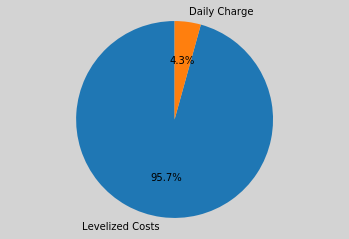

Total roof area of the  building: 599 m2
Total roof area used 574 m2
Percentage: 95.8%
succes
[[179.3484095864825, 196.95363335422059, 204.88816202095745, 37.57890905978712, 55.75601230238382, 34.104283488334964, 0.5195320070687146, 0.8041538229578914, 0.8380383736876436, 3093.78, 298.093, 298.093, 0.0, 0.0, {'Levelized Costs': 2960.7230000000004, 'Energy Charge': 0.015000000000100044, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601988600065, 61845.7, 573.772]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (141.2271534307713, 166.34204558822944, 191.34990900434642, 45.67013620583358, 24.736388778031838, 43.51278163103608, 0.2640273366877278, 0.5274505552479732, 0.8876002460290301)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 141
                                           a tilt of 45.7
                                           and a gcr of 0.264


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.100810766220093 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 166
                                           a tilt of 24.7
                                           and a gcr of 0.527


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.235191822052002 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 191
                                           a tilt of 43.5
                                           and a gcr of 0.888


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.252178430557251 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 298.508, 0.0]


ERROR:ga_logger:Cost: 3097.9


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,098 per year


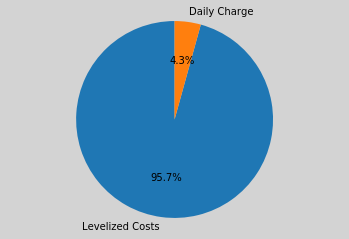

Total roof area of the  building: 599 m2
Total roof area used 566 m2
Percentage: 94.5%
succes
[[141.2271534307713, 166.34204558822944, 191.34990900434642, 45.67013620583358, 24.736388778031838, 43.51278163103608, 0.2640273366877278, 0.5274505552479732, 0.8876002460290301, 3097.9, 298.508, 0.0, 298.508, 0.0, {'Levelized Costs': 2964.851, 'Energy Charge': 0.007000000000118689, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60238449997, 61845.7, 565.945]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (147.02746272027366, 187.91796814170888, 157.36049451795944, 33.96676844293922, 32.871720527439145, 34.87793470213803, 0.23275133068523274, 0.6207479970146283, 0.6961066251958289)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 147
                                           a tilt of 34.0
                                           and a gcr of 0.233


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.3885416984558105 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 188
                                           a tilt of 32.9
                                           and a gcr of 0.621


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2715673446655273 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 157
                                           a tilt of 34.9
                                           and a gcr of 0.696


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2061283588409424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [42.876, 257.33, 0.0]


ERROR:ga_logger:Cost: 3114.76


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,115 per year


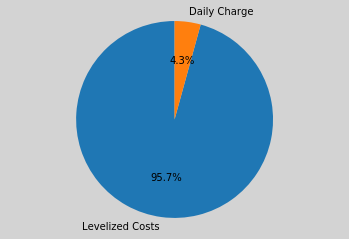

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[147.02746272027366, 187.91796814170888, 157.36049451795944, 33.96676844293922, 32.871720527439145, 34.87793470213803, 0.23275133068523274, 0.6207479970146283, 0.6961066251958289, 3114.76, 300.20599999999996, 42.876, 257.33, 0.0, {'Levelized Costs': 2981.704, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599166502136, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (147.02746272027366, 184.16867722420804, 155.46861633484443, 33.96676844293922, 32.539166471305144, 23.19079255432086, 0.20183621479326616, 0.4776194718885435, 0.6961066251958289)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 147
                                           a tilt of 34.0
                                           and a gcr of 0.202


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.810581684112549 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 184
                                           a tilt of 32.5
                                           and a gcr of 0.478


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4670896530151367 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 23.2
                                           and a gcr of 0.696


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1906049251556396 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 264.512, 31.2894]


ERROR:ga_logger:Cost: 3071.01


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,071 per year


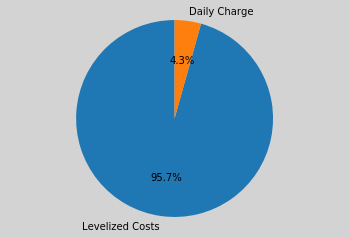

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[147.02746272027366, 184.16867722420804, 155.46861633484443, 33.96676844293922, 32.539166471305144, 23.19079255432086, 0.20183621479326616, 0.4776194718885435, 0.6961066251958289, 3071.01, 295.8014, 0.0, 264.512, 31.2894, {'Levelized Costs': 2937.949, 'Energy Charge': 0.01900000000023283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6018397654, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (201.8724482553455, 228.55478383329108, 181.75286926035872, 34.34057807204904, 24.62856582674809, 52.23336500275205, 0.4657469182570938, 0.8267151378834889, 0.6341318067187083)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 202
                                           a tilt of 34.3
                                           and a gcr of 0.466


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9238171577453613 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 229
                                           a tilt of 24.6
                                           and a gcr of 0.827


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2470316886901855 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 52.2
                                           and a gcr of 0.634


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2529404163360596 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [204.102, 0.0, 101.801]


ERROR:ga_logger:Cost: 3171.35


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,171 per year


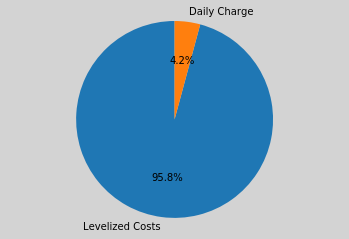

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[201.8724482553455, 228.55478383329108, 181.75286926035872, 34.34057807204904, 24.62856582674809, 52.23336500275205, 0.4657469182570938, 0.8267151378834889, 0.6341318067187083, 3171.35, 305.903, 204.102, 0.0, 101.801, {'Levelized Costs': 3038.295, 'Energy Charge': 0.013000000000090495, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600715446344, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (142.20224113961868, 185.14570253093942, 166.52206011360764, 34.35196824544843, 21.71793146082506, 35.18999013196338, 0.2061725809124332, 0.43318686604116297, 0.5136758012070411)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 142
                                           a tilt of 34.4
                                           and a gcr of 0.206


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.1628499031066895 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 21.7
                                           and a gcr of 0.433


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2594730854034424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 167
                                           a tilt of 35.2
                                           and a gcr of 0.514


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1385276317596436 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 48.1003, 250.532]


ERROR:ga_logger:Cost: 3099.13


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,099 per year


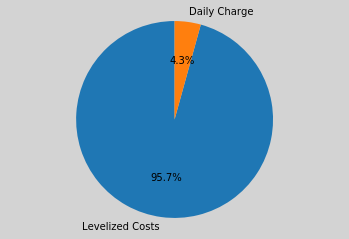

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[142.20224113961868, 185.14570253093942, 166.52206011360764, 34.35196824544843, 21.71793146082506, 35.18999013196338, 0.2061725809124332, 0.43318686604116297, 0.5136758012070411, 3099.13, 298.6323, 0.0, 48.1003, 250.532, {'Levelized Costs': 2966.07, 'Energy Charge': 0.018000000000256478, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60356260606, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (140.1568578482297, 205.82317883120547, 175.7084813656335, 34.277151427257024, 28.715451722452425, 35.29575958836327, 0.20123629422792566, 0.582484000167304, 0.624720301861766)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 34.3
                                           and a gcr of 0.201


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.191343307495117 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 206
                                           a tilt of 28.7
                                           and a gcr of 0.582


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3320748805999756 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 176
                                           a tilt of 35.3
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2591261863708496 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [34.1565, 0.0, 268.023]


ERROR:ga_logger:Cost: 3134.36


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,134 per year


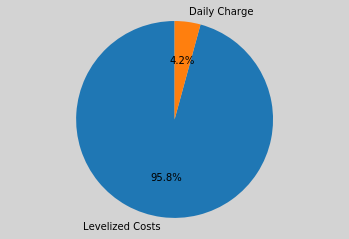

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[140.1568578482297, 205.82317883120547, 175.7084813656335, 34.277151427257024, 28.715451722452425, 35.29575958836327, 0.20123629422792566, 0.582484000167304, 0.624720301861766, 3134.36, 302.1795, 34.1565, 0.0, 268.023, {'Levelized Costs': 3001.31, 'Energy Charge': 0.008000000000265572, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600366203944, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (131.9658325547713, 187.23559793265463, 161.6188686453252, 33.814990068854, 26.989097504011024, 29.271834031211153, 0.20123193414665091, 0.4630719160670221, 0.624720301861766)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 132
                                           a tilt of 33.8
                                           and a gcr of 0.201


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.053908348083496 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 187
                                           a tilt of 27.0
                                           and a gcr of 0.463


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.208465337753296 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 162
                                           a tilt of 29.3
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.190948486328125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [0.0, 219.825, 77.4979]


ERROR:ga_logger:Cost: 3086.12


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,086 per year


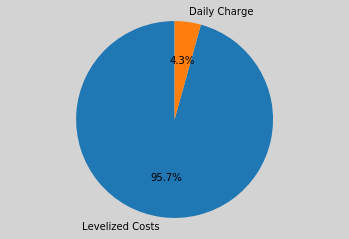

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[131.9658325547713, 187.23559793265463, 161.6188686453252, 33.814990068854, 26.989097504011024, 29.271834031211153, 0.20123193414665091, 0.4630719160670221, 0.624720301861766, 3086.12, 297.3229, 0.0, 219.825, 77.4979, {'Levelized Costs': 2953.0649999999996, 'Energy Charge': 0.013000000000317868, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60224280563, 61845.7, 598.762]]


ERROR:optimizer_logger:80


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (179.23225225425625, 198.86945241533678, 204.88816202095745, 38.71916594501369, 55.85510651400595, 34.104283488334964, 0.5246256441867145, 0.8041538229578914, 0.8743949933116725)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 179
                                           a tilt of 38.7
                                           and a gcr of 0.525


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.976844549179077 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 199
                                           a tilt of 55.9
                                           and a gcr of 0.804


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.251934766769409 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 34.1
                                           and a gcr of 0.874


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2650933265686035 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [298.973, 0.0, 0.0]


ERROR:ga_logger:Cost: 3102.51


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,103 per year


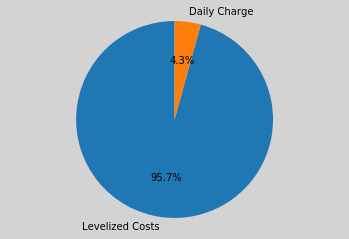

Total roof area of the  building: 599 m2
Total roof area used 570 m2
Percentage: 95.2%
succes
[[179.23225225425625, 198.86945241533678, 204.88816202095745, 38.71916594501369, 55.85510651400595, 34.104283488334964, 0.5246256441867145, 0.8041538229578914, 0.8743949933116725, 3102.51, 298.973, 298.973, 0.0, 0.0, {'Levelized Costs': 2969.4550000000004, 'Energy Charge': 0.013000000000147338, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60216960014, 61845.7, 569.878]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (133.69561319821418, 182.2593084408536, 174.64629218220836, 33.31807607483169, 30.318629824531353, 23.461198687201694, 0.20044811761041398, 0.49872017854270345, 0.6961066251958289)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 134
                                           a tilt of 33.3
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.335390567779541 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 30.3
                                           and a gcr of 0.499


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.768889665603638 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 23.5
                                           and a gcr of 0.696


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.284052610397339 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  17 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 294.397, 0.0]


ERROR:ga_logger:Cost: 3057.07


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,057 per year


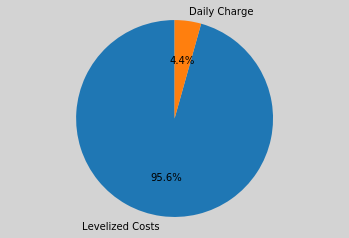

Total roof area of the  building: 599 m2
Total roof area used 590 m2
Percentage: 98.6%
succes
[[133.69561319821418, 182.2593084408536, 174.64629218220836, 33.31807607483169, 30.318629824531353, 23.461198687201694, 0.20044811761041398, 0.49872017854270345, 0.6961066251958289, 3057.07, 294.397, 0.0, 294.397, 0.0, {'Levelized Costs': 2924.0130000000004, 'Energy Charge': 0.015000000000043201, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6027835829, 61845.7, 590.305]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (124.8212621118914, 170.0751952917382, 179.32113374413393, 10.460426352509497, 2.492464962961183, 25.041405070663387, 0.277681955835932, 0.40787320158117374, 0.5552645723653999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 10.5
                                           and a gcr of 0.278


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.022590398788452 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 2.5
                                           and a gcr of 0.408


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0816705226898193 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 179
                                           a tilt of 25.0
                                           and a gcr of 0.555


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2058041095733643 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 297.92]


ERROR:ga_logger:Cost: 3092.06


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,092 per year


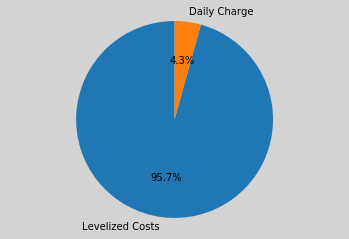

Total roof area of the  building: 599 m2
Total roof area used 537 m2
Percentage: 89.6%
succes
[[124.8212621118914, 170.0751952917382, 179.32113374413393, 10.460426352509497, 2.492464962961183, 25.041405070663387, 0.277681955835932, 0.40787320158117374, 0.5552645723653999, 3092.06, 297.92, 0.0, 0.0, 297.92, {'Levelized Costs': 2959.003, 'Energy Charge': 0.015000000000100044, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60224293957, 61845.7, 536.538]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (107.92570982569072, 170.0751952917382, 174.8463502631629, 6.99924771104734, 2.859972228055285, 19.682932830719174, 0.25480772815805103, 0.4085824625124587, 0.5552645723653999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 108
                                           a tilt of 7.0
                                           and a gcr of 0.255


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.043644666671753 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 2.9
                                           and a gcr of 0.409


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3504765033721924 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 19.7
                                           and a gcr of 0.555


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.313209295272827 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 300.811]


ERROR:ga_logger:Cost: 3120.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,121 per year


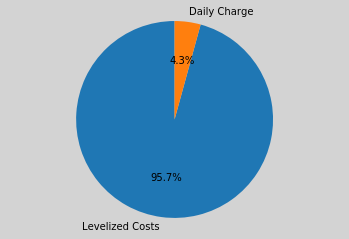

Total roof area of the  building: 599 m2
Total roof area used 542 m2
Percentage: 90.5%
succes
[[107.92570982569072, 170.0751952917382, 174.8463502631629, 6.99924771104734, 2.859972228055285, 19.682932830719174, 0.25480772815805103, 0.4085824625124587, 0.5552645723653999, 3120.77, 300.811, 0.0, 0.0, 300.811, {'Levelized Costs': 2987.714, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601779659504, 61845.7, 541.743]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (151.9483196570304, 184.30693405291922, 166.7078917159733, 32.100022231162406, 25.55260204754329, 37.23495769692782, 0.3648874582500602, 0.33354977681856224, 0.6450195642182275)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 152
                                           a tilt of 32.1
                                           and a gcr of 0.365


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.129769325256348 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 184
                                           a tilt of 25.6
                                           and a gcr of 0.334


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.179211378097534 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 167
                                           a tilt of 37.2
                                           and a gcr of 0.645


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3847737312316895 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Can not solve this model correctly.


succes
[[151.9483196570304, 184.30693405291922, 166.7078917159733, 32.100022231162406, 25.55260204754329, 37.23495769692782, 0.3648874582500602, 0.33354977681856224, 0.6450195642182275, 90000000000, 0, 0.0, 0.0, 0.0, {'Levelized Costs': 0, 'Energy Charge': 10000000000, 'Demand Charge': 0, 'Daily Charge': 0}, 90000000000, 90000000000, 0]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (129.85496185085674, 173.1917975284181, 157.28082863451675, 8.346915923694256, 1.207348722075995, 35.32228471423498, 0.22184762222349413, 0.4670668730524638, 0.5459684082218688)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 8.3
                                           and a gcr of 0.222


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.093313694000244 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 173
                                           a tilt of 1.2
                                           and a gcr of 0.467


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.06412935256958 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 157
                                           a tilt of 35.3
                                           and a gcr of 0.546


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.206505060195923 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 304.088]


ERROR:ga_logger:Cost: 3153.32


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,153 per year


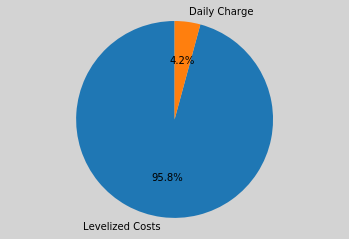

Total roof area of the  building: 599 m2
Total roof area used 557 m2
Percentage: 93.0%
succes
[[129.85496185085674, 173.1917975284181, 157.28082863451675, 8.346915923694256, 1.207348722075995, 35.32228471423498, 0.22184762222349413, 0.4670668730524638, 0.5459684082218688, 3153.32, 304.088, 0.0, 0.0, 304.088, {'Levelized Costs': 3020.2580000000003, 'Energy Charge': 0.020000000000209184, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59928009003, 61845.7, 556.97]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (148.3556867579782, 198.34302898968633, 171.91976719966982, 33.814990068854, 26.06529566836997, 38.44902889262264, 0.26535312231787594, 0.5122394352993032, 0.6989061530944704)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 148
                                           a tilt of 33.8
                                           and a gcr of 0.265


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.139989852905273 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 198
                                           a tilt of 26.1
                                           and a gcr of 0.512


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2112045288085938 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 172
                                           a tilt of 38.4
                                           and a gcr of 0.699


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.302886486053467 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [7.79104, 291.669, 0.0]


ERROR:ga_logger:Cost: 3107.36


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,107 per year


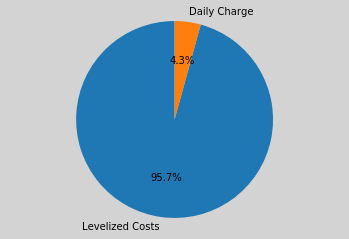

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[148.3556867579782, 198.34302898968633, 171.91976719966982, 33.814990068854, 26.06529566836997, 38.44902889262264, 0.26535312231787594, 0.5122394352993032, 0.6989061530944704, 3107.36, 299.46004, 7.79104, 291.669, 0.0, {'Levelized Costs': 2974.302, 'Energy Charge': 0.016000000000190084, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60074930324, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (131.7308444578372, 196.5299948818088, 168.4998647351963, 33.814990068854, 10.6770260541519, 34.17971100481906, 0.20886347254141735, 0.4600610779366041, 0.5421057211414014)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 132
                                           a tilt of 33.8
                                           and a gcr of 0.209


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.147640943527222 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 197
                                           a tilt of 10.7
                                           and a gcr of 0.460


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2593302726745605 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 34.2
                                           and a gcr of 0.542


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.459963083267212 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 299.261]


ERROR:ga_logger:Cost: 3105.37


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,105 per year


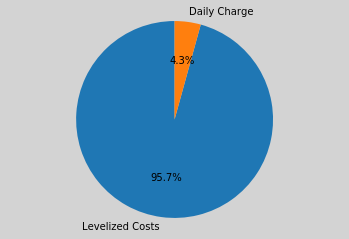

Total roof area of the  building: 599 m2
Total roof area used 552 m2
Percentage: 92.2%
succes
[[131.7308444578372, 196.5299948818088, 168.4998647351963, 33.814990068854, 10.6770260541519, 34.17971100481906, 0.20886347254141735, 0.4600610779366041, 0.5421057211414014, 3105.37, 299.261, 0.0, 0.0, 299.261, {'Levelized Costs': 2972.319, 'Energy Charge': 0.009000000000014552, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60109839998, 61845.7, 552.034]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (132.6656878183382, 184.0939132152901, 169.59486531882195, 34.277151427257024, 26.386235664368556, 37.01457205343283, 0.20060965193947533, 0.46318747827145224, 0.641851496375778)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 133
                                           a tilt of 34.3
                                           and a gcr of 0.201


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.173821449279785 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 184
                                           a tilt of 26.4
                                           and a gcr of 0.463


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2226481437683105 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 37.0
                                           and a gcr of 0.642


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.273693561553955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [0.0, 225.438, 71.9205]


ERROR:ga_logger:Cost: 3086.48


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 45,425 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,086 per year


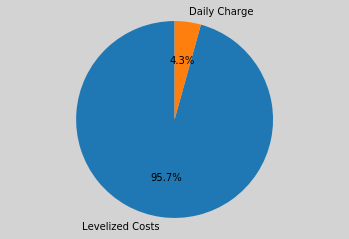

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[132.6656878183382, 184.0939132152901, 169.59486531882195, 34.277151427257024, 26.386235664368556, 37.01457205343283, 0.20060965193947533, 0.46318747827145224, 0.641851496375778, 3086.48, 297.3585, 0.0, 225.438, 71.9205, {'Levelized Costs': 2953.4269999999997, 'Energy Charge': 0.011000000000422006, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60282927828, 45425.1, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (131.45511554387025, 177.09986565058617, 166.30035443511082, 31.527036303499955, 26.386235664368556, 35.29575958836327, 0.2011866139107112, 0.5425150022190144, 0.6388790981269321)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 131
                                           a tilt of 31.5
                                           and a gcr of 0.201


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.166202783584595 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 177
                                           a tilt of 26.4
                                           and a gcr of 0.543


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.211521625518799 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 166
                                           a tilt of 35.3
                                           and a gcr of 0.639


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2163169384002686 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [0.0, 297.207, 0.0]


ERROR:ga_logger:Cost: 3084.98


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,085 per year


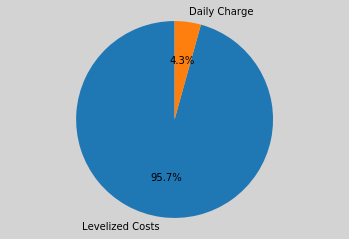

Total roof area of the  building: 599 m2
Total roof area used 548 m2
Percentage: 91.5%
succes
[[131.45511554387025, 177.09986565058617, 166.30035443511082, 31.527036303499955, 26.386235664368556, 35.29575958836327, 0.2011866139107112, 0.5425150022190144, 0.6388790981269321, 3084.98, 297.207, 0.0, 297.207, 0.0, {'Levelized Costs': 2951.924, 'Energy Charge': 0.014000000000294222, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601096760955, 61845.7, 547.832]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (142.20224113961868, 180.37893603045652, 165.6644052114557, 41.00883746373293, 27.17169047884388, 38.38668839934713, 0.2017577266439766, 0.41868072965156256, 0.5512895044689038)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 142
                                           a tilt of 41.0
                                           and a gcr of 0.202


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.1258299350738525 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 27.2
                                           and a gcr of 0.419


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2679030895233154 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 166
                                           a tilt of 38.4
                                           and a gcr of 0.551


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.266392946243286 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 95.7885, 203.963]


ERROR:ga_logger:Cost: 3110.25


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,110 per year


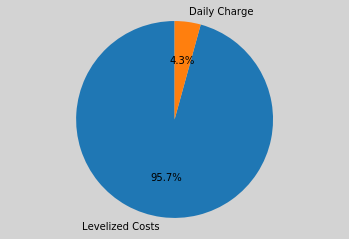

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[142.20224113961868, 180.37893603045652, 165.6644052114557, 41.00883746373293, 27.17169047884388, 38.38668839934713, 0.2017577266439766, 0.41868072965156256, 0.5512895044689038, 3110.25, 299.75149999999996, 0.0, 95.7885, 203.963, {'Levelized Costs': 2977.1959999999995, 'Energy Charge': 0.012000000000682576, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60105561796, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (120.18251746619576, 185.2970949092776, 161.6188686453252, 33.386219098620586, 14.060373854304492, 29.271834031211153, 0.20123193414665091, 0.45140879089170516, 0.5187474355312716)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 33.4
                                           and a gcr of 0.201


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.21313214302063 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 14.1
                                           and a gcr of 0.451


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.226911783218384 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 162
                                           a tilt of 29.3
                                           and a gcr of 0.519


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1729748249053955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 299.068]


ERROR:ga_logger:Cost: 3103.46


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,103 per year


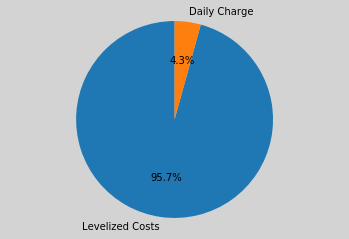

Total roof area of the  building: 599 m2
Total roof area used 577 m2
Percentage: 96.3%
succes
[[120.18251746619576, 185.2970949092776, 161.6188686453252, 33.386219098620586, 14.060373854304492, 29.271834031211153, 0.20123193414665091, 0.45140879089170516, 0.5187474355312716, 3103.46, 299.068, 0.0, 0.0, 299.068, {'Levelized Costs': 2970.404, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601496400166, 61845.7, 576.52]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (153.7082109011536, 185.14570253093942, 161.77097513067903, 35.494045464787405, 31.245668988371023, 42.00408475703006, 0.2329874491670228, 0.40038918621321706, 0.7060675705218714)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 154
                                           a tilt of 35.5
                                           and a gcr of 0.233


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.132171392440796 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 31.2
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1707570552825928 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 162
                                           a tilt of 42.0
                                           and a gcr of 0.706


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1725873947143555 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 154.08, 151.053]


ERROR:ga_logger:Cost: 3163.7


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,164 per year


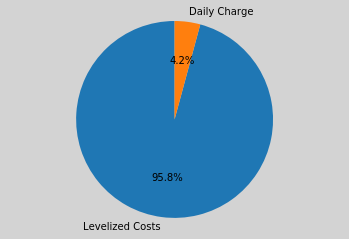

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[153.7082109011536, 185.14570253093942, 161.77097513067903, 35.494045464787405, 31.245668988371023, 42.00408475703006, 0.2329874491670228, 0.40038918621321706, 0.7060675705218714, 3163.7, 305.13300000000004, 0.0, 154.08, 151.053, {'Levelized Costs': 3030.6389999999997, 'Energy Charge': 0.01900000000023283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.598707204335, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (113.08062473101973, 184.51874432380765, 154.0910434687141, 31.020284034544026, 22.300425380244043, 33.89264234177171, 0.20415521071930046, 0.4237796984667487, 0.4804636934341653)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 113
                                           a tilt of 31.0
                                           and a gcr of 0.204


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.200196981430054 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 22.3
                                           and a gcr of 0.424


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.238740921020508 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 154
                                           a tilt of 33.9
                                           and a gcr of 0.480


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3793978691101074 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 287.683]


ERROR:ga_logger:Cost: 3345.08


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0057 /kWh
Total Cost of the system: $ 3,345 per year


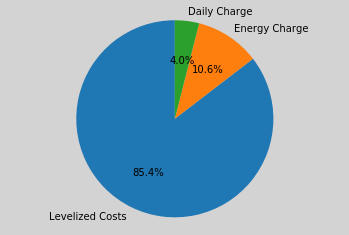

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[113.08062473101973, 184.51874432380765, 154.0910434687141, 31.020284034544026, 22.300425380244043, 33.89264234177171, 0.20415521071930046, 0.4237796984667487, 0.4804636934341653, 3345.08, 287.683, 0.0, 0.0, 287.683, {'Levelized Costs': 2857.3299999999995, 'Energy Charge': 354.7080000000003, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 59014.829921410266, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (163.5248987320407, 203.962052029025, 166.7784718148136, 43.633508579424046, 31.161220866212016, 35.588483174339885, 0.23193839736526276, 0.6173932958322541, 0.6961066251958289)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 164
                                           a tilt of 43.6
                                           and a gcr of 0.232


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.178950071334839 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 204
                                           a tilt of 31.2
                                           and a gcr of 0.617


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.198054790496826 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 167
                                           a tilt of 35.6
                                           and a gcr of 0.696


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.206879138946533 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [38.6039, 266.912, 0.0]


ERROR:ga_logger:Cost: 3167.5


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,168 per year


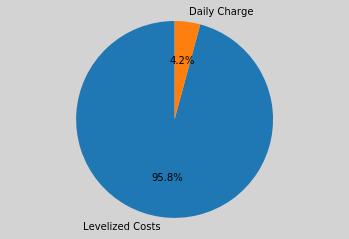

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[163.5248987320407, 203.962052029025, 166.7784718148136, 43.633508579424046, 31.161220866212016, 35.588483174339885, 0.23193839736526276, 0.6173932958322541, 0.6961066251958289, 3167.5, 305.5159, 38.6039, 266.912, 0.0, {'Levelized Costs': 3034.441, 'Energy Charge': 0.017000000000166438, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.5996617658, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (184.76597730140662, 190.94729029120347, 157.2871040354968, 36.5114296716488, 27.159661155765196, 35.351831095847025, 0.2031133923080599, 0.4618008916061882, 0.6961066251958289)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 36.5
                                           and a gcr of 0.203


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.240944862365723 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 191
                                           a tilt of 27.2
                                           and a gcr of 0.462


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.314196825027466 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 157
                                           a tilt of 35.4
                                           and a gcr of 0.696


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3426811695098877 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 230.427, 69.4619]


ERROR:ga_logger:Cost: 3111.62


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,112 per year


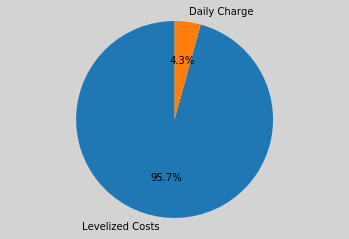

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[184.76597730140662, 190.94729029120347, 157.2871040354968, 36.5114296716488, 27.159661155765196, 35.351831095847025, 0.2031133923080599, 0.4618008916061882, 0.6961066251958289, 3111.62, 299.8889, 0.0, 230.427, 69.4619, {'Levelized Costs': 2978.568, 'Energy Charge': 0.009999999999820375, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603385398914, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (138.81496528709326, 189.04486875351765, 166.7119255592317, 35.16930368090225, 29.859775259977596, 35.48076608677894, 0.20173369078712627, 0.4572538525755695, 0.6273126141159969)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 139
                                           a tilt of 35.2
                                           and a gcr of 0.202


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.4629340171813965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 189
                                           a tilt of 29.9
                                           and a gcr of 0.457


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1283974647521973 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 167
                                           a tilt of 35.5
                                           and a gcr of 0.627


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.136319875717163 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 209.279, 88.4977]


ERROR:ga_logger:Cost: 3090.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,091 per year


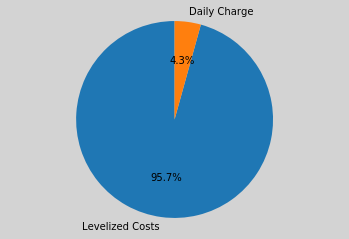

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[138.81496528709326, 189.04486875351765, 166.7119255592317, 35.16930368090225, 29.859775259977596, 35.48076608677894, 0.20173369078712627, 0.4572538525755695, 0.6273126141159969, 3090.64, 297.7767, 0.0, 209.279, 88.4977, {'Levelized Costs': 2957.584, 'Energy Charge': 0.014000000000010004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6019760992, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (147.64236214163975, 181.30989390264443, 143.61882837662898, 33.875055952946404, 21.919697188447103, 33.99641411007377, 0.23451331024197672, 0.4361087794410462, 0.5852040858967793)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 148
                                           a tilt of 33.9
                                           and a gcr of 0.235


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.981200933456421 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 21.9
                                           and a gcr of 0.436


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3270153999328613 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 144
                                           a tilt of 34.0
                                           and a gcr of 0.585


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.228851079940796 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  17 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 128.576, 177.865]


ERROR:ga_logger:Cost: 3176.69


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,177 per year


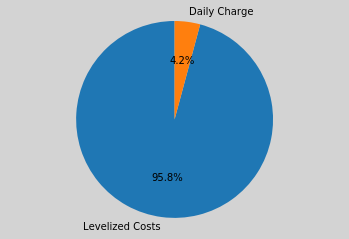

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[147.64236214163975, 181.30989390264443, 143.61882837662898, 33.875055952946404, 21.919697188447103, 33.99641411007377, 0.23451331024197672, 0.4361087794410462, 0.5852040858967793, 3176.69, 306.44100000000003, 0.0, 128.576, 177.865, {'Levelized Costs': 3043.6360000000004, 'Energy Charge': 0.011999999999886768, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60209170315, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (131.2612967570882, 189.44185913085312, 172.13603170236019, 34.277151427257024, 25.075032488667585, 34.06538818300558, 0.21266804050275961, 0.46318747827145224, 0.6293461642134536)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 131
                                           a tilt of 34.3
                                           and a gcr of 0.213


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.19606876373291 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 189
                                           a tilt of 25.1
                                           and a gcr of 0.463


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.194467544555664 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 172
                                           a tilt of 34.1
                                           and a gcr of 0.629


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1906628608703613 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 220.069, 77.8142]


ERROR:ga_logger:Cost: 3091.69


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,092 per year


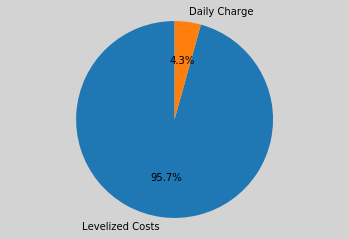

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[131.2612967570882, 189.44185913085312, 172.13603170236019, 34.277151427257024, 25.075032488667585, 34.06538818300558, 0.21266804050275961, 0.46318747827145224, 0.6293461642134536, 3091.69, 297.8832, 0.0, 220.069, 77.8142, {'Levelized Costs': 2958.64, 'Energy Charge': 0.008000000000151886, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60042667099, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (142.75603217104572, 190.0735945735983, 163.89722996693797, 33.814990068854, 19.230178312293827, 24.437192036622545, 0.2079131295948468, 0.4597081077036867, 0.6012580817832215)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 143
                                           a tilt of 33.8
                                           and a gcr of 0.208


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.299448013305664 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 19.2
                                           and a gcr of 0.460


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.154971122741699 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 164
                                           a tilt of 24.4
                                           and a gcr of 0.601


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1235690116882324 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 192.49, 108.25]


ERROR:ga_logger:Cost: 3120.07


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,120 per year


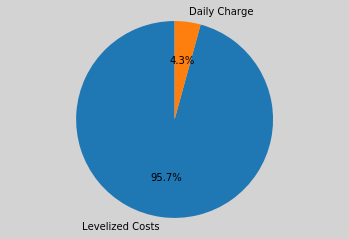

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[142.75603217104572, 190.0735945735983, 163.89722996693797, 33.814990068854, 19.230178312293827, 24.437192036622545, 0.2079131295948468, 0.4597081077036867, 0.6012580817832215, 3120.07, 300.74, 0.0, 192.49, 108.25, {'Levelized Costs': 2987.016, 'Energy Charge': 0.012000000000341515, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60422452846, 61845.7, 598.762]]


ERROR:optimizer_logger:100


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (152.52843658609802, 184.6676453267318, 169.61590667451514, 34.276999773073314, 27.972126412536788, 36.989472824140876, 0.20155477543079206, 0.48307460653438633, 0.6961066251958289)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 153
                                           a tilt of 34.3
                                           and a gcr of 0.202


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.549220085144043 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 28.0
                                           and a gcr of 0.483


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6306724548339844 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 37.0
                                           and a gcr of 0.696


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.304056406021118 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 274.462, 21.3048]


ERROR:ga_logger:Cost: 3070.67


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,071 per year


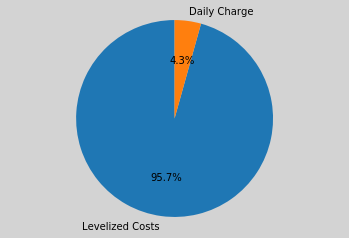

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[152.52843658609802, 184.6676453267318, 169.61590667451514, 34.276999773073314, 27.972126412536788, 36.989472824140876, 0.20155477543079206, 0.48307460653438633, 0.6961066251958289, 3070.67, 295.7668, 0.0, 274.462, 21.3048, {'Levelized Costs': 2937.606, 'Energy Charge': 0.02200000000016189, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59999486236, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (148.20097270329148, 173.48975467714004, 150.95517938850406, 33.96692009712292, 26.386235664368556, 23.821342036866948, 0.20060965193947533, 0.40461760833585514, 0.641851496375778)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 148
                                           a tilt of 34.0
                                           and a gcr of 0.201


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.2878687381744385 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 173
                                           a tilt of 26.4
                                           and a gcr of 0.405


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.131662368774414 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 151
                                           a tilt of 23.8
                                           and a gcr of 0.642


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1380631923675537 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 141.101, 160.485]


ERROR:ga_logger:Cost: 3128.47


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,128 per year


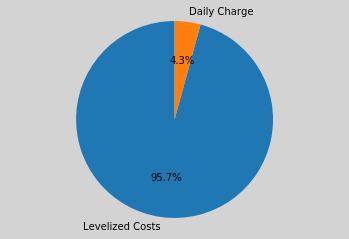

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[148.20097270329148, 173.48975467714004, 150.95517938850406, 33.96692009712292, 26.386235664368556, 23.821342036866948, 0.20060965193947533, 0.40461760833585514, 0.641851496375778, 3128.47, 301.586, 0.0, 141.101, 160.485, {'Levelized Costs': 2995.413, 'Energy Charge': 0.015000000000100044, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60085783301, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (142.10675337131363, 189.88657845403998, 164.58921297289447, 37.996101995990216, 39.28375753880273, 32.64309362083602, 0.3299560750186302, 0.46246867211036335, 0.5021412393530215)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 142
                                           a tilt of 38.0
                                           and a gcr of 0.330


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.016438007354736 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 39.3
                                           and a gcr of 0.462


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8309834003448486 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 32.6
                                           and a gcr of 0.502


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8506600856781006 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 31.0005, 267.003]


ERROR:ga_logger:Cost: 3092.89


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,093 per year


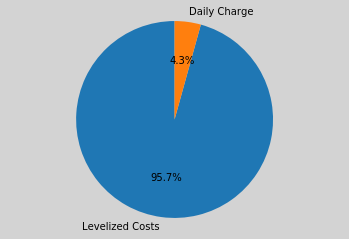

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[142.10675337131363, 189.88657845403998, 164.58921297289447, 37.996101995990216, 39.28375753880273, 32.64309362083602, 0.3299560750186302, 0.46246867211036335, 0.5021412393530215, 3092.89, 298.0035, 0.0, 31.0005, 267.003, {'Levelized Costs': 2959.83, 'Energy Charge': 0.01800000000014279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601242384226, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (132.8405189380428, 184.17996567297706, 157.28082863451675, 39.36182592578936, 10.88058497910602, 29.812264521288437, 0.20257919438226427, 0.39015009435751313, 0.6918840635984029)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 133
                                           a tilt of 39.4
                                           and a gcr of 0.203


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.991061210632324 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 184
                                           a tilt of 10.9
                                           and a gcr of 0.390


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4479191303253174 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 157
                                           a tilt of 29.8
                                           and a gcr of 0.692


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.850754499435425 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [43.0928, 0.0, 267.095]


ERROR:ga_logger:Cost: 3213.91


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,214 per year


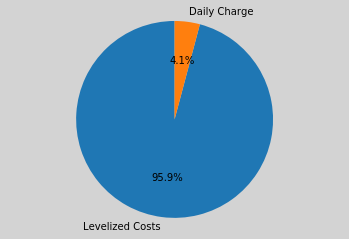

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[132.8405189380428, 184.17996567297706, 157.28082863451675, 39.36182592578936, 10.88058497910602, 29.812264521288437, 0.20257919438226427, 0.39015009435751313, 0.6918840635984029, 3213.91, 310.18780000000004, 43.0928, 0.0, 267.095, {'Levelized Costs': 3080.857, 'Energy Charge': 0.010999999999967258, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60155438498, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (181.26785407250327, 192.2522417685565, 178.97696825812343, 41.158872219675, 55.921065242830906, 32.40201277961036, 0.5195320070687146, 0.8041538229578914, 0.8657331937095623)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 181
                                           a tilt of 41.2
                                           and a gcr of 0.520


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9400861263275146 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 55.9
                                           and a gcr of 0.804


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9107272624969482 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 179
                                           a tilt of 32.4
                                           and a gcr of 0.866


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.793158769607544 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [298.656, 0.0, 0.0]


ERROR:ga_logger:Cost: 3099.37


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,099 per year


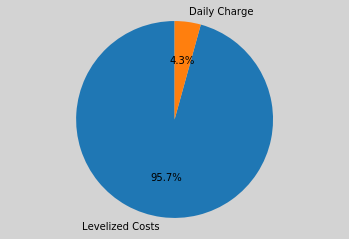

Total roof area of the  building: 599 m2
Total roof area used 575 m2
Percentage: 96.0%
succes
[[181.26785407250327, 192.2522417685565, 178.97696825812343, 41.158872219675, 55.921065242830906, 32.40201277961036, 0.5195320070687146, 0.8041538229578914, 0.8657331937095623, 3099.37, 298.656, 298.656, 0.0, 0.0, {'Levelized Costs': 2966.316, 'Energy Charge': 0.012000000000057298, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601521728124, 61845.7, 574.856]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (141.81162882000896, 186.83235050869797, 182.1611292619312, 33.31807607483169, 30.318629824531353, 25.38904553056497, 0.20098619581215443, 0.49872017854270345, 0.6922069875606789)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 142
                                           a tilt of 33.3
                                           and a gcr of 0.201


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.938486337661743 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 187
                                           a tilt of 30.3
                                           and a gcr of 0.499


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.789487361907959 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 25.4
                                           and a gcr of 0.692


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.785327196121216 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 295.285, 0.0]


ERROR:ga_logger:Cost: 3065.89


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,066 per year


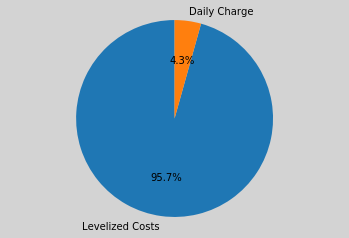

Total roof area of the  building: 599 m2
Total roof area used 592 m2
Percentage: 98.9%
succes
[[141.81162882000896, 186.83235050869797, 182.1611292619312, 33.31807607483169, 30.318629824531353, 25.38904553056497, 0.20098619581215443, 0.49872017854270345, 0.6922069875606789, 3065.89, 295.285, 0.0, 295.285, 0.0, {'Levelized Costs': 2932.8289999999997, 'Energy Charge': 0.01900000000023283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603176019205, 61845.7, 592.085]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (145.34376372056477, 194.14262320994885, 161.6188686453252, 35.62250279199106, 28.384843818608047, 39.27897257076404, 0.20719137565274637, 0.4631855587252471, 0.5765354999005596)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 35.6
                                           and a gcr of 0.207


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.011784076690674 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 194
                                           a tilt of 28.4
                                           and a gcr of 0.463


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.084397554397583 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 162
                                           a tilt of 39.3
                                           and a gcr of 0.577


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.802885055541992 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 183.454, 116.859]


ERROR:ga_logger:Cost: 3115.82


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,116 per year


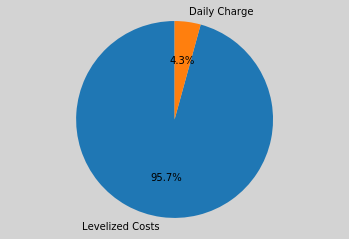

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[145.34376372056477, 194.14262320994885, 161.6188686453252, 35.62250279199106, 28.384843818608047, 39.27897257076404, 0.20719137565274637, 0.4631855587252471, 0.5765354999005596, 3115.82, 300.313, 0.0, 183.454, 116.859, {'Levelized Costs': 2982.7700000000004, 'Energy Charge': 0.007999999999981355, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60226138306, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (141.66011794502595, 200.6613579411437, 157.28082863451675, 32.89805592057121, 24.693078573199756, 28.109033160683623, 0.201338845488853, 0.46988463788778684, 0.6249704203497217)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 142
                                           a tilt of 32.9
                                           and a gcr of 0.201


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9219114780426025 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 201
                                           a tilt of 24.7
                                           and a gcr of 0.470


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8377554416656494 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 157
                                           a tilt of 28.1
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8090038299560547 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 220.997, 80.2705]


ERROR:ga_logger:Cost: 3125.31


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,125 per year


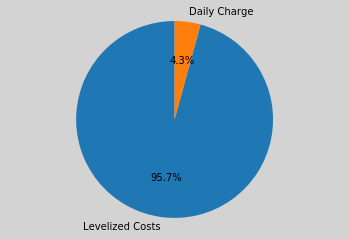

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[141.66011794502595, 200.6613579411437, 157.28082863451675, 32.89805592057121, 24.693078573199756, 28.109033160683623, 0.201338845488853, 0.46988463788778684, 0.6249704203497217, 3125.31, 301.26750000000004, 0.0, 220.997, 80.2705, {'Levelized Costs': 2992.2499999999995, 'Energy Charge': 0.018000000000427008, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60027651913, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (146.51055180004383, 185.15475576602398, 166.21680619657366, 34.45527787087043, 33.12528586524166, 37.40226061564713, 0.2693989666975906, 0.3536046282059815, 0.6938675801239461)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 147
                                           a tilt of 34.5
                                           and a gcr of 0.269


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.278898000717163 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 33.1
                                           and a gcr of 0.354


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1200668811798096 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 166
                                           a tilt of 37.4
                                           and a gcr of 0.694


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1213150024414062 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 116.299, 187.251]


ERROR:ga_logger:Cost: 3147.98


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,148 per year


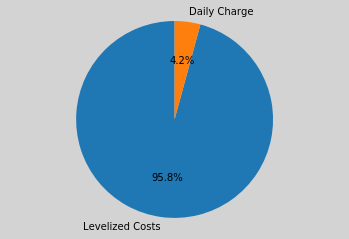

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[146.51055180004383, 185.15475576602398, 166.21680619657366, 34.45527787087043, 33.12528586524166, 37.40226061564713, 0.2693989666975906, 0.3536046282059815, 0.6938675801239461, 3147.98, 303.55, 0.0, 116.299, 187.251, {'Levelized Costs': 3014.927, 'Energy Charge': 0.011000000000080945, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59934444591, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (127.72800605085699, 181.04238790313235, 155.46861633484443, 26.436277692548316, 26.395017090978158, 21.66409690550223, 0.2005211590962988, 0.43872237005176506, 0.5000689924969666)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 128
                                           a tilt of 26.4
                                           and a gcr of 0.201


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9829509258270264 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 26.4
                                           and a gcr of 0.439


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.833564519882202 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 21.7
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.802093744277954 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 299.422]


ERROR:ga_logger:Cost: 3167.63


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0010 /kWh
Total Cost of the system: $ 3,168 per year


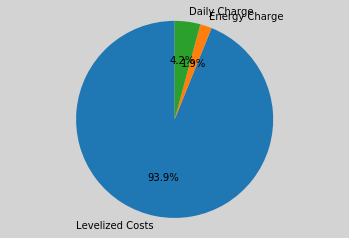

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[127.72800605085699, 181.04238790313235, 155.46861633484443, 26.436277692548316, 26.395017090978158, 21.66409690550223, 0.2005211590962988, 0.43872237005176506, 0.5000689924969666, 3167.63, 299.422, 0.0, 0.0, 299.422, {'Levelized Costs': 2973.915, 'Energy Charge': 60.673000000000116, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61361.51677717016, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (131.5876032317457, 189.44185913085312, 191.4960307260281, 36.64665023345238, 26.528442897748203, 36.325932064927386, 0.21266804050275961, 0.46318747827145224, 0.6293461642134536)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 132
                                           a tilt of 36.6
                                           and a gcr of 0.213


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.00091028213501 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 189
                                           a tilt of 26.5
                                           and a gcr of 0.463


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8239119052886963 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 191
                                           a tilt of 36.3
                                           and a gcr of 0.629


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.819328784942627 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 220.365, 77.4116]


ERROR:ga_logger:Cost: 3090.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,091 per year


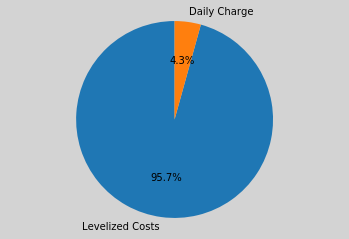

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[131.5876032317457, 189.44185913085312, 191.4960307260281, 36.64665023345238, 26.528442897748203, 36.325932064927386, 0.21266804050275961, 0.46318747827145224, 0.6293461642134536, 3090.64, 297.77660000000003, 0.0, 220.365, 77.4116, {'Levelized Costs': 2957.5840000000003, 'Energy Charge': 0.013999999999839474, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60207835966, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (131.2528171325475, 188.94367129482177, 161.02971577088323, 34.277151427257024, 28.792631744915813, 34.067329362582576, 0.21222826649573803, 0.4275184576408059, 0.6099074727641591)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 131
                                           a tilt of 34.3
                                           and a gcr of 0.212


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.060128688812256 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 189
                                           a tilt of 28.8
                                           and a gcr of 0.428


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.923973560333252 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 161
                                           a tilt of 34.1
                                           and a gcr of 0.610


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8097951412200928 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 153.694, 145.926]


ERROR:ga_logger:Cost: 3108.94


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,109 per year


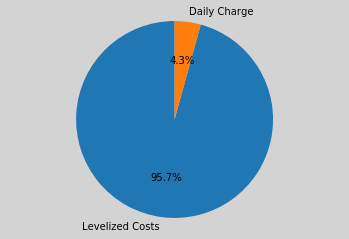

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[131.2528171325475, 188.94367129482177, 161.02971577088323, 34.277151427257024, 28.792631744915813, 34.067329362582576, 0.21222826649573803, 0.4275184576408059, 0.6099074727641591, 3108.94, 299.62, 0.0, 153.694, 145.926, {'Levelized Costs': 2975.888, 'Energy Charge': 0.010000000000104592, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60310567559, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (124.25455762021656, 190.84476544655243, 179.11797216197564, 45.00595680705575, 26.80675754178056, 30.41477158668345, 0.2749686665508501, 0.5133010288684227, 0.6384507337735466)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 124
                                           a tilt of 45.0
                                           and a gcr of 0.275


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.460461139678955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 191
                                           a tilt of 26.8
                                           and a gcr of 0.513


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.786519765853882 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 179
                                           a tilt of 30.4
                                           and a gcr of 0.638


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7937943935394287 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 297.079, 0.0]


ERROR:ga_logger:Cost: 3083.7


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,084 per year


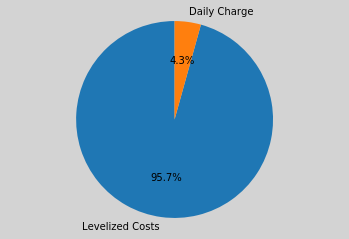

Total roof area of the  building: 599 m2
Total roof area used 579 m2
Percentage: 96.7%
succes
[[124.25455762021656, 190.84476544655243, 179.11797216197564, 45.00595680705575, 26.80675754178056, 30.41477158668345, 0.2749686665508501, 0.5133010288684227, 0.6384507337735466, 3083.7, 297.079, 0.0, 297.079, 0.0, {'Levelized Costs': 2950.644, 'Energy Charge': 0.014000000000180535, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60257602816, 61845.7, 578.761]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (121.15265876291525, 154.41181919980284, 166.08089003107565, 8.45195634088298, 2.413859543087426, 25.041405070663387, 0.2548758194757624, 0.45072128152670476, 0.5631721251545994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 121
                                           a tilt of 8.5
                                           and a gcr of 0.255


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.991767644882202 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 154
                                           a tilt of 2.4
                                           and a gcr of 0.451


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.675687074661255 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 166
                                           a tilt of 25.0
                                           and a gcr of 0.563


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.779287576675415 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 299.734]


ERROR:ga_logger:Cost: 3110.07


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,110 per year


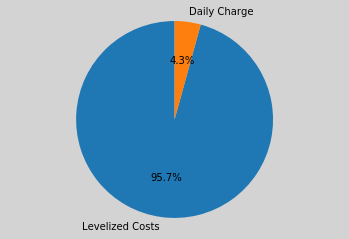

Total roof area of the  building: 599 m2
Total roof area used 532 m2
Percentage: 88.9%
succes
[[121.15265876291525, 154.41181919980284, 166.08089003107565, 8.45195634088298, 2.413859543087426, 25.041405070663387, 0.2548758194757624, 0.45072128152670476, 0.5631721251545994, 3110.07, 299.734, 0.0, 0.0, 299.734, {'Levelized Costs': 2977.0170000000003, 'Energy Charge': 0.011000000000194632, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602094500086, 61845.7, 532.224]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (168.35755217380836, 182.78863396519364, 169.1674761573492, 37.35897556618999, 32.69410740995234, 36.96773121005567, 0.2011866139107112, 0.5258042394139378, 0.6610932476192348)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 168
                                           a tilt of 37.4
                                           and a gcr of 0.201


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.08182692527771 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 32.7
                                           and a gcr of 0.526


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.763969659805298 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 37.0
                                           and a gcr of 0.661


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.783510446548462 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [12.1782, 283.004, 0.0]


ERROR:ga_logger:Cost: 3064.86


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,065 per year


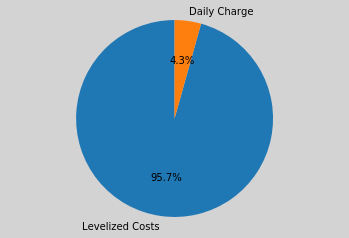

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[168.35755217380836, 182.78863396519364, 169.1674761573492, 37.35897556618999, 32.69410740995234, 36.96773121005567, 0.2011866139107112, 0.5258042394139378, 0.6610932476192348, 3064.86, 295.1822, 12.1782, 283.004, 0.0, {'Levelized Costs': 2931.8070000000002, 'Energy Charge': 0.010999999999910415, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60316254044, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (138.74529116147502, 172.22839217207476, 166.2848268780586, 27.465618748792995, 20.40731712411171, 36.287033753145394, 0.20060965193947533, 0.46318747827145224, 0.6455679007380397)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 139
                                           a tilt of 27.5
                                           and a gcr of 0.201


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.0801050662994385 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 172
                                           a tilt of 20.4
                                           and a gcr of 0.463


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.792412757873535 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 166
                                           a tilt of 36.3
                                           and a gcr of 0.646


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8064050674438477 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 217.249, 83.7508]


ERROR:ga_logger:Cost: 3122.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,123 per year


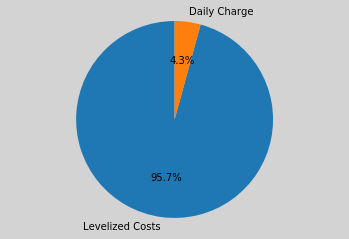

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[138.74529116147502, 172.22839217207476, 166.2848268780586, 27.465618748792995, 20.40731712411171, 36.287033753145394, 0.20060965193947533, 0.46318747827145224, 0.6455679007380397, 3122.64, 300.9998, 0.0, 217.249, 83.7508, {'Levelized Costs': 2989.579, 'Energy Charge': 0.019000000000005457, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599368400086, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (147.24922265905462, 182.15781547278723, 168.30820653514024, 38.221987225354056, 33.69591085573132, 23.461198687201694, 0.20180123062308833, 0.49872017854270345, 0.7814321975124903)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 147
                                           a tilt of 38.2
                                           and a gcr of 0.202


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.082061290740967 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 33.7
                                           and a gcr of 0.499


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.772538900375366 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 23.5
                                           and a gcr of 0.781


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7650341987609863 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 294.635, 0.0]


ERROR:ga_logger:Cost: 3059.43


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,059 per year


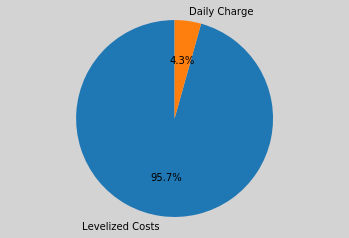

Total roof area of the  building: 599 m2
Total roof area used 591 m2
Percentage: 98.7%
succes
[[147.24922265905462, 182.15781547278723, 168.30820653514024, 38.221987225354056, 33.69591085573132, 23.461198687201694, 0.20180123062308833, 0.49872017854270345, 0.7814321975124903, 3059.43, 294.635, 0.0, 294.635, 0.0, {'Levelized Costs': 2926.3779999999997, 'Energy Charge': 0.010000000000218279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59933119027, 61845.7, 590.781]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (128.39734335190147, 169.5456759722804, 154.0344693064136, 34.51663477005947, 26.352856695635783, 23.19079255432086, 0.23325911527645846, 0.44677033785435, 0.644407334661136)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 128
                                           a tilt of 34.5
                                           and a gcr of 0.233


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.388765096664429 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 26.4
                                           and a gcr of 0.447


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1109249591827393 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 154
                                           a tilt of 23.2
                                           and a gcr of 0.644


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2022905349731445 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 195.504, 103.858]


ERROR:ga_logger:Cost: 3106.38


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,106 per year


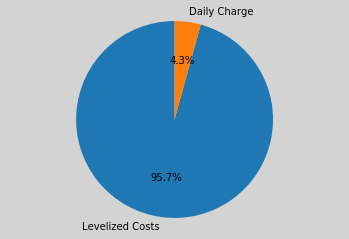

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[128.39734335190147, 169.5456759722804, 154.0344693064136, 34.51663477005947, 26.352856695635783, 23.19079255432086, 0.23325911527645846, 0.44677033785435, 0.644407334661136, 3106.38, 299.36199999999997, 0.0, 195.504, 103.858, {'Levelized Costs': 2973.3199999999997, 'Energy Charge': 0.018000000000427008, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60066387996, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (144.8101436036456, 212.61594712031143, 167.2181522438127, 34.00407708279979, 31.23745465872985, 35.29575958836327, 0.21665344487435526, 0.5425150022190144, 0.7004478361150923)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 34.0
                                           and a gcr of 0.217


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.102156400680542 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 213
                                           a tilt of 31.2
                                           and a gcr of 0.543


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.801553726196289 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 167
                                           a tilt of 35.3
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.802656412124634 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [49.9766, 0.0, 257.825]


ERROR:ga_logger:Cost: 3190.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,190 per year


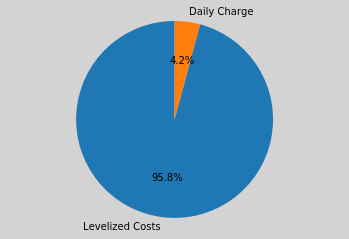

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[144.8101436036456, 212.61594712031143, 167.2181522438127, 34.00407708279979, 31.23745465872985, 35.29575958836327, 0.21665344487435526, 0.5425150022190144, 0.7004478361150923, 3190.21, 307.8016, 49.9766, 0.0, 257.825, {'Levelized Costs': 3057.155, 'Energy Charge': 0.013000000000090495, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60137766606, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (132.57599225840858, 184.19910153954643, 155.46861633484443, 24.182977585435786, 25.89263787508516, 27.001278424349227, 0.20156614867858993, 0.4098268946062601, 0.680911925977164)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 133
                                           a tilt of 24.2
                                           and a gcr of 0.202


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.086342096328735 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 184
                                           a tilt of 25.9
                                           and a gcr of 0.410


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7692508697509766 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 27.0
                                           and a gcr of 0.681


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7723193168640137 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [0.0, 161.26, 139.776]


ERROR:ga_logger:Cost: 3123.01


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,123 per year


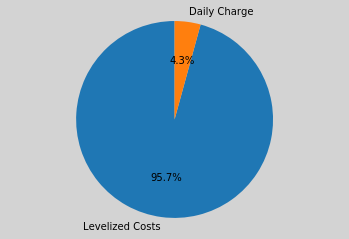

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[132.57599225840858, 184.19910153954643, 155.46861633484443, 24.182977585435786, 25.89263787508516, 27.001278424349227, 0.20156614867858993, 0.4098268946062601, 0.680911925977164, 3123.01, 301.036, 0.0, 161.26, 139.776, {'Levelized Costs': 2989.951, 'Energy Charge': 0.017000000000336968, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602231152014, 61845.7, 598.762]]


ERROR:optimizer_logger:120


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (143.09679697618466, 184.10761107894098, 175.7500357616827, 41.743369928820506, 25.637367047371377, 35.58375076639166, 0.3108952893238453, 0.5330897914642528, 0.7344563572420445)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 143
                                           a tilt of 41.7
                                           and a gcr of 0.311


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.236800909042358 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 184
                                           a tilt of 25.6
                                           and a gcr of 0.533


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8261311054229736 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 176
                                           a tilt of 35.6
                                           and a gcr of 0.734


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.783238172531128 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 296.443, 0.0]


ERROR:ga_logger:Cost: 3077.39


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,077 per year


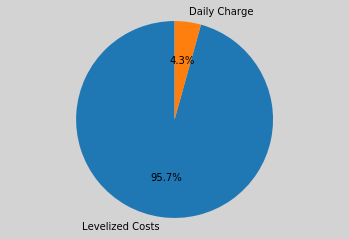

Total roof area of the  building: 599 m2
Total roof area used 556 m2
Percentage: 92.9%
succes
[[143.09679697618466, 184.10761107894098, 175.7500357616827, 41.743369928820506, 25.637367047371377, 35.58375076639166, 0.3108952893238453, 0.5330897914642528, 0.7344563572420445, 3077.39, 296.443, 0.0, 296.443, 0.0, {'Levelized Costs': 2944.333, 'Energy Charge': 0.015000000000100044, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60098038505, 61845.7, 556.085]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (132.6656878183382, 153.78582431416518, 155.51201519611325, 32.53682508325931, 24.87163346326376, 28.099337462926076, 0.20060965193947533, 0.46318747827145224, 0.6497489635159052)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 133
                                           a tilt of 32.5
                                           and a gcr of 0.201


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.0914928913116455 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 154
                                           a tilt of 24.9
                                           and a gcr of 0.463


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7621564865112305 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 156
                                           a tilt of 28.1
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8040504455566406 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 215.016, 87.4248]


ERROR:ga_logger:Cost: 3136.96


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,137 per year


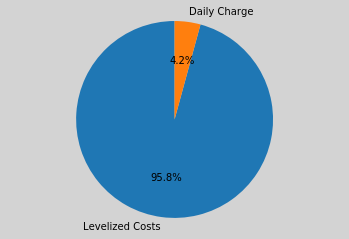

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[132.6656878183382, 153.78582431416518, 155.51201519611325, 32.53682508325931, 24.87163346326376, 28.099337462926076, 0.20060965193947533, 0.46318747827145224, 0.6497489635159052, 3136.96, 302.44079999999997, 0.0, 215.016, 87.4248, {'Levelized Costs': 3003.9069999999997, 'Energy Charge': 0.011000000000194632, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59992899492, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (134.00394931080442, 184.0939132152901, 199.20846085135867, 34.277151427257024, 28.561010976115618, 39.16900802423315, 0.2295578114603612, 0.5297806201047951, 0.7351462977526129)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 134
                                           a tilt of 34.3
                                           and a gcr of 0.230


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.113434314727783 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 184
                                           a tilt of 28.6
                                           and a gcr of 0.530


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.773629903793335 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 199
                                           a tilt of 39.2
                                           and a gcr of 0.735


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.757087469100952 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 121 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 295.701, 0.0]


ERROR:ga_logger:Cost: 3070.02


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,070 per year


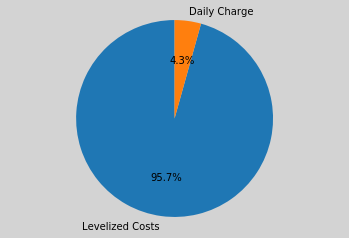

Total roof area of the  building: 599 m2
Total roof area used 558 m2
Percentage: 93.2%
succes
[[134.00394931080442, 184.0939132152901, 199.20846085135867, 34.277151427257024, 28.561010976115618, 39.16900802423315, 0.2295578114603612, 0.5297806201047951, 0.7351462977526129, 3070.02, 295.701, 0.0, 295.701, 0.0, {'Levelized Costs': 2936.962, 'Energy Charge': 0.015999999999849024, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601270583174, 61845.7, 558.157]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (133.71112503851336, 168.91525332008652, 169.2517159120833, 33.31807607483169, 27.28521209428977, 23.461198687201694, 0.20119781795542752, 0.46802489253404705, 0.6477856181842572)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 134
                                           a tilt of 33.3
                                           and a gcr of 0.201


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.044262647628784 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 169
                                           a tilt of 27.3
                                           and a gcr of 0.468


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.705859661102295 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 23.5
                                           and a gcr of 0.648


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7360434532165527 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [0.0, 236.323, 60.7778]


ERROR:ga_logger:Cost: 3083.93


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,084 per year


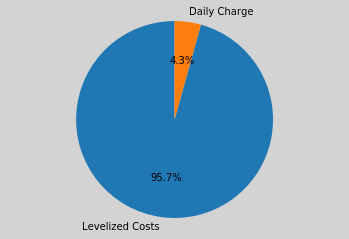

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[133.71112503851336, 168.91525332008652, 169.2517159120833, 33.31807607483169, 27.28521209428977, 23.461198687201694, 0.20119781795542752, 0.46802489253404705, 0.6477856181842572, 3083.93, 297.1008, 0.0, 236.323, 60.7778, {'Levelized Costs': 2950.8759999999997, 'Energy Charge': 0.012000000000341515, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60372325011, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (168.81741696464698, 163.9582752223955, 164.53135410362196, 34.40766028891766, 34.19701725646617, 37.55241005652912, 0.24864493434770235, 0.5258042394139378, 0.6762384738132002)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 169
                                           a tilt of 34.4
                                           and a gcr of 0.249


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.0882837772369385 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 164
                                           a tilt of 34.2
                                           and a gcr of 0.526


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.709502696990967 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 37.6
                                           and a gcr of 0.676


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7175488471984863 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [13.7988, 285.651, 0.0]


ERROR:ga_logger:Cost: 3107.26


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,107 per year


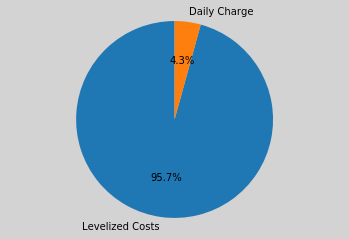

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[168.81741696464698, 163.9582752223955, 164.53135410362196, 34.40766028891766, 34.19701725646617, 37.55241005652912, 0.24864493434770235, 0.5258042394139378, 0.6762384738132002, 3107.26, 299.4498, 13.7988, 285.651, 0.0, {'Levelized Costs': 2974.199, 'Energy Charge': 0.019000000000346517, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60256059995, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (159.34597710873157, 181.46888213195024, 169.17798166631857, 34.276999773073314, 18.952575813672702, 36.96730957532374, 0.20118097871860924, 0.4070424492281323, 0.6272292525924429)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 159
                                           a tilt of 34.3
                                           and a gcr of 0.201


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.14358925819397 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 19.0
                                           and a gcr of 0.407


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0446689128875732 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 37.0
                                           and a gcr of 0.627


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.710242986679077 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Can not solve this model correctly.


succes
[[159.34597710873157, 181.46888213195024, 169.17798166631857, 34.276999773073314, 18.952575813672702, 36.96730957532374, 0.20118097871860924, 0.4070424492281323, 0.6272292525924429, 90000000000, 0, 0.0, 0.0, 0.0, {'Levelized Costs': 0, 'Energy Charge': 10000000000, 'Demand Charge': 0, 'Daily Charge': 0}, 90000000000, 90000000000, 0]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (168.55392301548395, 196.55265713267036, 148.37147169771606, 33.814990068854, 30.275868468629525, 36.02551433503631, 0.21065327240014448, 0.4398565913265502, 0.7909434742356619)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 169
                                           a tilt of 33.8
                                           and a gcr of 0.211


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.132464170455933 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 197
                                           a tilt of 30.3
                                           and a gcr of 0.440


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9809935092926025 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 148
                                           a tilt of 36.0
                                           and a gcr of 0.791


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.733811855316162 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 209.243, 97.3288]


ERROR:ga_logger:Cost: 3177.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,178 per year


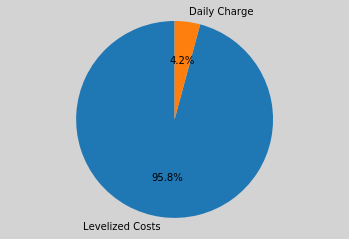

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[168.55392301548395, 196.55265713267036, 148.37147169771606, 33.814990068854, 30.275868468629525, 36.02551433503631, 0.21065327240014448, 0.4398565913265502, 0.7909434742356619, 3177.99, 306.5718, 0.0, 209.243, 97.3288, {'Levelized Costs': 3044.9329999999995, 'Energy Charge': 0.015000000000213731, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60324852117, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (131.95967491856396, 182.2593084408536, 174.33951762210003, 33.11921260955673, 27.03185885991285, 21.415327729194324, 0.20044811761041398, 0.5001037927535747, 0.6354620764424199)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 132
                                           a tilt of 33.1
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.1421449184417725 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 27.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.828587055206299 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 174
                                           a tilt of 21.4
                                           and a gcr of 0.635


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7084333896636963 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 294.955, 0.0]


ERROR:ga_logger:Cost: 3062.61


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,063 per year


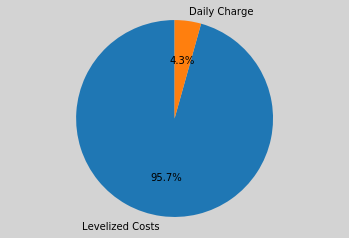

Total roof area of the  building: 599 m2
Total roof area used 590 m2
Percentage: 98.5%
succes
[[131.95967491856396, 182.2593084408536, 174.33951762210003, 33.11921260955673, 27.03185885991285, 21.415327729194324, 0.20044811761041398, 0.5001037927535747, 0.6354620764424199, 3062.61, 294.955, 0.0, 294.955, 0.0, {'Levelized Costs': 2929.555, 'Energy Charge': 0.013000000000204182, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60176750963, 61845.7, 589.787]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (133.51254068686382, 183.04998739699514, 171.2707535494703, 33.48283981583715, 26.926867757080554, 41.651369695220446, 0.2240484847745675, 0.507059522514575, 0.650981681130358)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 134
                                           a tilt of 33.5
                                           and a gcr of 0.224


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.149065256118774 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 26.9
                                           and a gcr of 0.507


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7601318359375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 171
                                           a tilt of 41.7
                                           and a gcr of 0.651


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7614951133728027 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 295.265, 0.0]


ERROR:ga_logger:Cost: 3065.69


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,066 per year


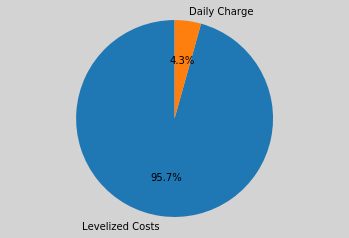

Total roof area of the  building: 599 m2
Total roof area used 582 m2
Percentage: 97.3%
succes
[[133.51254068686382, 183.04998739699514, 171.2707535494703, 33.48283981583715, 26.926867757080554, 41.651369695220446, 0.2240484847745675, 0.507059522514575, 0.650981681130358, 3065.69, 295.265, 0.0, 295.265, 0.0, {'Levelized Costs': 2932.641, 'Energy Charge': 0.007000000000061846, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602004914625, 61845.7, 582.308]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (131.9658325547713, 131.81516457131875, 161.6188686453252, 30.52559116092726, 26.030112199402996, 29.77000409916717, 0.21109421175598925, 0.4621117991009049, 0.6216661787277968)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 132
                                           a tilt of 30.5
                                           and a gcr of 0.211


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.134417533874512 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 132
                                           a tilt of 26.0
                                           and a gcr of 0.462


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6930181980133057 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 162
                                           a tilt of 29.8
                                           and a gcr of 0.622


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7615549564361572 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 304.087]


ERROR:ga_logger:Cost: 3153.31


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,153 per year


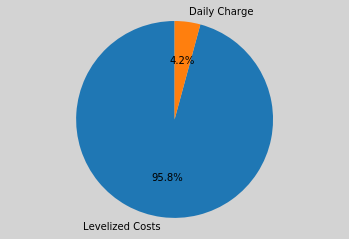

Total roof area of the  building: 599 m2
Total roof area used 489 m2
Percentage: 81.7%
succes
[[131.9658325547713, 131.81516457131875, 161.6188686453252, 30.52559116092726, 26.030112199402996, 29.77000409916717, 0.21109421175598925, 0.4621117991009049, 0.6216661787277968, 3153.31, 304.087, 0.0, 0.0, 304.087, {'Levelized Costs': 3020.255, 'Energy Charge': 0.013000000000090495, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602773400016, 61845.7, 489.149]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (138.354832483909, 189.44185913085312, 191.4960307260281, 36.64665023345238, 32.41549687371184, 36.325932064927386, 0.23227581218689985, 0.49789560115533404, 0.6757804548060572)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 138
                                           a tilt of 36.6
                                           and a gcr of 0.232


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.134967565536499 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 189
                                           a tilt of 32.4
                                           and a gcr of 0.498


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7098424434661865 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 191
                                           a tilt of 36.3
                                           and a gcr of 0.676


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.93780255317688 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 295.967, 0.0]


ERROR:ga_logger:Cost: 3072.66


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,073 per year


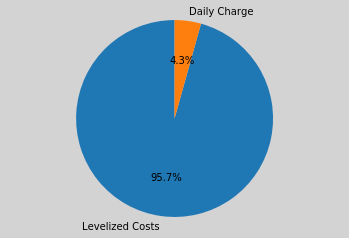

Total roof area of the  building: 599 m2
Total roof area used 594 m2
Percentage: 99.3%
succes
[[138.354832483909, 189.44185913085312, 191.4960307260281, 36.64665023345238, 32.41549687371184, 36.325932064927386, 0.23227581218689985, 0.49789560115533404, 0.6757804548060572, 3072.66, 295.967, 0.0, 295.967, 0.0, {'Levelized Costs': 2939.6009999999997, 'Energy Charge': 0.017000000000166438, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599810619344, 61845.7, 594.436]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (136.4505713605054, 187.37535395324667, 165.47173168840888, 34.080889921331064, 6.732479039109801, 21.767309361995956, 0.21250462534630732, 0.47677484441377926, 0.628658624278229)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 136
                                           a tilt of 34.1
                                           and a gcr of 0.213


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.1894004344940186 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 187
                                           a tilt of 6.7
                                           and a gcr of 0.477


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7495062351226807 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 21.8
                                           and a gcr of 0.629


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7407946586608887 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 121 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [37.4178, 0.0, 265.723]


ERROR:ga_logger:Cost: 3143.91


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,144 per year


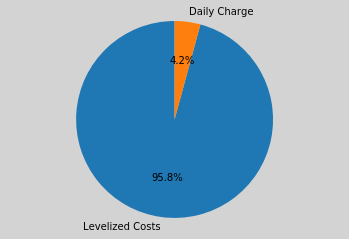

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[136.4505713605054, 187.37535395324667, 165.47173168840888, 34.080889921331064, 6.732479039109801, 21.767309361995956, 0.21250462534630732, 0.47677484441377926, 0.628658624278229, 3143.91, 303.1408, 37.4178, 0.0, 265.723, {'Levelized Costs': 3010.843, 'Energy Charge': 0.02500000000009095, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599959465995, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130.58574939972897, 179.2514465117283, 177.70406503838583, 38.619621794760285, 33.37499172251732, 38.332739099540674, 0.2214888100404535, 0.5441303952632575, 0.7823591719147804)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 131
                                           a tilt of 38.6
                                           and a gcr of 0.221


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.161881923675537 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 179
                                           a tilt of 33.4
                                           and a gcr of 0.544


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.701479911804199 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 38.3
                                           and a gcr of 0.782


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.708486318588257 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 297.389, 0.0]


ERROR:ga_logger:Cost: 3086.79


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,087 per year


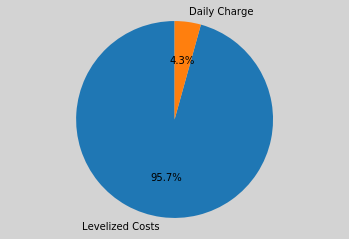

Total roof area of the  building: 599 m2
Total roof area used 547 m2
Percentage: 91.3%
succes
[[130.58574939972897, 179.2514465117283, 177.70406503838583, 38.619621794760285, 33.37499172251732, 38.332739099540674, 0.2214888100404535, 0.5441303952632575, 0.7823591719147804, 3086.79, 297.389, 0.0, 297.389, 0.0, {'Levelized Costs': 2953.7369999999996, 'Energy Charge': 0.011000000000194632, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60209830006, 61845.7, 546.541]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (113.94933662838805, 177.2809120517279, 168.28751775417098, 31.129401734093243, 26.707154797582554, 26.34646962621628, 0.20269923695570835, 0.49438059053134054, 0.6334106761489992)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 114
                                           a tilt of 31.1
                                           and a gcr of 0.203


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.190160751342773 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 177
                                           a tilt of 26.7
                                           and a gcr of 0.494


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7499125003814697 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 26.3
                                           and a gcr of 0.633


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.724307060241699 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 121 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 295.7, 0.0]


ERROR:ga_logger:Cost: 3070.01


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,070 per year


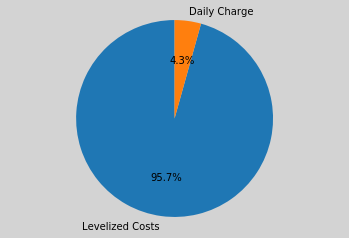

Total roof area of the  building: 599 m2
Total roof area used 598 m2
Percentage: 99.9%
succes
[[113.94933662838805, 177.2809120517279, 168.28751775417098, 31.129401734093243, 26.707154797582554, 26.34646962621628, 0.20269923695570835, 0.49438059053134054, 0.6334106761489992, 3070.01, 295.7, 0.0, 295.7, 0.0, {'Levelized Costs': 2936.962, 'Energy Charge': 0.006000000000426553, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60264046012, 61845.7, 598.122]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (132.49826533702645, 186.31144037459887, 185.6237852167972, 54.62760449397881, 31.53288362747948, 30.47068407836277, 0.2289096858989859, 0.5321995573531909, 0.6537835990207725)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 132
                                           a tilt of 54.6
                                           and a gcr of 0.229


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.183773994445801 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 186
                                           a tilt of 31.5
                                           and a gcr of 0.532


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7081127166748047 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 186
                                           a tilt of 30.5
                                           and a gcr of 0.654


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.703669786453247 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 296.214, 0.0]


ERROR:ga_logger:Cost: 3075.12


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,075 per year


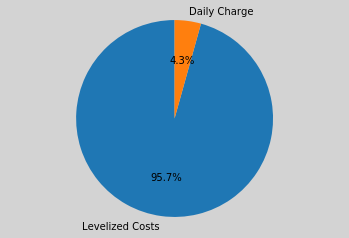

Total roof area of the  building: 599 m2
Total roof area used 557 m2
Percentage: 93.0%
succes
[[132.49826533702645, 186.31144037459887, 185.6237852167972, 54.62760449397881, 31.53288362747948, 30.47068407836277, 0.2289096858989859, 0.5321995573531909, 0.6537835990207725, 3075.12, 296.214, 0.0, 296.214, 0.0, {'Levelized Costs': 2942.0660000000003, 'Energy Charge': 0.011999999999886768, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60025145382, 61845.7, 556.585]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (112.44979570862878, 164.05592499458933, 175.7500357616827, 41.490403760752926, 25.939465505790253, 23.588702123157034, 0.2741875711498309, 0.5275813247578266, 0.6386889815554416)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 112
                                           a tilt of 41.5
                                           and a gcr of 0.274


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.501229763031006 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 164
                                           a tilt of 25.9
                                           and a gcr of 0.528


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6969096660614014 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 176
                                           a tilt of 23.6
                                           and a gcr of 0.639


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7177813053131104 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 298.779, 0.0]


ERROR:ga_logger:Cost: 3100.59


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,101 per year


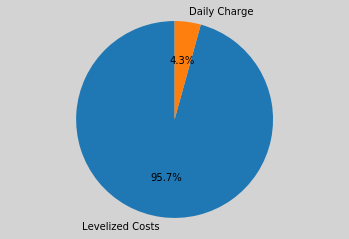

Total roof area of the  building: 599 m2
Total roof area used 566 m2
Percentage: 94.6%
succes
[[112.44979570862878, 164.05592499458933, 175.7500357616827, 41.490403760752926, 25.939465505790253, 23.588702123157034, 0.2741875711498309, 0.5275813247578266, 0.6386889815554416, 3100.59, 298.779, 0.0, 298.779, 0.0, {'Levelized Costs': 2967.5350000000003, 'Energy Charge': 0.013000000000033651, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60281900008, 61845.7, 566.318]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (154.79627498557466, 169.64365349316907, 188.1922449291314, 46.54965354762177, 27.897003048979087, 37.83926451823669, 0.3583229035418132, 0.549313656486915, 0.6589982374076927)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 46.5
                                           and a gcr of 0.358


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.179793357849121 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 27.9
                                           and a gcr of 0.549


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6908926963806152 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 188
                                           a tilt of 37.8
                                           and a gcr of 0.659


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6959950923919678 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 298.124, 0.0]


ERROR:ga_logger:Cost: 3094.08


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,094 per year


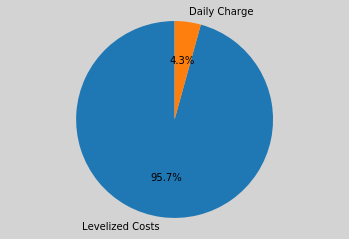

Total roof area of the  building: 599 m2
Total roof area used 543 m2
Percentage: 90.6%
succes
[[154.79627498557466, 169.64365349316907, 188.1922449291314, 46.54965354762177, 27.897003048979087, 37.83926451823669, 0.3583229035418132, 0.549313656486915, 0.6589982374076927, 3094.08, 298.124, 0.0, 298.124, 0.0, {'Levelized Costs': 2961.0280000000002, 'Energy Charge': 0.009999999999877218, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60241561987, 61845.7, 542.72]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (128.67902934062246, 183.71241206573313, 167.42942657843633, 34.276999773073314, 26.881880905338264, 26.998357065217505, 0.21384643425684827, 0.7209799006111863, 0.6343088579709945)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 129
                                           a tilt of 34.3
                                           and a gcr of 0.214


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.216435194015503 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 184
                                           a tilt of 26.9
                                           and a gcr of 0.721


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0955567359924316 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 167
                                           a tilt of 27.0
                                           and a gcr of 0.634


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.718035936355591 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 302.321]


ERROR:ga_logger:Cost: 3135.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,136 per year


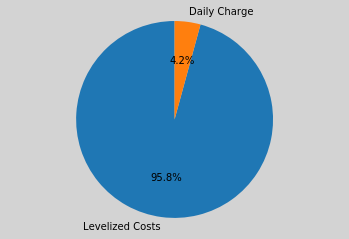

Total roof area of the  building: 599 m2
Total roof area used 477 m2
Percentage: 79.6%
succes
[[128.67902934062246, 183.71241206573313, 167.42942657843633, 34.276999773073314, 26.881880905338264, 26.998357065217505, 0.21384643425684827, 0.7209799006111863, 0.6343088579709945, 3135.77, 302.321, 0.0, 0.0, 302.321, {'Levelized Costs': 3002.708, 'Energy Charge': 0.020000000000209184, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60343170006, 61845.7, 476.615]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (141.81162882000896, 187.34341960878496, 182.1611292619312, 45.8343936198664, 30.318629824531353, 30.47573861489677, 0.2439735090807289, 0.5329072604851112, 0.6421924344772925)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 142
                                           a tilt of 45.8
                                           and a gcr of 0.244


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.375851631164551 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 187
                                           a tilt of 30.3
                                           and a gcr of 0.533


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8223330974578857 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 30.5
                                           and a gcr of 0.642


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.365211009979248 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 296.402, 0.0]


ERROR:ga_logger:Cost: 3076.98


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,077 per year


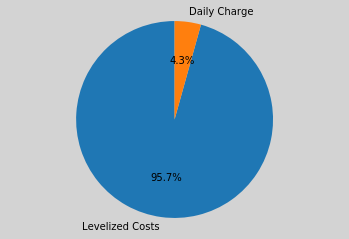

Total roof area of the  building: 599 m2
Total roof area used 556 m2
Percentage: 92.9%
succes
[[141.81162882000896, 187.34341960878496, 182.1611292619312, 45.8343936198664, 30.318629824531353, 30.47573861489677, 0.2439735090807289, 0.5329072604851112, 0.6421924344772925, 3076.98, 296.402, 0.0, 296.402, 0.0, {'Levelized Costs': 2943.93, 'Energy Charge': 0.00800000000037926, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601865349556, 61845.7, 556.199]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (136.76777770504702, 192.36942989106447, 172.15308293915416, 22.92562498376799, 26.80675754178056, 25.188604058606728, 0.22262114054565568, 0.5263378631794704, 0.6251552344297876)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 137
                                           a tilt of 22.9
                                           and a gcr of 0.223


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.356067895889282 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 26.8
                                           and a gcr of 0.526


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8784267902374268 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 172
                                           a tilt of 25.2
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.721247434616089 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 297.843, 0.0]


ERROR:ga_logger:Cost: 3091.3


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,091 per year


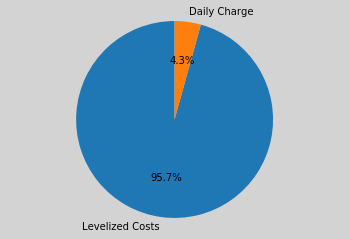

Total roof area of the  building: 599 m2
Total roof area used 566 m2
Percentage: 94.5%
succes
[[136.76777770504702, 192.36942989106447, 172.15308293915416, 22.92562498376799, 26.80675754178056, 25.188604058606728, 0.22262114054565568, 0.5263378631794704, 0.6251552344297876, 3091.3, 297.843, 0.0, 297.843, 0.0, {'Levelized Costs': 2958.2400000000002, 'Energy Charge': 0.017999999999915417, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59907312685, 61845.7, 565.879]]


ERROR:optimizer_logger:140


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (163.99151881882435, 160.8697573631487, 204.7468442249317, 36.64665023345238, 46.8075789280019, 36.325932064927386, 0.3897818673193895, 0.48105813388038726, 0.6970024017153401)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


Found the solver set


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 164
                                           a tilt of 36.6
                                           and a gcr of 0.390


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.374541282653809 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 161
                                           a tilt of 46.8
                                           and a gcr of 0.481


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.786924362182617 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 36.3
                                           and a gcr of 0.697


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7856435775756836 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [140.279, 0.0, 166.493]


ERROR:ga_logger:Cost: 3179.98


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,180 per year


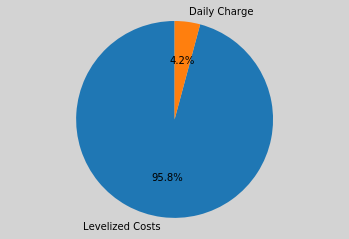

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[163.99151881882435, 160.8697573631487, 204.7468442249317, 36.64665023345238, 46.8075789280019, 36.325932064927386, 0.3897818673193895, 0.48105813388038726, 0.6970024017153401, 3179.98, 306.772, 140.279, 0.0, 166.493, {'Levelized Costs': 3046.9269999999997, 'Energy Charge': 0.011000000000308319, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60218789912, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (135.81877541883054, 164.40456188890525, 139.40359057975007, 33.96676844293922, 32.180925935564844, 12.920194408917093, 0.2026922974061212, 0.44020546099063335, 0.6858714202860732)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 136
                                           a tilt of 34.0
                                           and a gcr of 0.203


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.450044393539429 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 164
                                           a tilt of 32.2
                                           and a gcr of 0.440


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.771369457244873 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 139
                                           a tilt of 12.9
                                           and a gcr of 0.686


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7455766201019287 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 192.552, 110.664]


ERROR:ga_logger:Cost: 3144.66


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,145 per year


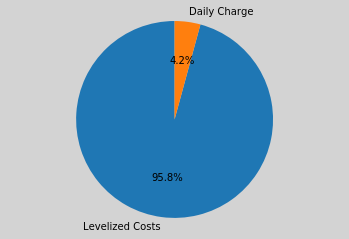

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[135.81877541883054, 164.40456188890525, 139.40359057975007, 33.96676844293922, 32.180925935564844, 12.920194408917093, 0.2026922974061212, 0.44020546099063335, 0.6858714202860732, 3144.66, 303.216, 0.0, 192.552, 110.664, {'Levelized Costs': 3011.6150000000002, 'Energy Charge': 0.0029999999999290594, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60204316476, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (197.44186561703077, 191.13066305799194, 172.5867017375197, 40.06140429990248, 33.018874848770764, 37.548929631380936, 0.20668763966682882, 0.5238306744580017, 0.6610945186761199)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 197
                                           a tilt of 40.1
                                           and a gcr of 0.207


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.381420612335205 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 191
                                           a tilt of 33.0
                                           and a gcr of 0.524


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.080447196960449 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 173
                                           a tilt of 37.5
                                           and a gcr of 0.661


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.730898141860962 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [10.662, 286.628, 0.0]


ERROR:ga_logger:Cost: 3085.8


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,086 per year


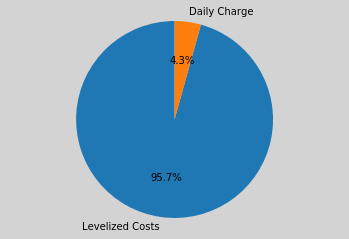

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[197.44186561703077, 191.13066305799194, 172.5867017375197, 40.06140429990248, 33.018874848770764, 37.548929631380936, 0.20668763966682882, 0.5238306744580017, 0.6610945186761199, 3085.8, 297.28999999999996, 10.662, 286.628, 0.0, {'Levelized Costs': 2952.744, 'Energy Charge': 0.014000000000294222, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60095796884, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (140.56575583337477, 186.23967977132975, 172.84075318398413, 34.31380715286492, 26.70709142109442, 20.080136288791586, 0.20057975745811435, 0.5035065654462049, 0.6526145102930782)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 141
                                           a tilt of 34.3
                                           and a gcr of 0.201


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.412791013717651 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 186
                                           a tilt of 26.7
                                           and a gcr of 0.504


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7976040840148926 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 173
                                           a tilt of 20.1
                                           and a gcr of 0.653


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.788316249847412 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 295.804, 0.0]


ERROR:ga_logger:Cost: 3071.05


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,071 per year


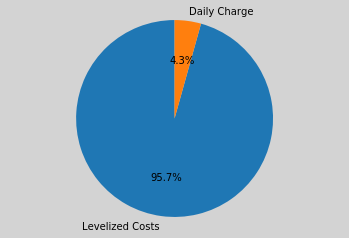

Total roof area of the  building: 599 m2
Total roof area used 587 m2
Percentage: 98.1%
succes
[[140.56575583337477, 186.23967977132975, 172.84075318398413, 34.31380715286492, 26.70709142109442, 20.080136288791586, 0.20057975745811435, 0.5035065654462049, 0.6526145102930782, 3071.05, 295.804, 0.0, 295.804, 0.0, {'Levelized Costs': 2938.001, 'Energy Charge': 0.007000000000232376, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601190670925, 61845.7, 587.489]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (136.58406499944738, 197.95741544917846, 174.4811038391897, 44.78734647909988, 27.03185885991285, 32.28109101294615, 0.30901224933642474, 0.5348068795490332, 0.618439225497324)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 137
                                           a tilt of 44.8
                                           and a gcr of 0.309


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.777748346328735 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 198
                                           a tilt of 27.0
                                           and a gcr of 0.535


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7236502170562744 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 174
                                           a tilt of 32.3
                                           and a gcr of 0.618


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8195858001708984 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 299.862, 0.0]


ERROR:ga_logger:Cost: 3111.35


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,111 per year


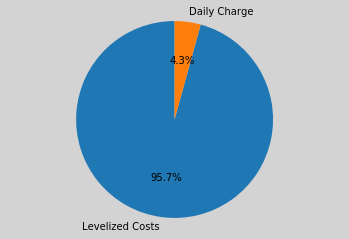

Total roof area of the  building: 599 m2
Total roof area used 561 m2
Percentage: 93.6%
succes
[[136.58406499944738, 197.95741544917846, 174.4811038391897, 44.78734647909988, 27.03185885991285, 32.28109101294615, 0.30901224933642474, 0.5348068795490332, 0.618439225497324, 3111.35, 299.862, 0.0, 299.862, 0.0, {'Levelized Costs': 2978.294, 'Energy Charge': 0.014000000000237378, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599700489685, 61845.7, 560.692]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (134.51939387488096, 194.92143378889932, 159.0689865369469, 29.78278815303541, 26.80675754178056, 22.386518150106756, 0.20422581728201933, 0.5092293300895614, 0.652889923267859)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 29.8
                                           and a gcr of 0.204


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.4093849658966064 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 26.8
                                           and a gcr of 0.509


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.763340711593628 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 159
                                           a tilt of 22.4
                                           and a gcr of 0.653


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8175413608551025 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 298.144, 0.0]


ERROR:ga_logger:Cost: 3094.29


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,094 per year


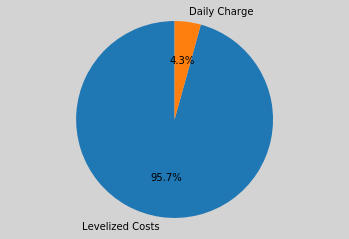

Total roof area of the  building: 599 m2
Total roof area used 585 m2
Percentage: 97.8%
succes
[[134.51939387488096, 194.92143378889932, 159.0689865369469, 29.78278815303541, 26.80675754178056, 22.386518150106756, 0.20422581728201933, 0.5092293300895614, 0.652889923267859, 3094.29, 298.144, 0.0, 298.144, 0.0, {'Levelized Costs': 2961.2329999999997, 'Energy Charge': 0.015000000000213731, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.598732305916, 61845.7, 585.482]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (158.07192290754847, 199.99752378328012, 187.24398600513376, 45.351177442887504, 26.83006319454592, 31.72409359476457, 0.2039295155219766, 0.5336374936521149, 0.6354620764424199)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 158
                                           a tilt of 45.4
                                           and a gcr of 0.204


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.455104827880859 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 26.8
                                           and a gcr of 0.534


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7549614906311035 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 187
                                           a tilt of 31.7
                                           and a gcr of 0.635


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8157215118408203 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [37.8174, 0.0, 262.648]


ERROR:ga_logger:Cost: 3117.34


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,117 per year


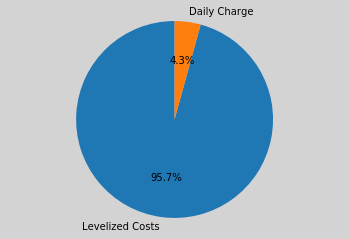

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[158.07192290754847, 199.99752378328012, 187.24398600513376, 45.351177442887504, 26.83006319454592, 31.72409359476457, 0.2039295155219766, 0.5336374936521149, 0.6354620764424199, 3117.34, 300.46540000000005, 37.8174, 0.0, 262.648, {'Levelized Costs': 2984.284, 'Energy Charge': 0.014000000000066848, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59953345349, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (126.46684358504106, 180.44112249424967, 174.88704782855618, 32.304793866335814, 26.38222482705268, 18.193378756009466, 0.36617058457151314, 0.49870162730860457, 0.6251552344297876)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 126
                                           a tilt of 32.3
                                           and a gcr of 0.366


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.819223880767822 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 26.4
                                           and a gcr of 0.499


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8207263946533203 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 18.2
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8108925819396973 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 294.878, 0.0]


ERROR:ga_logger:Cost: 3061.84


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,062 per year


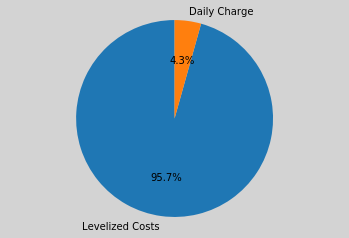

Total roof area of the  building: 599 m2
Total roof area used 591 m2
Percentage: 98.8%
succes
[[126.46684358504106, 180.44112249424967, 174.88704782855618, 32.304793866335814, 26.38222482705268, 18.193378756009466, 0.36617058457151314, 0.49870162730860457, 0.6251552344297876, 3061.84, 294.878, 0.0, 294.878, 0.0, {'Levelized Costs': 2928.7850000000003, 'Energy Charge': 0.012999999999919964, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59969671128, 61845.7, 591.29]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (177.21697106749045, 206.2817531197039, 147.7120807243224, 36.82476644434299, 30.339746924491664, 36.989472824140876, 0.2173097393066353, 0.4991711767748095, 0.7375652362762875)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 177
                                           a tilt of 36.8
                                           and a gcr of 0.217


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.452746629714966 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 206
                                           a tilt of 30.3
                                           and a gcr of 0.499


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.71901273727417 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 148
                                           a tilt of 37.0
                                           and a gcr of 0.738


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8168623447418213 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 288.531, 15.2988]


ERROR:ga_logger:Cost: 3150.75


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,151 per year


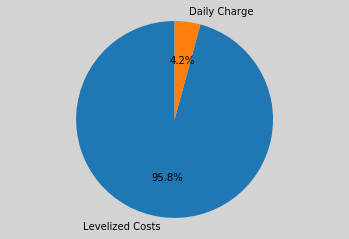

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[177.21697106749045, 206.2817531197039, 147.7120807243224, 36.82476644434299, 30.339746924491664, 36.989472824140876, 0.2173097393066353, 0.4991711767748095, 0.7375652362762875, 3150.75, 303.8298, 0.0, 288.531, 15.2988, {'Levelized Costs': 3017.691, 'Energy Charge': 0.017000000000280124, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59905307767, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (135.64523167762115, 217.74107821155124, 137.7135976389753, 37.77564482263835, 27.951009312576474, 22.960461073671212, 0.20010258662938687, 0.4625349925689461, 0.7098466634287021)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 136
                                           a tilt of 37.8
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.520784378051758 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 218
                                           a tilt of 28.0
                                           and a gcr of 0.463


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7355103492736816 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 138
                                           a tilt of 23.0
                                           and a gcr of 0.710


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7824907302856445 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 211.454, 100.513]


ERROR:ga_logger:Cost: 3231.58


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,232 per year


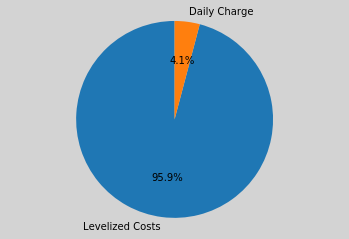

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[135.64523167762115, 217.74107821155124, 137.7135976389753, 37.77564482263835, 27.951009312576474, 22.960461073671212, 0.20010258662938687, 0.4625349925689461, 0.7098466634287021, 3231.58, 311.967, 0.0, 211.454, 100.513, {'Levelized Costs': 3098.5209999999997, 'Energy Charge': 0.017000000000280124, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60031933562, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (164.45189058008967, 182.76678173070536, 196.60444763346266, 42.99556551832348, 32.89565976521005, 34.16167434977997, 0.251914142259262, 0.5786739400001124, 0.6514447467149952)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 164
                                           a tilt of 43.0
                                           and a gcr of 0.252


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.531649589538574 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 32.9
                                           and a gcr of 0.579


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8102188110351562 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 197
                                           a tilt of 34.2
                                           and a gcr of 0.651


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8305399417877197 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [38.0735, 259.029, 0.0]


ERROR:ga_logger:Cost: 3083.94


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,084 per year


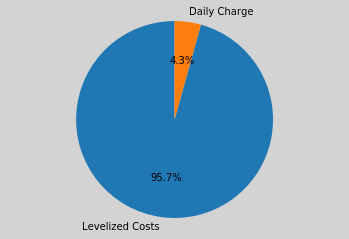

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[164.45189058008967, 182.76678173070536, 196.60444763346266, 42.99556551832348, 32.89565976521005, 34.16167434977997, 0.251914142259262, 0.5786739400001124, 0.6514447467149952, 3083.94, 297.1025, 38.0735, 259.029, 0.0, {'Levelized Costs': 2950.882, 'Energy Charge': 0.01600000000030377, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60277431401, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (131.8003116915848, 182.28116067534188, 168.76793874740162, 33.26958244206318, 28.32309822873416, 26.343106282385435, 0.20258805908802144, 0.5234887200857844, 0.5284589525857808)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 132
                                           a tilt of 33.3
                                           and a gcr of 0.203


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.660070896148682 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 28.3
                                           and a gcr of 0.523


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8909730911254883 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 26.3
                                           and a gcr of 0.528


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8099966049194336 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 295.244, 0.0]


ERROR:ga_logger:Cost: 3065.48


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,065 per year


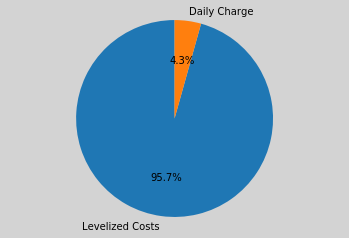

Total roof area of the  building: 599 m2
Total roof area used 564 m2
Percentage: 94.2%
succes
[[131.8003116915848, 182.28116067534188, 168.76793874740162, 33.26958244206318, 28.32309822873416, 26.343106282385435, 0.20258805908802144, 0.5234887200857844, 0.5284589525857808, 3065.48, 295.244, 0.0, 295.244, 0.0, {'Levelized Costs': 2932.429, 'Energy Charge': 0.008999999999957708, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60148318929, 61845.7, 563.993]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (146.05435743231888, 180.39883832373033, 191.4960307260281, 40.40134921280201, 32.41549687371184, 33.51024281958023, 0.2751849769372257, 0.4705829654279495, 0.6383849434706026)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 146
                                           a tilt of 40.4
                                           and a gcr of 0.275


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.9767420291900635 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 32.4
                                           and a gcr of 0.471


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.839813232421875 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 191
                                           a tilt of 33.5
                                           and a gcr of 0.638


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8253068923950195 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 244.491, 50.5674]


ERROR:ga_logger:Cost: 3063.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,064 per year


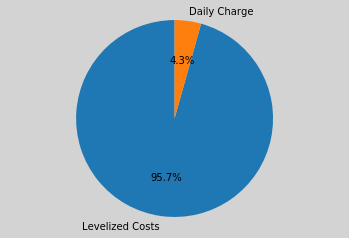

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[146.05435743231888, 180.39883832373033, 191.4960307260281, 40.40134921280201, 32.41549687371184, 33.51024281958023, 0.2751849769372257, 0.4705829654279495, 0.6383849434706026, 3063.64, 295.0584, 0.0, 244.491, 50.5674, {'Levelized Costs': 2930.589, 'Energy Charge': 0.009000000000185082, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60180968693, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (113.51542264508177, 165.60140917556703, 169.2517159120833, 28.83384023107209, 26.767489026584, 19.270821587700837, 0.23248296913487737, 0.4456575051905384, 0.5882155783727535)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 114
                                           a tilt of 28.8
                                           and a gcr of 0.232


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.425018548965454 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 166
                                           a tilt of 26.8
                                           and a gcr of 0.446


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.725234270095825 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 19.3
                                           and a gcr of 0.588


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.788393020629883 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 167.181, 131.541]


ERROR:ga_logger:Cost: 3100.03


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,100 per year


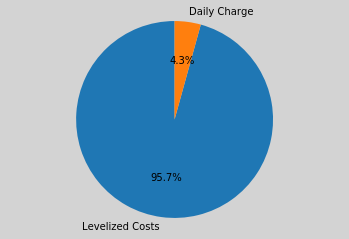

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[113.51542264508177, 165.60140917556703, 169.2517159120833, 28.83384023107209, 26.767489026584, 19.270821587700837, 0.23248296913487737, 0.4456575051905384, 0.5882155783727535, 3100.03, 298.722, 0.0, 167.181, 131.541, {'Levelized Costs': 2966.967, 'Energy Charge': 0.02100000000007185, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60106323238, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (156.86221172916638, 200.1751771024422, 196.97425457371844, 34.36771958667762, 28.545128978181637, 41.59636240969945, 0.21046418378145576, 0.5252956843561613, 0.7501182156774596)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 34.4
                                           and a gcr of 0.210


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.931437730789185 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 28.5
                                           and a gcr of 0.525


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.818244218826294 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 197
                                           a tilt of 41.6
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.869091033935547 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [9.6538, 290.432, 0.0]


ERROR:ga_logger:Cost: 3113.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,114 per year


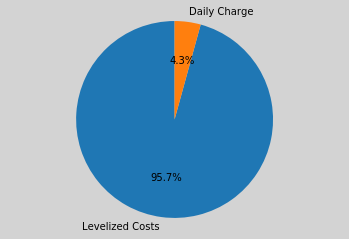

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[156.86221172916638, 200.1751771024422, 196.97425457371844, 34.36771958667762, 28.545128978181637, 41.59636240969945, 0.21046418378145576, 0.5252956843561613, 0.7501182156774596, 3113.57, 300.0858, 9.6538, 290.432, 0.0, {'Levelized Costs': 2980.514, 'Energy Charge': 0.014000000000237378, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601584248536, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (133.93613445934443, 185.7833463220079, 200.08730051893545, 27.17641769329581, 31.428766030204816, 19.6525100289521, 0.23832313560316476, 0.5021804556203743, 0.5881989597673815)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 134
                                           a tilt of 27.2
                                           and a gcr of 0.238


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.617994785308838 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 186
                                           a tilt of 31.4
                                           and a gcr of 0.502


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.760892629623413 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 19.7
                                           and a gcr of 0.588


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.750187635421753 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 295.171, 0.0]


ERROR:ga_logger:Cost: 3064.75


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,065 per year


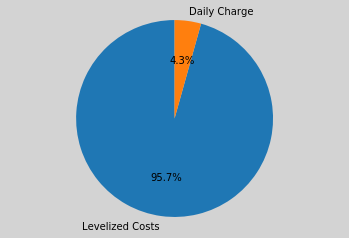

Total roof area of the  building: 599 m2
Total roof area used 588 m2
Percentage: 98.2%
succes
[[133.93613445934443, 185.7833463220079, 200.08730051893545, 27.17641769329581, 31.428766030204816, 19.6525100289521, 0.23832313560316476, 0.5021804556203743, 0.5881989597673815, 3064.75, 295.171, 0.0, 295.171, 0.0, {'Levelized Costs': 2931.698, 'Energy Charge': 0.010000000000161435, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60229018079, 61845.7, 587.779]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (147.06190388378002, 184.2150532577567, 174.64862433283412, 38.78927571154893, 30.318629824531353, 14.580284898889966, 0.22111268354285293, 0.45490655857113993, 0.6961066251958289)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 147
                                           a tilt of 38.8
                                           and a gcr of 0.221


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.754030704498291 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 184
                                           a tilt of 30.3
                                           and a gcr of 0.455


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9432389736175537 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 14.6
                                           and a gcr of 0.696


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8218462467193604 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 225.687, 71.4507]


ERROR:ga_logger:Cost: 3084.29


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,084 per year


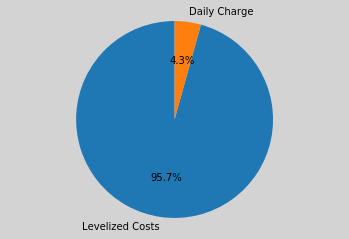

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[147.06190388378002, 184.2150532577567, 174.64862433283412, 38.78927571154893, 30.318629824531353, 14.580284898889966, 0.22111268354285293, 0.45490655857113993, 0.6961066251958289, 3084.29, 297.1377, 0.0, 225.687, 71.4507, {'Levelized Costs': 2951.232, 'Energy Charge': 0.01599999999996271, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600753984785, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (170.59259620662573, 170.23197787588006, 155.46861633484443, 33.34060775985164, 23.56106686546014, 23.89766522889563, 0.20013564204586387, 0.4776194718885435, 0.75173141596824)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 171
                                           a tilt of 33.3
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.629782438278198 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 23.6
                                           and a gcr of 0.478


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.794771194458008 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 23.9
                                           and a gcr of 0.752


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8057966232299805 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 263.404, 35.5325]


ERROR:ga_logger:Cost: 3102.16


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,102 per year


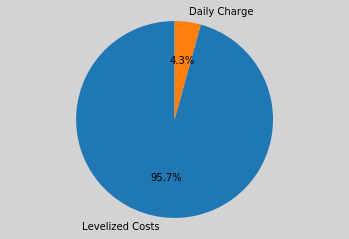

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[170.59259620662573, 170.23197787588006, 155.46861633484443, 33.34060775985164, 23.56106686546014, 23.89766522889563, 0.20013564204586387, 0.4776194718885435, 0.75173141596824, 3102.16, 298.9365, 0.0, 263.404, 35.5325, {'Levelized Costs': 2969.103, 'Energy Charge': 0.015000000000043201, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60168662986, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (162.7730757557635, 182.7861130364271, 175.06503800764656, 35.890019807942444, 27.82363763936372, 38.63125878833145, 0.20046519645086552, 0.49416927847266967, 0.6611677836659778)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 163
                                           a tilt of 35.9
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.062687158584595 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 27.8
                                           and a gcr of 0.494


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.758002758026123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 38.6
                                           and a gcr of 0.661


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.736354351043701 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.817863, 293.874, 0.0]


ERROR:ga_logger:Cost: 3059.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,060 per year


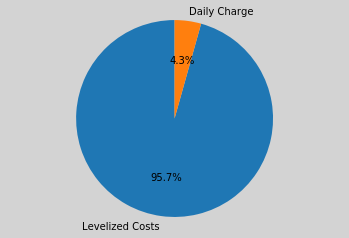

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[162.7730757557635, 182.7861130364271, 175.06503800764656, 35.890019807942444, 27.82363763936372, 38.63125878833145, 0.20046519645086552, 0.49416927847266967, 0.6611677836659778, 3059.99, 294.691863, 0.817863, 293.874, 0.0, {'Levelized Costs': 2926.9289999999996, 'Energy Charge': 0.019000000000289674, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59935548881, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (127.85075640901533, 163.3968438053375, 169.1674761573492, 33.055249210102666, 32.021638395409504, 19.44782515133758, 0.20077430138038713, 0.5317387536948428, 0.653174082486195)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 128
                                           a tilt of 33.1
                                           and a gcr of 0.201


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.588968276977539 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 163
                                           a tilt of 32.0
                                           and a gcr of 0.532


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.803511381149292 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 19.4
                                           and a gcr of 0.653


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7635419368743896 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 299.594, 0.0]


ERROR:ga_logger:Cost: 3108.68


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,109 per year


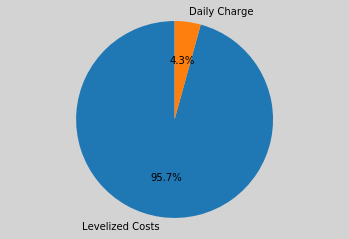

Total roof area of the  building: 599 m2
Total roof area used 563 m2
Percentage: 94.1%
succes
[[127.85075640901533, 163.3968438053375, 169.1674761573492, 33.055249210102666, 32.021638395409504, 19.44782515133758, 0.20077430138038713, 0.5317387536948428, 0.653174082486195, 3108.68, 299.594, 0.0, 299.594, 0.0, {'Levelized Costs': 2975.622, 'Energy Charge': 0.01599999999996271, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60351300012, 61845.7, 563.423]]


ERROR:optimizer_logger:160


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (158.17191373169348, 182.18328089538636, 167.59963040315589, 38.09154106433829, 33.68258030105805, 26.34646962621628, 0.20135255346582304, 0.6095293986915917, 0.7898420351388814)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 158
                                           a tilt of 38.1
                                           and a gcr of 0.201


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.646661996841431 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 33.7
                                           and a gcr of 0.610


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.870694160461426 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 26.3
                                           and a gcr of 0.790


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.83628511428833 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [32.9056, 265.352, 0.0]


ERROR:ga_logger:Cost: 3095.41


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,095 per year


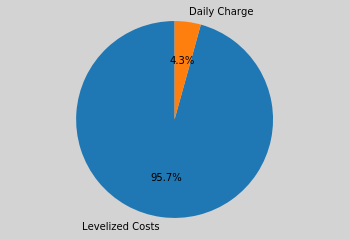

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[158.17191373169348, 182.18328089538636, 167.59963040315589, 38.09154106433829, 33.68258030105805, 26.34646962621628, 0.20135255346582304, 0.6095293986915917, 0.7898420351388814, 3095.41, 298.25759999999997, 32.9056, 265.352, 0.0, {'Levelized Costs': 2962.3559999999998, 'Energy Charge': 0.012000000000284672, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60034463511, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130.0587427998154, 171.88637285204527, 168.28750467390878, 29.791563310635727, 26.720485352255817, 23.461198687201694, 0.20035667914238897, 0.5068278476092635, 0.6235548467935482)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 29.8
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.648164987564087 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 172
                                           a tilt of 26.7
                                           and a gcr of 0.507


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.718919515609741 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 23.5
                                           and a gcr of 0.624


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.82327938079834 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 296.44, 0.0]


ERROR:ga_logger:Cost: 3077.36


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 45,102 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,077 per year


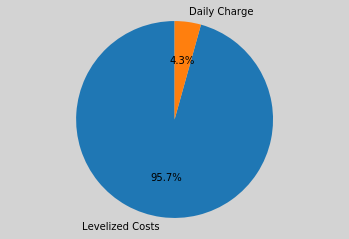

Total roof area of the  building: 599 m2
Total roof area used 585 m2
Percentage: 97.7%
succes
[[130.0587427998154, 171.88637285204527, 168.28750467390878, 29.791563310635727, 26.720485352255817, 23.461198687201694, 0.20035667914238897, 0.5068278476092635, 0.6235548467935482, 3077.36, 296.44, 0.0, 296.44, 0.0, {'Levelized Costs': 2944.3080000000004, 'Energy Charge': 0.009999999999877218, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6014051899, 45102.3, 584.894]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (132.4105430260204, 180.6410151951947, 196.13874812766787, 38.38611770224207, 26.408407108220807, 19.626104608622995, 0.40807284179056535, 0.49870162730860457, 0.6655057593380864)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 132
                                           a tilt of 38.4
                                           and a gcr of 0.408


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.817760944366455 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 26.4
                                           and a gcr of 0.499


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8051517009735107 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 196
                                           a tilt of 19.6
                                           and a gcr of 0.666


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.821883201599121 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 294.893, 0.0]


ERROR:ga_logger:Cost: 3061.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,062 per year


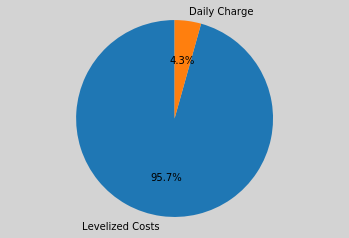

Total roof area of the  building: 599 m2
Total roof area used 591 m2
Percentage: 98.8%
succes
[[132.4105430260204, 180.6410151951947, 196.13874812766787, 38.38611770224207, 26.408407108220807, 19.626104608622995, 0.40807284179056535, 0.49870162730860457, 0.6655057593380864, 3061.99, 294.893, 0.0, 294.893, 0.0, {'Levelized Costs': 2928.9349999999995, 'Energy Charge': 0.013000000000204182, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603924856674, 61845.7, 591.322]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (126.4875037819048, 182.7483778688761, 174.88704782855618, 32.304793866335814, 26.004324481706725, 18.44630692437656, 0.36617058457151314, 0.4917081503187275, 0.6732077238979324)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 126
                                           a tilt of 32.3
                                           and a gcr of 0.366


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.670684814453125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 26.0
                                           and a gcr of 0.492


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.757244825363159 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 18.4
                                           and a gcr of 0.673


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7502353191375732 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 292.12, 3.14413]


ERROR:ga_logger:Cost: 3065.67


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,066 per year


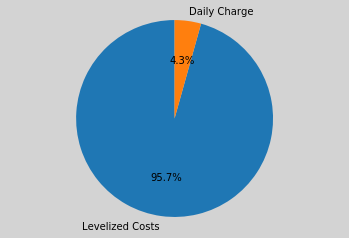

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[126.4875037819048, 182.7483778688761, 174.88704782855618, 32.304793866335814, 26.004324481706725, 18.44630692437656, 0.36617058457151314, 0.4917081503187275, 0.6732077238979324, 3065.67, 295.26413, 0.0, 292.12, 3.14413, {'Levelized Costs': 2932.6130000000003, 'Energy Charge': 0.015000000000043201, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.5988193703, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (172.42699698842645, 182.84109864864757, 168.42868905466253, 35.989522184279046, 32.68700477498183, 36.492984716089374, 0.2586552085101057, 0.5261282792194754, 0.7224265652185597)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 172
                                           a tilt of 36.0
                                           and a gcr of 0.259


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.640507459640503 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 32.7
                                           and a gcr of 0.526


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8458499908447266 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 36.5
                                           and a gcr of 0.722


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.809906482696533 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [19.2778, 275.813, 0.0]


ERROR:ga_logger:Cost: 3063.95


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,064 per year


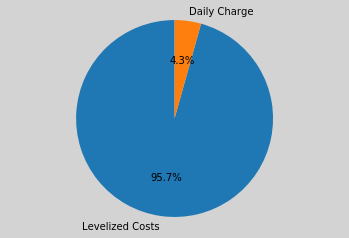

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[172.42699698842645, 182.84109864864757, 168.42868905466253, 35.989522184279046, 32.68700477498183, 36.492984716089374, 0.2586552085101057, 0.5261282792194754, 0.7224265652185597, 3063.95, 295.0908, 19.2778, 275.813, 0.0, {'Levelized Costs': 2930.89, 'Energy Charge': 0.018000000000029104, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600302630766, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (129.83402532503186, 180.62863693495075, 137.01665838404858, 34.10759096715832, 32.546269106275645, 23.665539048182815, 0.2011866139107112, 0.41814993897549946, 0.6610932476192348)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 34.1
                                           and a gcr of 0.201


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.4420013427734375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 32.5
                                           and a gcr of 0.418


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.617633581161499 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 137
                                           a tilt of 23.7
                                           and a gcr of 0.661


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.706564426422119 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 158.216, 145.698]


ERROR:ga_logger:Cost: 3151.59


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,152 per year


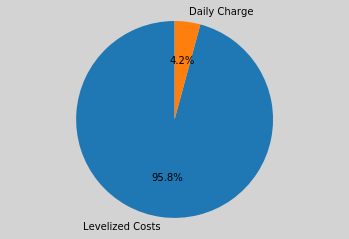

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[129.83402532503186, 180.62863693495075, 137.01665838404858, 34.10759096715832, 32.546269106275645, 23.665539048182815, 0.2011866139107112, 0.41814993897549946, 0.6610932476192348, 3151.59, 303.914, 0.0, 158.216, 145.698, {'Levelized Costs': 3018.544, 'Energy Charge': 0.0040000000003033165, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60519465688, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (146.42030822110118, 185.1262596389814, 186.419554024128, 32.304793866335814, 20.27873601379536, 18.199370384478534, 0.3992928983638745, 0.4814995512795726, 0.611258244601683)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 146
                                           a tilt of 32.3
                                           and a gcr of 0.399


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.440377235412598 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 20.3
                                           and a gcr of 0.481


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.450186014175415 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 186
                                           a tilt of 18.2
                                           and a gcr of 0.611


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4966490268707275 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 247.217, 52.1588]


ERROR:ga_logger:Cost: 3106.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,107 per year


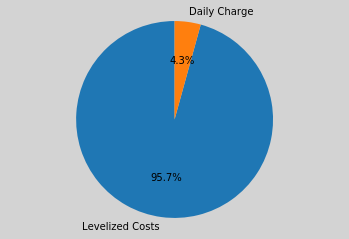

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[146.42030822110118, 185.1262596389814, 186.419554024128, 32.304793866335814, 20.27873601379536, 18.199370384478534, 0.3992928983638745, 0.4814995512795726, 0.611258244601683, 3106.52, 299.3758, 0.0, 247.217, 52.1588, {'Levelized Costs': 2973.464, 'Energy Charge': 0.014000000000237378, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60258466587, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (126.46684358504106, 175.66611736945617, 174.88704782855618, 32.304793866335814, 13.198445405890167, 17.626330921387087, 0.39252521280583275, 0.43348101882937523, 0.591211386005656)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 126
                                           a tilt of 32.3
                                           and a gcr of 0.393


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.4230499267578125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 176
                                           a tilt of 13.2
                                           and a gcr of 0.433


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3515419960021973 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 17.6
                                           and a gcr of 0.591


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3421669006347656 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 303.242]


ERROR:ga_logger:Cost: 3144.92


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,145 per year


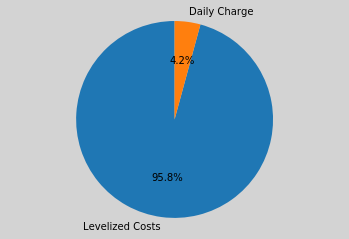

Total roof area of the  building: 599 m2
Total roof area used 513 m2
Percentage: 85.7%
succes
[[126.46684358504106, 175.66611736945617, 174.88704782855618, 32.304793866335814, 13.198445405890167, 17.626330921387087, 0.39252521280583275, 0.43348101882937523, 0.591211386005656, 3144.92, 303.242, 0.0, 0.0, 303.242, {'Levelized Costs': 3011.8650000000002, 'Energy Charge': 0.012999999999806278, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601129091534, 61845.7, 512.916]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130.79115053291122, 182.9824787845826, 174.84003454899144, 30.459120358524892, 24.10063107197631, 26.28701404863636, 0.21829003337930464, 0.573214906753175, 0.6715340425881127)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 131
                                           a tilt of 30.5
                                           and a gcr of 0.218


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.391765594482422 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 24.1
                                           and a gcr of 0.573


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.362896203994751 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 26.3
                                           and a gcr of 0.672


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.398550033569336 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 297.834, 0.0]


ERROR:ga_logger:Cost: 3091.2


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,091 per year


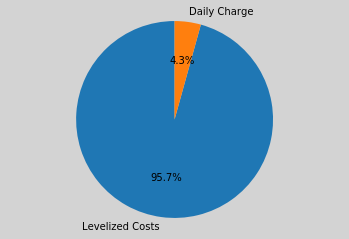

Total roof area of the  building: 599 m2
Total roof area used 520 m2
Percentage: 86.8%
succes
[[130.79115053291122, 182.9824787845826, 174.84003454899144, 30.459120358524892, 24.10063107197631, 26.28701404863636, 0.21829003337930464, 0.573214906753175, 0.6715340425881127, 3091.2, 297.834, 0.0, 297.834, 0.0, {'Levelized Costs': 2958.1449999999995, 'Energy Charge': 0.013000000000261025, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60164580992, 61845.7, 519.585]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125.91394544929234, 173.52351669829312, 184.17468398596364, 37.59831967521796, 22.80922276792186, 20.041102896303066, 0.20043968740631196, 0.46318747827145224, 0.641851496375778)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 126
                                           a tilt of 37.6
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.443339824676514 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 174
                                           a tilt of 22.8
                                           and a gcr of 0.463


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.353154420852661 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 184
                                           a tilt of 20.0
                                           and a gcr of 0.642


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3560099601745605 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 223.326, 74.8475]


ERROR:ga_logger:Cost: 3094.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,095 per year


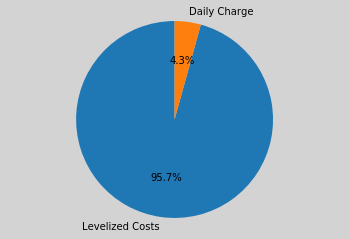

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[125.91394544929234, 173.52351669829312, 184.17468398596364, 37.59831967521796, 22.80922276792186, 20.041102896303066, 0.20043968740631196, 0.46318747827145224, 0.641851496375778, 3094.57, 298.1735, 0.0, 223.326, 74.8475, {'Levelized Costs': 2961.5140000000006, 'Energy Charge': 0.013999999999839474, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59883630888, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (158.2050985055228, 185.64205929916446, 175.0887577301457, 36.01482948890656, 27.818259592470547, 38.926796018503445, 0.20030032894582886, 0.4551509395700954, 0.6603357302427703)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 158
                                           a tilt of 36.0
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.458634853363037 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 186
                                           a tilt of 27.8
                                           and a gcr of 0.455


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.500305414199829 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 38.9
                                           and a gcr of 0.660


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3626532554626465 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 216.679, 81.0242]


ERROR:ga_logger:Cost: 3089.91


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,090 per year


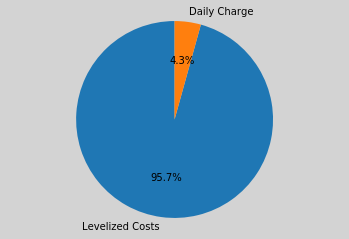

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[158.2050985055228, 185.64205929916446, 175.0887577301457, 36.01482948890656, 27.818259592470547, 38.926796018503445, 0.20030032894582886, 0.4551509395700954, 0.6603357302427703, 3089.91, 297.7032, 0.0, 216.679, 81.0242, {'Levelized Costs': 2956.8549999999996, 'Energy Charge': 0.013000000000204182, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60413871156, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (133.10441700516031, 182.31659903478032, 176.8836592780991, 30.799118519005926, 26.027653768019704, 25.448835279401322, 0.20030969209857885, 0.4940360436232423, 0.6362941298656274)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 133
                                           a tilt of 30.8
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.465265274047852 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 26.0
                                           and a gcr of 0.494


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6037425994873047 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 177
                                           a tilt of 25.4
                                           and a gcr of 0.636


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4355263710021973 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 295.143, 0.0]


ERROR:ga_logger:Cost: 3064.48


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,064 per year


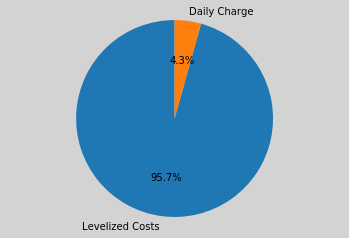

Total roof area of the  building: 599 m2
Total roof area used 597 m2
Percentage: 99.8%
succes
[[133.10441700516031, 182.31659903478032, 176.8836592780991, 30.799118519005926, 26.027653768019704, 25.448835279401322, 0.20030969209857885, 0.4940360436232423, 0.6362941298656274, 3064.48, 295.143, 0.0, 295.143, 0.0, {'Levelized Costs': 2931.424, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60308907236, 61845.7, 597.412]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (153.92093238932358, 169.28934113268267, 174.20555804982516, 44.44277713734901, 26.835876233888314, 30.693976399383267, 0.2954072797246207, 0.5247852938531502, 0.650709387707458)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 154
                                           a tilt of 44.4
                                           and a gcr of 0.295


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.450613975524902 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 169
                                           a tilt of 26.8
                                           and a gcr of 0.525


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.431596279144287 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 174
                                           a tilt of 30.7
                                           and a gcr of 0.651


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.353219747543335 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 297.39, 0.0]


ERROR:ga_logger:Cost: 3086.8


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,087 per year


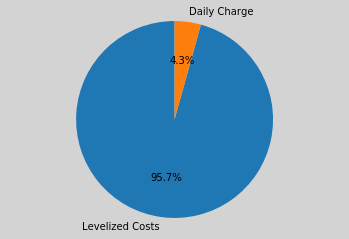

Total roof area of the  building: 599 m2
Total roof area used 567 m2
Percentage: 94.6%
succes
[[153.92093238932358, 169.28934113268267, 174.20555804982516, 44.44277713734901, 26.835876233888314, 30.693976399383267, 0.2954072797246207, 0.5247852938531502, 0.650709387707458, 3086.8, 297.39, 0.0, 297.39, 0.0, {'Levelized Costs': 2953.745, 'Energy Charge': 0.013000000000261025, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60213508012, 61845.7, 566.69]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (136.75796771855173, 180.212370170183, 181.26612397088147, 30.65911315707112, 26.80675754178056, 21.136122916495278, 0.21737665397612926, 0.49101336532196177, 0.6251552344297876)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 137
                                           a tilt of 30.7
                                           and a gcr of 0.217


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.4369494915008545 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 26.8
                                           and a gcr of 0.491


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.485213279724121 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 21.1
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.353388786315918 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 291.799, 2.802]


ERROR:ga_logger:Cost: 3059.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,059 per year


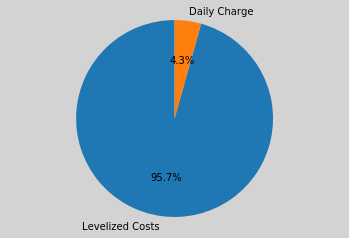

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[136.75796771855173, 180.212370170183, 181.26612397088147, 30.65911315707112, 26.80675754178056, 21.136122916495278, 0.21737665397612926, 0.49101336532196177, 0.6251552344297876, 3059.09, 294.601, 0.0, 291.799, 2.802, {'Levelized Costs': 2926.037, 'Energy Charge': 0.011000000000478849, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60119607165, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (132.70786033934587, 184.44396228855496, 162.64455293680285, 34.277151427257024, 26.886117322727934, 33.46861619857934, 0.2241765192171015, 0.5060574217733925, 0.6517392759196213)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 133
                                           a tilt of 34.3
                                           and a gcr of 0.224


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.521129369735718 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 184
                                           a tilt of 26.9
                                           and a gcr of 0.506


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.444518566131592 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 163
                                           a tilt of 33.5
                                           and a gcr of 0.652


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.527657985687256 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 295.486, 0.0]


ERROR:ga_logger:Cost: 3067.88


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,068 per year


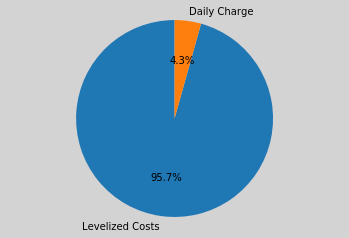

Total roof area of the  building: 599 m2
Total roof area used 584 m2
Percentage: 97.5%
succes
[[132.70786033934587, 184.44396228855496, 162.64455293680285, 34.277151427257024, 26.886117322727934, 33.46861619857934, 0.2241765192171015, 0.5060574217733925, 0.6517392759196213, 3067.88, 295.486, 0.0, 295.486, 0.0, {'Levelized Costs': 2934.828, 'Energy Charge': 0.010000000000388809, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601874010164, 61845.7, 583.897]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (119.70735329239083, 179.3368564880551, 171.2397830512212, 31.699690051007416, 26.42698609872118, 37.20167932648492, 0.20018086964467532, 0.4261589015357248, 0.6415830481102297)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 31.7
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.277496814727783 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 179
                                           a tilt of 26.4
                                           and a gcr of 0.426


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.195941925048828 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 171
                                           a tilt of 37.2
                                           and a gcr of 0.642


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3556699752807617 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 167.962, 131.288]


ERROR:ga_logger:Cost: 3105.27


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,105 per year


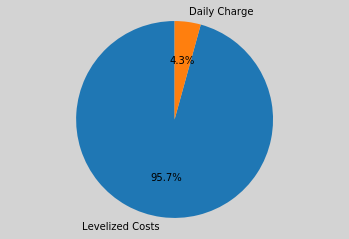

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[119.70735329239083, 179.3368564880551, 171.2397830512212, 31.699690051007416, 26.42698609872118, 37.20167932648492, 0.20018086964467532, 0.4261589015357248, 0.6415830481102297, 3105.27, 299.25, 0.0, 167.962, 131.288, {'Levelized Costs': 2972.208, 'Energy Charge': 0.020000000000095497, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59930976008, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125.0927357576337, 180.3575013837437, 182.1611292619312, 43.75764447628485, 30.761628459368364, 27.471641266554077, 0.33163862077976614, 0.5049222767784558, 0.7182555658368414)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 43.8
                                           and a gcr of 0.332


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.222731113433838 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 30.8
                                           and a gcr of 0.505


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1907317638397217 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 27.5
                                           and a gcr of 0.718


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1952168941497803 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 294.254, 0.0]


ERROR:ga_logger:Cost: 3055.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,056 per year


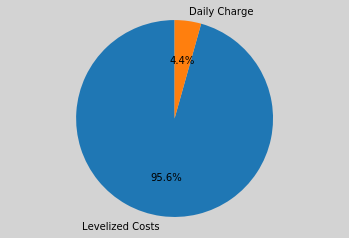

Total roof area of the  building: 599 m2
Total roof area used 583 m2
Percentage: 97.3%
succes
[[125.0927357576337, 180.3575013837437, 182.1611292619312, 43.75764447628485, 30.761628459368364, 27.471641266554077, 0.33163862077976614, 0.5049222767784558, 0.7182555658368414, 3055.64, 294.254, 0.0, 294.254, 0.0, {'Levelized Costs': 2922.5789999999997, 'Energy Charge': 0.01900000000023283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59993111478, 61845.7, 582.77]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (104.60629316588154, 178.53098453071195, 170.308807787761, 32.38446861911695, 26.65837485589475, 17.58894057974896, 0.205232729469141, 0.5556206391887879, 0.655529667156484)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 32.4
                                           and a gcr of 0.205


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.245100259780884 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 179
                                           a tilt of 26.7
                                           and a gcr of 0.556


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.242281675338745 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 17.6
                                           and a gcr of 0.656


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1950483322143555 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 297.543, 0.0]


ERROR:ga_logger:Cost: 3088.32


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,088 per year


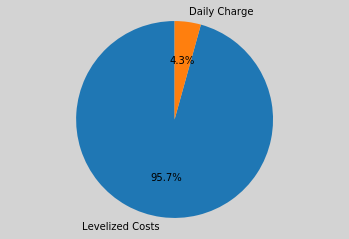

Total roof area of the  building: 599 m2
Total roof area used 536 m2
Percentage: 89.4%
succes
[[104.60629316588154, 178.53098453071195, 170.308807787761, 32.38446861911695, 26.65837485589475, 17.58894057974896, 0.205232729469141, 0.5556206391887879, 0.655529667156484, 3088.32, 297.543, 0.0, 297.543, 0.0, {'Levelized Costs': 2955.2599999999998, 'Energy Charge': 0.01800000000031332, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60216089991, 61845.7, 535.515]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (144.8360713339353, 185.35388948986576, 176.4184571953412, 38.75342827749603, 33.21452464259275, 26.34646962621628, 0.20269923695570835, 0.59726567442715, 0.7970786797813707)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 38.8
                                           and a gcr of 0.203


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.273763179779053 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 33.2
                                           and a gcr of 0.597


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2466752529144287 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 176
                                           a tilt of 26.3
                                           and a gcr of 0.797


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.21763014793396 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [30.1068, 268.908, 0.0]


ERROR:ga_logger:Cost: 3102.93


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,103 per year


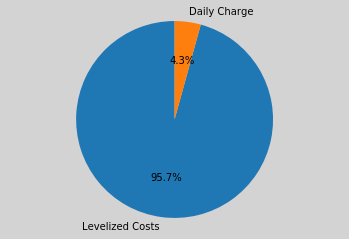

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[144.8360713339353, 185.35388948986576, 176.4184571953412, 38.75342827749603, 33.21452464259275, 26.34646962621628, 0.20269923695570835, 0.59726567442715, 0.7970786797813707, 3102.93, 299.01480000000004, 30.1068, 268.908, 0.0, {'Levelized Costs': 2969.877, 'Energy Charge': 0.011000000000137788, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60265135215, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (116.36248829911732, 179.8159815523678, 168.35838374961918, 36.55375671972266, 27.188541010721124, 23.461198687201694, 0.20180123062308833, 0.4928535297565666, 0.6284771908514802)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 116
                                           a tilt of 36.6
                                           and a gcr of 0.202


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.527224063873291 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 27.2
                                           and a gcr of 0.493


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.22119402885437 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 23.5
                                           and a gcr of 0.628


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.227947235107422 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 293.355, 2.22769]


ERROR:ga_logger:Cost: 3068.84


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,069 per year


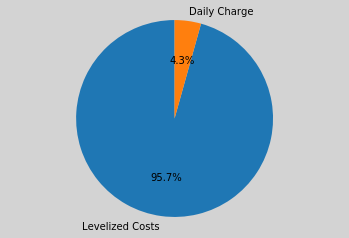

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[116.36248829911732, 179.8159815523678, 168.35838374961918, 36.55375671972266, 27.188541010721124, 23.461198687201694, 0.20180123062308833, 0.4928535297565666, 0.6284771908514802, 3068.84, 295.58269, 0.0, 293.355, 2.22769, {'Levelized Costs': 2935.781, 'Energy Charge': 0.017000000000109594, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.598568178386, 61845.7, 598.762]]


ERROR:optimizer_logger:180


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (136.82648657544783, 182.31659903478032, 177.1432705080206, 30.799118519005926, 26.221276991795662, 26.396561057266148, 0.24768666405711795, 0.7038605390892484, 0.6362941298656274)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 137
                                           a tilt of 30.8
                                           and a gcr of 0.248


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.315891981124878 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 26.2
                                           and a gcr of 0.704


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.147189140319824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 177
                                           a tilt of 26.4
                                           and a gcr of 0.636


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.048124313354492 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 300.752]


ERROR:ga_logger:Cost: 3120.18


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,120 per year


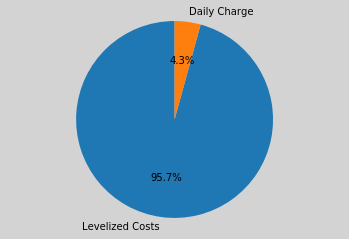

Total roof area of the  building: 599 m2
Total roof area used 473 m2
Percentage: 78.9%
succes
[[136.82648657544783, 182.31659903478032, 177.1432705080206, 30.799118519005926, 26.221276991795662, 26.396561057266148, 0.24768666405711795, 0.7038605390892484, 0.6362941298656274, 3120.18, 300.752, 0.0, 0.0, 300.752, {'Levelized Costs': 2987.1209999999996, 'Energy Charge': 0.017000000000109594, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59883225697, 61845.7, 472.661]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (136.3698042951643, 185.38524001533577, 176.8400357117043, 30.553172406145677, 21.800825368073035, 21.850740396517295, 0.2000532083174343, 0.5054230951479309, 0.6182323665201521)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 136
                                           a tilt of 30.6
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.590003252029419 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 21.8
                                           and a gcr of 0.505


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.507110357284546 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 177
                                           a tilt of 21.9
                                           and a gcr of 0.618


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4366660118103027 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 297.923, 0.0]


ERROR:ga_logger:Cost: 3092.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,092 per year


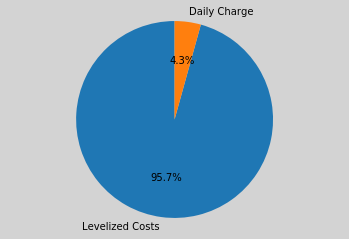

Total roof area of the  building: 599 m2
Total roof area used 589 m2
Percentage: 98.4%
succes
[[136.3698042951643, 185.38524001533577, 176.8400357117043, 30.553172406145677, 21.800825368073035, 21.850740396517295, 0.2000532083174343, 0.5054230951479309, 0.6182323665201521, 3092.09, 297.923, 0.0, 297.923, 0.0, {'Levelized Costs': 2959.0370000000003, 'Energy Charge': 0.011000000000137788, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601654954175, 61845.7, 589.453]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (127.94801347996035, 182.28116067534188, 182.40899565397388, 55.90265328362195, 34.23428350464869, 37.72154177115172, 0.3493736521161872, 0.540789360274704, 0.7485514814977359)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 128
                                           a tilt of 55.9
                                           and a gcr of 0.349


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.6824164390563965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 34.2
                                           and a gcr of 0.541


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3792736530303955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 37.7
                                           and a gcr of 0.749


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5507376194000244 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 296.194, 0.0]


ERROR:ga_logger:Cost: 3074.92


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,075 per year


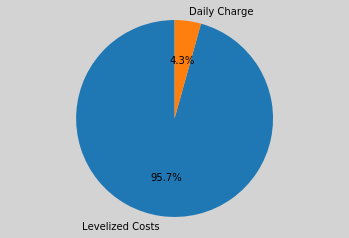

Total roof area of the  building: 599 m2
Total roof area used 548 m2
Percentage: 91.5%
succes
[[127.94801347996035, 182.28116067534188, 182.40899565397388, 55.90265328362195, 34.23428350464869, 37.72154177115172, 0.3493736521161872, 0.540789360274704, 0.7485514814977359, 3074.92, 296.194, 0.0, 296.194, 0.0, {'Levelized Costs': 2941.868, 'Energy Charge': 0.010000000000104592, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60495037149, 61845.7, 547.707]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (113.97678621720283, 180.3575013837437, 156.4176204562141, 33.342204457302046, 30.672832130040263, 22.317694036940065, 0.20011682506351375, 0.49255755142590374, 0.5325138887469398)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 114
                                           a tilt of 33.3
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.879533290863037 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 30.7
                                           and a gcr of 0.493


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6565403938293457 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 156
                                           a tilt of 22.3
                                           and a gcr of 0.533


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4152402877807617 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 293.938, 0.0]


ERROR:ga_logger:Cost: 3052.51


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,053 per year


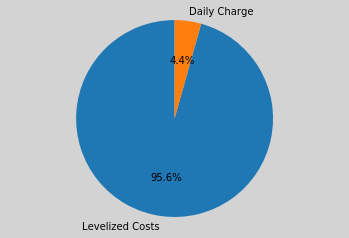

Total roof area of the  building: 599 m2
Total roof area used 597 m2
Percentage: 99.7%
succes
[[113.97678621720283, 180.3575013837437, 156.4176204562141, 33.342204457302046, 30.672832130040263, 22.317694036940065, 0.20011682506351375, 0.49255755142590374, 0.5325138887469398, 3052.51, 293.938, 0.0, 293.938, 0.0, {'Levelized Costs': 2919.4550000000004, 'Energy Charge': 0.012999999999976808, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60019908737, 61845.7, 596.759]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (126.9247856910134, 195.10012191972302, 178.2452766599234, 34.277151427257024, 26.431507107987148, 40.47682176147013, 0.37113245592891303, 0.49594374868732544, 0.641851496375778)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 127
                                           a tilt of 34.3
                                           and a gcr of 0.371


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.597230434417725 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 26.4
                                           and a gcr of 0.496


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3920865058898926 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 40.5
                                           and a gcr of 0.642


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.66872501373291 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 293.132, 4.94383]


ERROR:ga_logger:Cost: 3093.61


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,094 per year


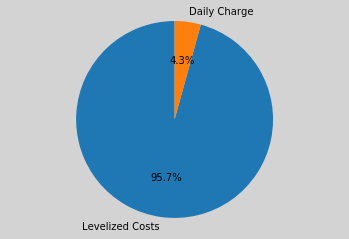

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[126.9247856910134, 195.10012191972302, 178.2452766599234, 34.277151427257024, 26.431507107987148, 40.47682176147013, 0.37113245592891303, 0.49594374868732544, 0.641851496375778, 3093.61, 298.07583, 0.0, 293.132, 4.94383, {'Levelized Costs': 2960.5489999999995, 'Energy Charge': 0.019000000000460204, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60400896191, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (118.64330112320437, 174.17170326351683, 175.07986660572058, 32.304793866335814, 20.655022985913764, 18.193378756009466, 0.20052138711337109, 0.46594535689273137, 0.6170231687432719)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 119
                                           a tilt of 32.3
                                           and a gcr of 0.201


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.554187297821045 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 174
                                           a tilt of 20.7
                                           and a gcr of 0.466


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3960111141204834 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 18.2
                                           and a gcr of 0.617


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.259345769882202 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 214.689, 85.1502]


ERROR:ga_logger:Cost: 3111.12


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,111 per year


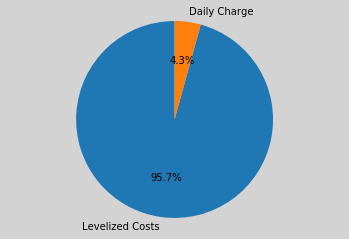

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[118.64330112320437, 174.17170326351683, 175.07986660572058, 32.304793866335814, 20.655022985913764, 18.193378756009466, 0.20052138711337109, 0.46594535689273137, 0.6170231687432719, 3111.12, 299.8392, 0.0, 214.689, 85.1502, {'Levelized Costs': 2978.0629999999996, 'Energy Charge': 0.015000000000156888, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60164365698, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (139.30839721165972, 192.62138528708138, 181.27594790449166, 27.07758983373288, 26.80162522263371, 23.461198687201694, 0.21600695910251527, 0.5068278476092635, 0.6794053752121346)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 139
                                           a tilt of 27.1
                                           and a gcr of 0.216


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.7421369552612305 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 193
                                           a tilt of 26.8
                                           and a gcr of 0.507


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.459150552749634 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 23.5
                                           and a gcr of 0.679


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.681398868560791 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 297.395, 0.0]


ERROR:ga_logger:Cost: 3086.84


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,087 per year


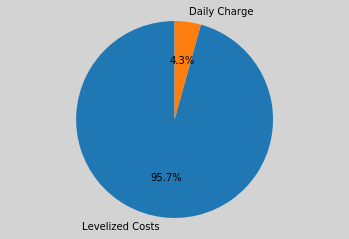

Total roof area of the  building: 599 m2
Total roof area used 587 m2
Percentage: 98.0%
succes
[[139.30839721165972, 192.62138528708138, 181.27594790449166, 27.07758983373288, 26.80162522263371, 23.461198687201694, 0.21600695910251527, 0.5068278476092635, 0.6794053752121346, 3086.84, 297.395, 0.0, 297.395, 0.0, {'Levelized Costs': 2953.79, 'Energy Charge': 0.008000000000151886, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59996309135, 61845.7, 586.777]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130.62149663478792, 171.66419078238366, 151.6072253004107, 26.67430166286515, 26.725617671402667, 21.136122916495278, 0.2746760271780305, 0.49912937454376416, 0.6252415431072302)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 131
                                           a tilt of 26.7
                                           and a gcr of 0.275


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.708990573883057 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 172
                                           a tilt of 26.7
                                           and a gcr of 0.499


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.39690899848938 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 152
                                           a tilt of 21.1
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3322830200195312 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 296.239, 0.0]


ERROR:ga_logger:Cost: 3075.36


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,075 per year


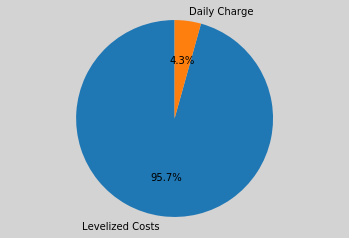

Total roof area of the  building: 599 m2
Total roof area used 594 m2
Percentage: 99.1%
succes
[[130.62149663478792, 171.66419078238366, 151.6072253004107, 26.67430166286515, 26.725617671402667, 21.136122916495278, 0.2746760271780305, 0.49912937454376416, 0.6252415431072302, 3075.36, 296.239, 0.0, 296.239, 0.0, {'Levelized Costs': 2942.299, 'Energy Charge': 0.019000000000175987, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60354580005, 61845.7, 593.511]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (161.31720370265685, 198.82320990279146, 184.26712092155594, 37.60056100923629, 23.23396859562141, 38.63125878833145, 0.20031967365257378, 0.45995228385929343, 0.7003112598507594)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 161
                                           a tilt of 37.6
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.812997579574585 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 199
                                           a tilt of 23.2
                                           and a gcr of 0.460


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9675042629241943 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 184
                                           a tilt of 38.6
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.31608510017395 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 225.389, 76.1489]


ERROR:ga_logger:Cost: 3127.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,128 per year


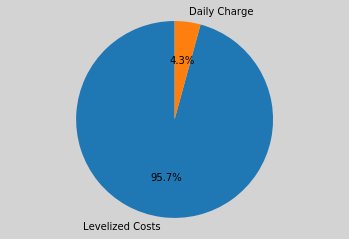

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[161.31720370265685, 198.82320990279146, 184.26712092155594, 37.60056100923629, 23.23396859562141, 38.63125878833145, 0.20031967365257378, 0.45995228385929343, 0.7003112598507594, 3127.99, 301.53790000000004, 0.0, 225.389, 76.1489, {'Levelized Costs': 2994.9379999999996, 'Energy Charge': 0.009999999999990905, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60019476918, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (159.5795916447268, 155.1242520189917, 176.7452904964673, 30.242130023815644, 26.027653768019704, 15.54452759181239, 0.21137243744447565, 0.4931101979994711, 0.6575259845854541)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 30.2
                                           and a gcr of 0.211


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.714208602905273 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.493


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5129294395446777 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 177
                                           a tilt of 15.5
                                           and a gcr of 0.658


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.482961654663086 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 278.373, 22.5114]


ERROR:ga_logger:Cost: 3121.5


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,122 per year


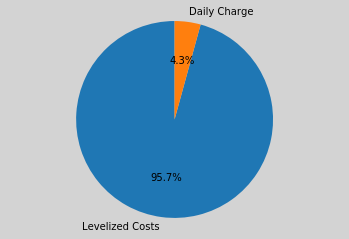

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[159.5795916447268, 155.1242520189917, 176.7452904964673, 30.242130023815644, 26.027653768019704, 15.54452759181239, 0.21137243744447565, 0.4931101979994711, 0.6575259845854541, 3121.5, 300.88439999999997, 0.0, 278.373, 22.5114, {'Levelized Costs': 2988.439, 'Energy Charge': 0.019000000000119144, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601124096815, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (133.7080535416262, 171.9137008898087, 174.30524510130272, 34.259651029183544, 27.108737697550534, 41.03349449714486, 0.20011983001195768, 0.4993237529160278, 0.8253959453451722)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 134
                                           a tilt of 34.3
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.738283395767212 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 172
                                           a tilt of 27.1
                                           and a gcr of 0.499


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.332550287246704 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 174
                                           a tilt of 41.0
                                           and a gcr of 0.825


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2152905464172363 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [0.0, 296.131, 0.0]


ERROR:ga_logger:Cost: 3074.29


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 45,273 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,074 per year


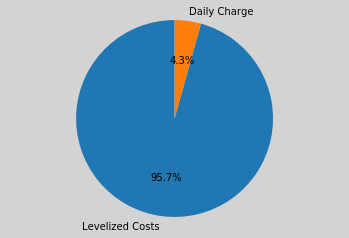

Total roof area of the  building: 599 m2
Total roof area used 593 m2
Percentage: 99.0%
succes
[[133.7080535416262, 171.9137008898087, 174.30524510130272, 34.259651029183544, 27.108737697550534, 41.03349449714486, 0.20011983001195768, 0.4993237529160278, 0.8253959453451722, 3074.29, 296.131, 0.0, 296.131, 0.0, {'Levelized Costs': 2941.2380000000007, 'Energy Charge': 0.009999999999536158, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59828458013, 45272.6, 593.065]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (132.65324747492616, 182.38453870383307, 166.76861139610207, 28.352107184228725, 30.295256402360327, 23.461198687201694, 0.20353599651204068, 0.4642149281177304, 0.6191306358677795)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 133
                                           a tilt of 28.4
                                           and a gcr of 0.204


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.44590950012207 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 30.3
                                           and a gcr of 0.464


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.323580503463745 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 167
                                           a tilt of 23.5
                                           and a gcr of 0.619


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.232023000717163 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [0.0, 225.239, 70.3075]


ERROR:ga_logger:Cost: 3068.48


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,068 per year


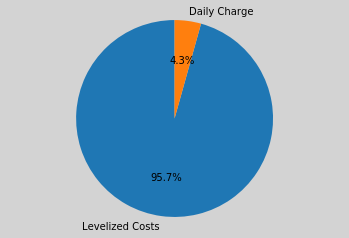

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[132.65324747492616, 182.38453870383307, 166.76861139610207, 28.352107184228725, 30.295256402360327, 23.461198687201694, 0.20353599651204068, 0.4642149281177304, 0.6191306358677795, 3068.48, 295.54650000000004, 0.0, 225.239, 70.3075, {'Levelized Costs': 2935.425, 'Energy Charge': 0.012999999999976808, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602458911184, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (163.99934257146353, 174.0473454770739, 176.22790406339365, 38.43688114785873, 28.295302300172757, 36.57084839971902, 0.24701648605462417, 0.5652970870333143, 0.6399696711169421)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 164
                                           a tilt of 38.4
                                           and a gcr of 0.247


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.495651960372925 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 174
                                           a tilt of 28.3
                                           and a gcr of 0.565


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2093796730041504 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 176
                                           a tilt of 36.6
                                           and a gcr of 0.640


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.223907947540283 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [31.9057, 265.462, 0.0]


ERROR:ga_logger:Cost: 3086.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,087 per year


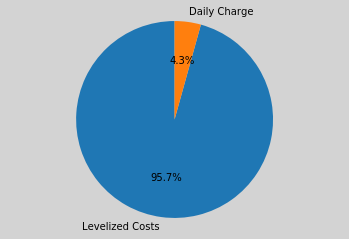

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[163.99934257146353, 174.0473454770739, 176.22790406339365, 38.43688114785873, 28.295302300172757, 36.57084839971902, 0.24701648605462417, 0.5652970870333143, 0.6399696711169421, 3086.57, 297.3677, 31.9057, 265.462, 0.0, {'Levelized Costs': 2953.5090000000005, 'Energy Charge': 0.019000000000005457, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60211742985, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (131.4394210046814, 172.99449935586975, 173.08607964121967, 34.285734858355156, 19.970540239236833, 46.58273483726639, 0.20009249133362092, 0.3680329728611406, 0.6317857904684668)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 131
                                           a tilt of 34.3
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.873560667037964 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 173
                                           a tilt of 20.0
                                           and a gcr of 0.368


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4098739624023438 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 173
                                           a tilt of 46.6
                                           and a gcr of 0.632


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.61077618598938 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [0.0, 97.0992, 211.603]


ERROR:ga_logger:Cost: 3199.15


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,199 per year


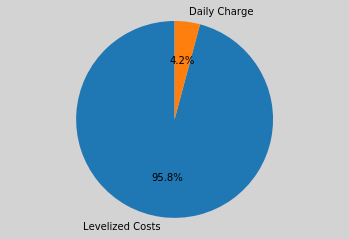

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[131.4394210046814, 172.99449935586975, 173.08607964121967, 34.285734858355156, 19.970540239236833, 46.58273483726639, 0.20009249133362092, 0.3680329728611406, 0.6317857904684668, 3199.15, 308.7022, 0.0, 97.0992, 211.603, {'Levelized Costs': 3066.0919999999996, 'Energy Charge': 0.016000000000360615, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60064665002, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125.18124735390506, 176.5559911663359, 210.41842375562436, 34.39306177427906, 28.862591855420426, 19.821725177480634, 0.49179626544268373, 0.49138854498939033, 0.658251968158733)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 34.4
                                           and a gcr of 0.492


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.642292737960815 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 177
                                           a tilt of 28.9
                                           and a gcr of 0.491


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2544262409210205 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 19.8
                                           and a gcr of 0.658


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.249243974685669 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 290.486, 5.00853]


ERROR:ga_logger:Cost: 3067.96


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,068 per year


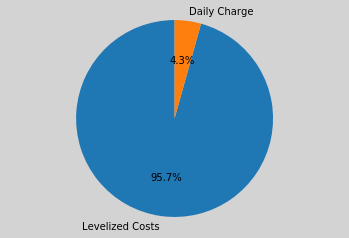

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[125.18124735390506, 176.5559911663359, 210.41842375562436, 34.39306177427906, 28.862591855420426, 19.821725177480634, 0.49179626544268373, 0.49138854498939033, 0.658251968158733, 3067.96, 295.49453, 0.0, 290.486, 5.00853, {'Levelized Costs': 2934.9, 'Energy Charge': 0.018000000000199634, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602162784984, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (117.93888020063166, 188.5551145547679, 148.93280833385242, 33.680169384533045, 25.589504361880362, 19.65209810128373, 0.20026901139860048, 0.46577484287284626, 0.7092335207965959)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 118
                                           a tilt of 33.7
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.461828231811523 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 189
                                           a tilt of 25.6
                                           and a gcr of 0.466


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.236575126647949 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 149
                                           a tilt of 19.7
                                           and a gcr of 0.709


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.172368288040161 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 240.366, 58.6567]


ERROR:ga_logger:Cost: 3103.02


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,103 per year


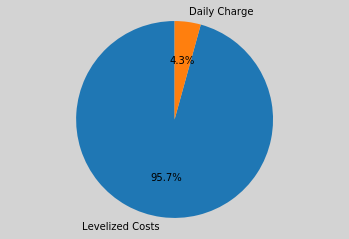

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[117.93888020063166, 188.5551145547679, 148.93280833385242, 33.680169384533045, 25.589504361880362, 19.65209810128373, 0.20026901139860048, 0.46577484287284626, 0.7092335207965959, 3103.02, 299.0227, 0.0, 240.366, 58.6567, {'Levelized Costs': 2969.958, 'Energy Charge': 0.020000000000095497, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603012249725, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (144.17898166044068, 180.6410151951947, 195.85445050322974, 44.28163446691899, 32.77046058853542, 34.57656462064797, 0.3670144292639865, 0.48782768527693804, 0.7499406959446326)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 144
                                           a tilt of 44.3
                                           and a gcr of 0.367


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.559945344924927 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 32.8
                                           and a gcr of 0.488


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.238051414489746 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 196
                                           a tilt of 34.6
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2370200157165527 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 287.88, 6.47598]


ERROR:ga_logger:Cost: 3056.66


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,057 per year


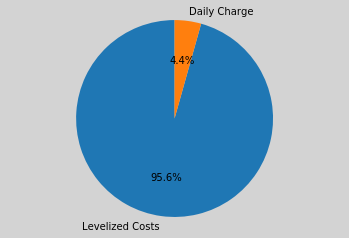

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[144.17898166044068, 180.6410151951947, 195.85445050322974, 44.28163446691899, 32.77046058853542, 34.57656462064797, 0.3670144292639865, 0.48782768527693804, 0.7499406959446326, 3056.66, 294.35598, 0.0, 287.88, 6.47598, {'Levelized Costs': 2923.6, 'Energy Charge': 0.01799999999997226, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60225639, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (121.6842945064698, 180.2512762079566, 188.81952313022057, 40.50582679127835, 26.053443393397227, 21.05275789352413, 0.2751849769372257, 0.4704658096204865, 0.6378967505663358)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 122
                                           a tilt of 40.5
                                           and a gcr of 0.275


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.55318546295166 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 26.1
                                           and a gcr of 0.470


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2470085620880127 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 189
                                           a tilt of 21.1
                                           and a gcr of 0.638


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3021576404571533 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 242.098, 53.6922]


ERROR:ga_logger:Cost: 3070.9


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,071 per year


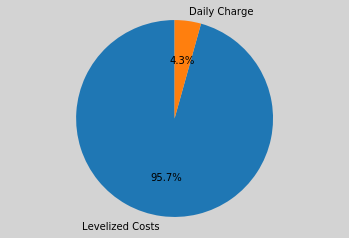

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[121.6842945064698, 180.2512762079566, 188.81952313022057, 40.50582679127835, 26.053443393397227, 21.05275789352413, 0.2751849769372257, 0.4704658096204865, 0.6378967505663358, 3070.9, 295.7902, 0.0, 242.098, 53.6922, {'Levelized Costs': 2937.8390000000004, 'Energy Charge': 0.019000000000005457, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60181231884, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (133.93613445934443, 166.19557472561013, 213.30475895006018, 32.76895843949291, 31.428766030204816, 27.446552828003156, 0.23832313560316476, 0.5021804556203743, 0.6780647345551308)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 134
                                           a tilt of 32.8
                                           and a gcr of 0.238


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.474823474884033 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 166
                                           a tilt of 31.4
                                           and a gcr of 0.502


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1868536472320557 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 213
                                           a tilt of 27.4
                                           and a gcr of 0.678


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.230659008026123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 297.335, 0.0]


ERROR:ga_logger:Cost: 3086.25


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,086 per year


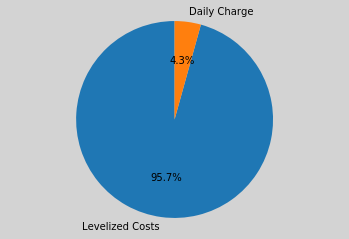

Total roof area of the  building: 599 m2
Total roof area used 592 m2
Percentage: 98.9%
succes
[[133.93613445934443, 166.19557472561013, 213.30475895006018, 32.76895843949291, 31.428766030204816, 27.446552828003156, 0.23832313560316476, 0.5021804556203743, 0.6780647345551308, 3086.25, 297.335, 0.0, 297.335, 0.0, {'Levelized Costs': 2953.192, 'Energy Charge': 0.016000000000190084, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60204199978, 61845.7, 592.089]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (133.69561319821418, 178.66948155991287, 185.64961459571649, 27.725535328634585, 30.318629824531353, 19.57075613606268, 0.20002509214323128, 0.49872017854270345, 0.5704965534035494)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 134
                                           a tilt of 27.7
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.489630699157715 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 179
                                           a tilt of 30.3
                                           and a gcr of 0.499


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1304757595062256 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 186
                                           a tilt of 19.6
                                           and a gcr of 0.570


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1793510913848877 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 295.341, 0.0]


ERROR:ga_logger:Cost: 3066.44


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,066 per year


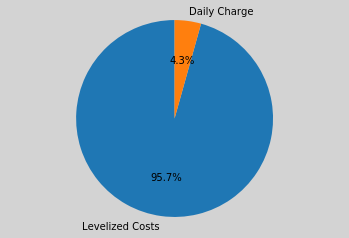

Total roof area of the  building: 599 m2
Total roof area used 592 m2
Percentage: 98.9%
succes
[[133.69561319821418, 178.66948155991287, 185.64961459571649, 27.725535328634585, 30.318629824531353, 19.57075613606268, 0.20002509214323128, 0.49872017854270345, 0.5704965534035494, 3066.44, 295.341, 0.0, 295.341, 0.0, {'Levelized Costs': 2933.378, 'Energy Charge': 0.01999999999998181, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60216730004, 61845.7, 592.197]]


ERROR:optimizer_logger:200


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:Runs_logger:Run nr 4 using opt-method ga-20 with 200 evalautions took: (min)


ERROR:Runs_logger:933.8297046860059


In [29]:
# GA
if (opt_method =="ga-20"):
    init_pop=20
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-50"):
    init_pop=50
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-net"):
    # implementation of the max_evaluations only works starting from 6 or higher
    # also if you set this max_evalutions to 10 it will stop after 9 evaluations
    # therefore I have added 1 to the max_evaluations. 
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE-NET")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-cost"):
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE")
    pvoptimizer.processGA(ga_fina)

# runtime in seconds
endtime=time.time()-t1
mintime=endtime/60
lrun.error("Run nr {} using opt-method {} with {} evalautions took: (min)".format(run_i,opt_method,number_of_opt_evaluations))
lrun.error(mintime)